# CQF - Final Project

**Author**: 
Frank Salvador Ygnacio Rosas 

**Cohort**: January 2022

***

# Deep Learning for Financial Time Series
#### A case of study of fractional differentiated features 

***

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# importing general base libraries
import sys
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from colour import Color
import statsmodels.api as sm # version 0.12.2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PolyCollection, LineCollection

# importing special libraries
import yfinance as yf
from arch.unitroot import ADF # version 5.3.1. 

# ML Tools libraries
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

# importing additional resources (developed specifically for this project)
from utilscqf import (
    Features, SFI_CQF, elbowKMeansIteration, 
    plotSilhouette, somAnalysis, ExperimentLSTM, comparissonLSTM
)

## 0. Assets

### i. Loading data

#### a. Base Equity Data

In [2]:
# public API data source (!uncomment to check equality compared to'edata.npy' file)
 
#stocks = ["RIG", "PZZA"]
#edata = {
# symbol: yf.download(symbol, start='2000-01-01', end='2022-07-30', auto_adjust=True, progress=False) for symbol in stocks
#}
#np.save("edata.npy", edata)

In [3]:
# load equities data from 'edata.npy' file
eqdata = np.load('edata.npy', allow_pickle='TRUE').item()

# define asset 1 ($RIG) and asset 2 ($PZZA) from 'eqdata' variable
asset1, asset2 = eqdata["RIG"], eqdata["PZZA"]

In [4]:
# check asset 1 
asset1.head()

Open       High        Low      Close   Volume
Date                                                           
2000-01-03  30.865927  30.923839  28.259987  30.402651  3183600
2000-01-04  29.649823  29.997283  28.549538  28.665358  3435806
2000-01-05  28.144172  28.607451  27.101795  27.680893  2439645
2000-01-06  27.796712  30.576384  27.796712  29.765648  3418665
2000-01-07  29.765646  31.734579  29.707737  31.502941  2301894

In [5]:
# check asset 2
asset2.head()

Open      High       Low     Close   Volume
Date                                                       
2000-01-03  5.832103  6.040889  5.651154  5.957375  2603600
2000-01-04  5.985212  6.013050  5.567639  5.678992  2580000
2000-01-05  5.762508  5.762508  5.567641  5.595479  1970400
2000-01-06  5.581560  5.706832  5.567641  5.595479  1035600
2000-01-07  5.665072  5.790344  5.595477  5.720748  1521200

#### b. Complementary Time Series Data (Indexes)

These indexes will be useful as complementary predictive features for the Feature Stage. 

In [6]:
# public API data source (!uncomment to check equality compared to'cfdata.npy' file)

#tsfeat = ["^FVX", "^TNX", "^TYX", "^VIX", "DX-Y.NYB"]
#cfdata = {
# ts: yf.download(ts, start='2000-01-01', end='2022-07-30', auto_adjust=True, progress=False) for ts in tsfeat
#}
#np.save("cfdata.npy", cfdata)

In [7]:
# load complementary features indexes data from 'cfdata.npy' file
cfidata = np.load('cfdata.npy', allow_pickle='TRUE').item()

# changing keys name for a simplified form to get feature indexes
_ = dict(zip(list(cfidata.keys()), ['FVX', 'TNX', 'TYX', 'VIX', 'DX']))
cfidata = dict([(_.get(k), v) for k, v in cfidata.items()])

In [8]:
#check head of each feature index
for keyfi, valfi in cfidata.items():
    print(f">> Feature Index: {keyfi}")
    print(valfi.head())

>> Feature Index: FVX
             Open   High    Low  Close  Volume
Date                                          
2000-01-03  6.411  6.473  6.411  6.457       0
2000-01-04  6.434  6.450  6.388  6.396       0
2000-01-05  6.427  6.489  6.396  6.489       0
2000-01-06  6.443  6.473  6.427  6.450       0
2000-01-07  6.443  6.490  6.397  6.397       0
>> Feature Index: TNX
             Open   High    Low  Close  Volume
Date                                          
2000-01-03  6.498  6.603  6.498  6.548       0
2000-01-04  6.530  6.548  6.485  6.485       0
2000-01-05  6.521  6.599  6.508  6.599       0
2000-01-06  6.558  6.585  6.540  6.549       0
2000-01-07  6.545  6.595  6.504  6.504       0
>> Feature Index: TYX
             Open   High    Low  Close  Volume
Date                                          
2000-01-03  6.537  6.598  6.537  6.598       0
2000-01-04  6.570  6.577  6.530  6.532       0
2000-01-05  6.560  6.633  6.421  6.631       0
2000-01-06  6.588  6.608  6.572  6.572   

In [9]:
# dropping volume since there are no volume data for these features indexes
cfidata = {key: dfVal.iloc[:,:-1] for key,dfVal in cfidata.items()}

### ii. Data Refinement

#### a. Base Equity Data

In [10]:
# check for missing values in asset 1
asset1.isnull().sum() 

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [11]:
# check for missing values in asset 2
asset2.isnull().sum() 

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [12]:
# testing both assets has same index
print(":::>>> Do both assets have same index datetime? :", all(asset1.index == asset2.index))

:::>>> Do both assets have same index datetime? : True


Since there are no missing values, no extra data refinement procedure is necessary. Notice that OHLC prices are already adjusted (parameter `auto_adjust=True` from the YahooFinance Public API data source). 

Now, let's just get a basic satistical description of the assets, and a simple boxplot.

In [13]:
# basic statistical description of asset 1
asset1.describe()

Open         High          Low        Close        Volume
count  5680.000000  5680.000000  5680.000000  5680.000000  5.680000e+03
mean     35.816128    36.401181    35.141914    35.774284  9.102311e+06
std      27.771414    28.140651    27.298506    27.734499  1.022747e+07
min       0.700000     0.710000     0.650000     0.670000  2.423410e+05
25%      11.717500    11.985000    11.500000    11.735000  2.845854e+06
50%      33.742819    34.386215    33.121122    33.765476  5.395382e+06
75%      50.005566    50.895411    49.049397    50.047621  1.249862e+07
max     129.018271   129.614686   127.626703   128.342361  1.457050e+08

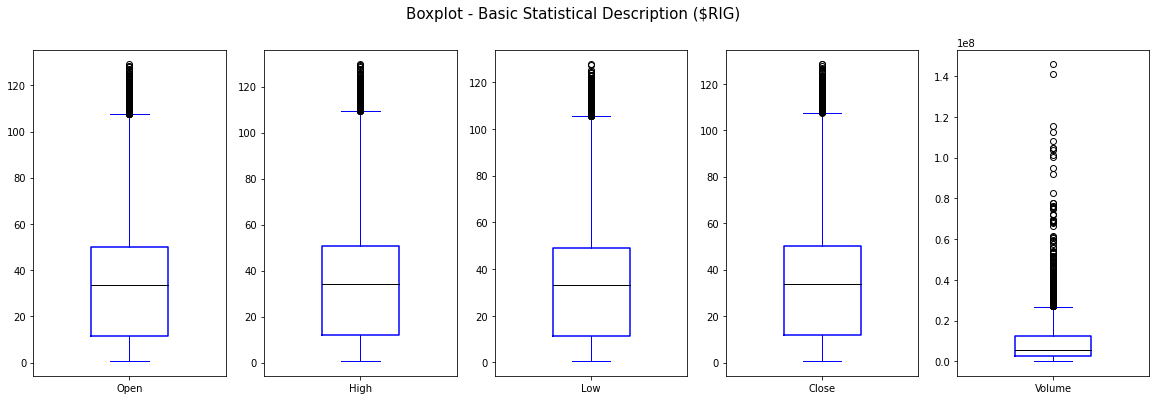

In [14]:
# boxplot for asset 1
asset1.plot(
    kind='box', subplots=True, figsize=(20,6), stacked=True, widths=0.4, color="blue", 
    boxprops=dict(color="blue", linewidth=1.5), medianprops=dict(color="black", linewidth=1)
)
plt.suptitle("Boxplot - Basic Statistical Description ($RIG)", fontsize=15, fontweight='medium')
plt.show()

In [15]:
# basic statistical description of asset 2
asset2.describe()

Open         High          Low        Close        Volume
count  5680.000000  5680.000000  5680.000000  5680.000000  5.680000e+03
mean     32.693512    33.176175    32.219225    32.704016  6.516481e+05
std      30.808413    31.267601    30.343826    30.811280  6.720242e+05
min       4.314919     4.454110     4.231406     4.370597  3.440000e+04
25%       8.630955     8.858670     8.553565     8.677723  3.014000e+05
50%      14.578305    14.783194    14.402370    14.596126  4.865000e+05
75%      53.173959    54.167787    52.449712    53.199616  7.575250e+05
max     137.302828   139.296128   133.599727   138.632721  1.444640e+07

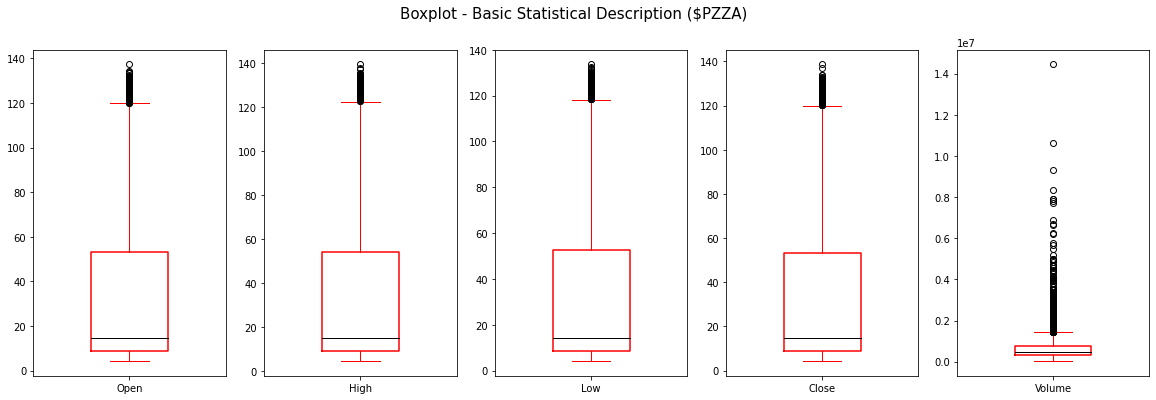

In [16]:
# boxplot for asset 2
asset2.plot(
    kind='box', subplots=True, figsize=(20,6), stacked=True, color="red", widths=0.4,
    boxprops=dict(color="red", linewidth=1.5), medianprops=dict(color="black", linewidth=1)           
)
plt.suptitle("Boxplot - Basic Statistical Description ($PZZA)", fontsize=15, fontweight='medium')
plt.show()

In [17]:
# finally, we can take advantage and define the labels for each asset to use later for asset 1
labelAsset1 = asset1.Close.pct_change().shift(-1).apply(
    lambda ret: 1 if ret>0 else (0 if ret < 0 else ret)
).dropna()
labelAsset1 = pd.DataFrame({'Label': labelAsset1.values}, index=labelAsset1.index)
label1Count = labelAsset1.value_counts(normalize=True)

# finally, we can take advantage and define the labels for each asset to use later for asset 2
labelAsset2 = asset2.Close.pct_change().shift(-1).apply(
    lambda ret: 1 if ret>0 else (0 if ret < 0 else ret)
).dropna()
labelAsset2 = pd.DataFrame({'Label': labelAsset2.values}, index=labelAsset2.index)
label2Count = labelAsset2.value_counts(normalize=True)

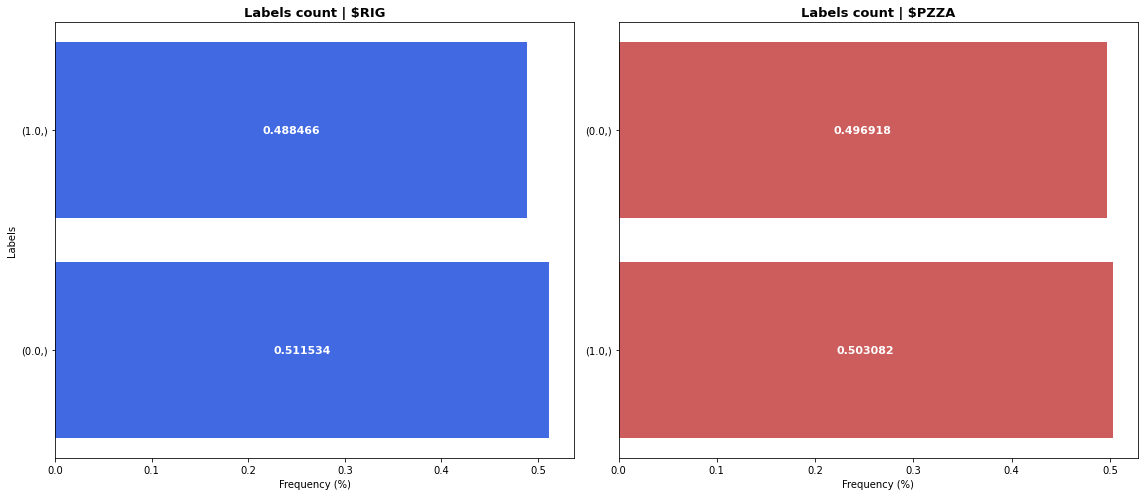

In [18]:
# plot labels ocurrency
fig, axes = plt.subplots(figsize=(16,7), nrows=1, ncols=2)
l1=axes[0].barh([str(val) for val in label1Count.index.values], label1Count.values, color='royalblue')
axes[0].set_xlabel("Frequency (%)")
axes[0].set_ylabel("Labels")
axes[0].bar_label(l1, label_type="center", fontweight='bold', fontsize=11, color='white')
axes[0].set_title("Labels count | $RIG", fontweight='bold', fontsize=13)
l2=axes[1].barh([str(val) for val in label2Count.index.values], label2Count.values, color='indianred')
axes[1].set_xlabel("Frequency (%)")
axes[1].bar_label(l2, label_type="center", fontweight='bold', fontsize=11, color='white')
axes[1].set_title("Labels count | $PZZA", fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

#### b. Complementary Time Series Data (Indexes)

In [19]:
#check head of each feature index
for keyfi, valfi in cfidata.items():
    print(f">> Feature Index: {keyfi} | Missing values verification")
    print(valfi.isnull().sum())

>> Feature Index: FVX | Missing values verification
Open     0
High     0
Low      0
Close    0
dtype: int64
>> Feature Index: TNX | Missing values verification
Open     0
High     0
Low      0
Close    0
dtype: int64
>> Feature Index: TYX | Missing values verification
Open     0
High     0
Low      0
Close    0
dtype: int64
>> Feature Index: VIX | Missing values verification
Open     0
High     0
Low      0
Close    0
dtype: int64
>> Feature Index: DX | Missing values verification
Open     0
High     0
Low      0
Close    0
dtype: int64


In [20]:
# get features indexes as feature submatrix for later use
featCloseIndexes = pd.DataFrame({"fClose"+keyfi: valfi["Close"] for keyfi, valfi in cfidata.items()})
featCloseIndexes.head()

fCloseFVX  fCloseTNX  fCloseTYX  fCloseVIX    fCloseDX
Date                                                              
2000-01-03      6.457      6.548      6.598  24.209999  100.220001
2000-01-04      6.396      6.485      6.532  27.010000  100.410004
2000-01-05      6.489      6.599      6.631  26.410000  100.379997
2000-01-06      6.450      6.549      6.572  25.730000  100.650002
2000-01-07      6.397      6.504      6.537  21.719999  100.800003

In [21]:
# check if in this join configuration are missing values in feature indexes
featCloseIndexes.isnull().sum()

fCloseFVX    39
fCloseTNX    39
fCloseTYX    39
fCloseVIX    32
fCloseDX      2
dtype: int64

In [22]:
# show first 5 events in which these missing values appear
featCloseIndexes[featCloseIndexes.isnull().any(axis=1)].head()

fCloseFVX  fCloseTNX  fCloseTYX  fCloseVIX    fCloseDX
Date                                                              
2000-01-17        NaN        NaN        NaN        NaN  102.050003
2000-02-21        NaN        NaN        NaN        NaN  104.580002
2000-07-04        NaN        NaN        NaN        NaN  107.290001
2000-11-23        NaN        NaN        NaN        NaN  118.089996
2001-01-15        NaN        NaN        NaN        NaN  109.970001

Missing values in `featCloseIndexes` seems to be moslty holidays. So, we can reduce them by passing the index datetime of our base assets. Then, if there is still any missing value, we can use a `ffill` procedure to fill it.  

In [23]:
featCloseIndexes=featCloseIndexes.loc[asset1.index]
featCloseIndexes.isnull().sum()

fCloseFVX    7
fCloseTNX    7
fCloseTYX    7
fCloseVIX    0
fCloseDX     2
dtype: int64

In [24]:
# how features index dataset looks before the fill forward procedure
featCloseIndexes.loc["2003-11-10":].head()

fCloseFVX  fCloseTNX  fCloseTYX  fCloseVIX   fCloseDX
Date                                                             
2003-11-10      3.461      4.460      5.278  17.620001  93.050003
2003-11-11        NaN        NaN        NaN  17.540001  93.099998
2003-11-12      3.413      4.412      5.217  16.750000  92.309998
2003-11-13      3.281      4.271      5.107  16.469999  91.610001
2003-11-14      3.201      4.233      5.061  16.940001  91.440002

In [25]:
# fill forward the few missing values (missing values with previous data to avoid lookahead bias)
featCloseIndexes.fillna(method='ffill', inplace=True)

In [26]:
# how features index dataset looks after the fill forward procedure
featCloseIndexes.loc["2003-11-10":].head()

fCloseFVX  fCloseTNX  fCloseTYX  fCloseVIX   fCloseDX
Date                                                             
2003-11-10      3.461      4.460      5.278  17.620001  93.050003
2003-11-11      3.461      4.460      5.278  17.540001  93.099998
2003-11-12      3.413      4.412      5.217  16.750000  92.309998
2003-11-13      3.281      4.271      5.107  16.469999  91.610001
2003-11-14      3.201      4.233      5.061  16.940001  91.440002

In [27]:
# we prove if there is still any missing value
featCloseIndexes.isnull().sum()

fCloseFVX    0
fCloseTNX    0
fCloseTYX    0
fCloseVIX    0
fCloseDX     0
dtype: int64

Thus, since there are no more missing values, no extra data refinement procedure is necessary. Notice that OHLC values are already adjusted (parameter `auto_adjust=True` from the YahooFinance Public API data source). 

Now, let's just get a basic boxplot of the feature indexes.

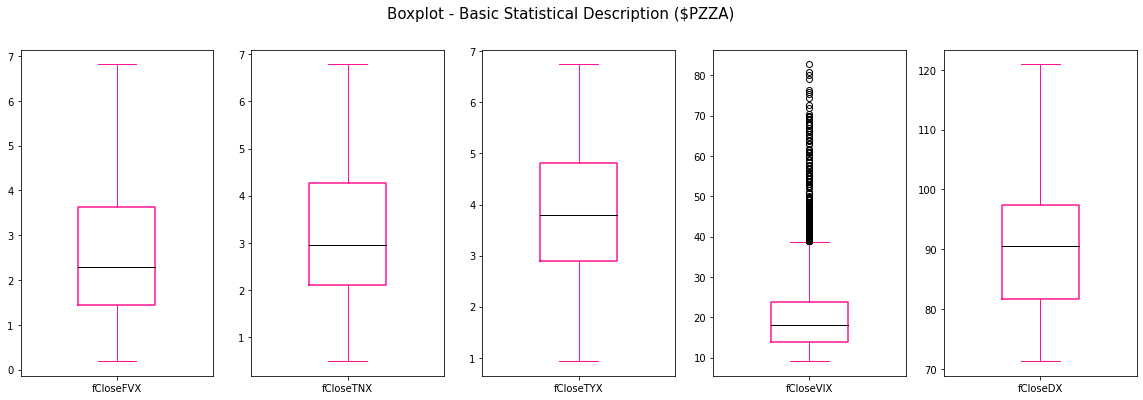

In [28]:
# boxplot for feature indexes dataset
featCloseIndexes.plot(
    kind='box', subplots=True, figsize=(20,6), stacked=True, color="deeppink", widths=0.4,
    boxprops=dict(color="deeppink", linewidth=1.5), medianprops=dict(color="black", linewidth=1)           
)
plt.suptitle("Boxplot - Basic Statistical Description ($PZZA)", fontsize=15, fontweight='medium')
plt.show()

### iii. Basic assets visualization

#### a. Computing logarithmic close prices

In [29]:
logAsset1 = np.log(asset1[['Close']])
logAsset2 = np.log(asset2[['Close']])

#### b. Plot a comparative visualization of logarithmic close prices for each asset

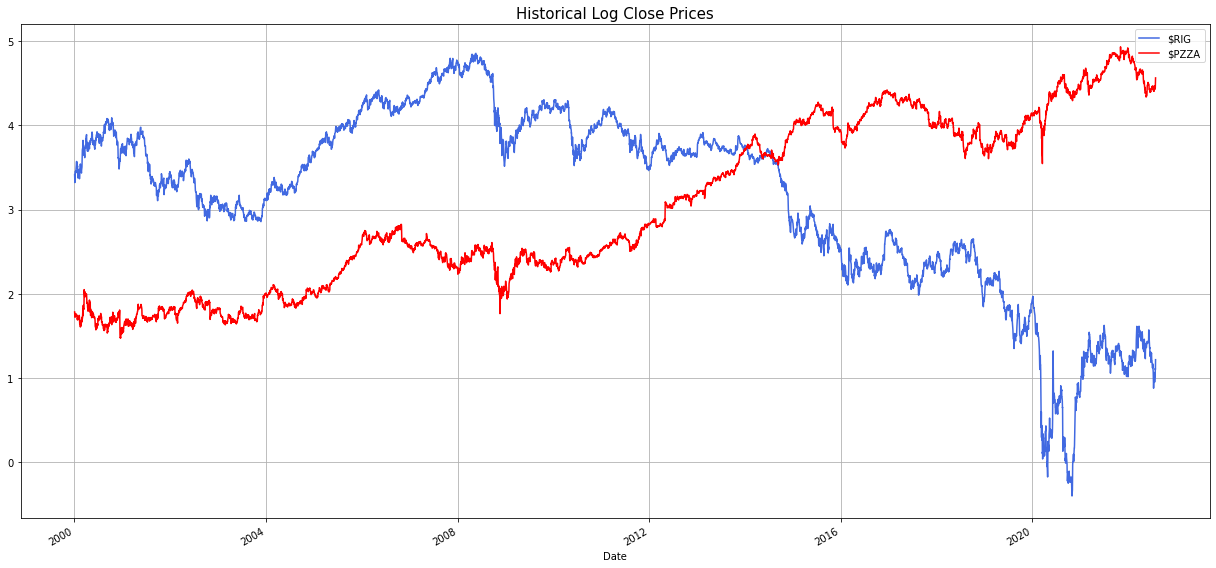

In [30]:
fig, ax = plt.subplots()
logAsset1["Close"].plot(figsize=(17,8), ax=ax, grid=True, color='royalblue')
logAsset2["Close"].plot(figsize=(17,8), ax=ax, grid=True, color='red')
ax.legend(["$RIG","$PZZA"])
ax.set_title(
    "Historical Log Close Prices", 
    fontdict={'fontsize': 15, 'fontweight': 'medium'}
)
plt.tight_layout()
plt.show()

#### c. Plot a comparative visualization of the Autocorrelation Function (ACF) for each asset

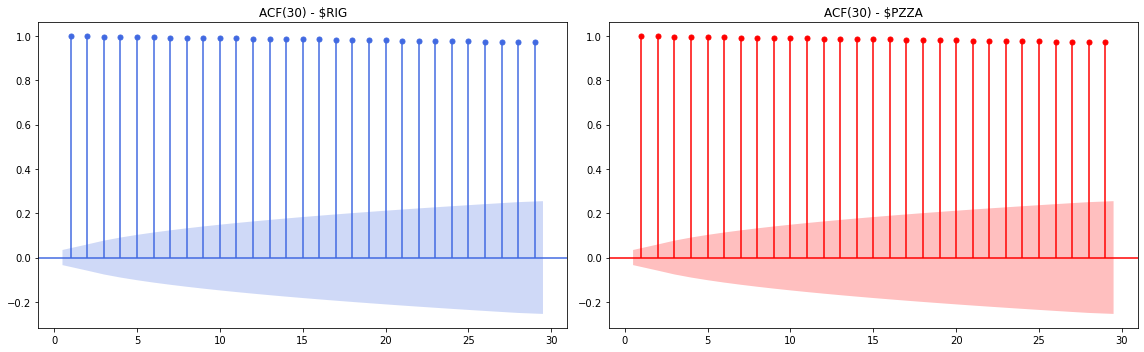

In [31]:
# plot Autocorrelation Function for Asset 1
curr_fig, curr_ax = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
sm.graphics.tsa.plot_acf(
    logAsset1['Close'].values,
    lags=range(1,30), alpha=1e-2,ax=curr_ax[0],
    title="ACF(30) - $RIG"
)
for item in curr_ax[0].collections:
    if type(item)==PolyCollection: item.set_facecolor("royalblue")
    if type(item)==LineCollection: item.set_color("royalblue")    
for item in curr_ax[0].lines: item.set_color("royalblue")

# plot Autocorrelation Function for Asset 2
sm.graphics.tsa.plot_acf(
    logAsset1['Close'].values,
    lags=range(1,30), alpha=1e-2,ax=curr_ax[1], 
    title="ACF(30) - $PZZA"
)
for item in curr_ax[1].collections:
    if type(item)==PolyCollection: item.set_facecolor("red")
    if type(item)==LineCollection: item.set_color("red")    
for item in curr_ax[1].lines: item.set_color("red")
plt.tight_layout()
plt.show()

## I. The Method: Fractional Differentation

### 1.1. Fractional Differentiation Procedure

In [32]:
# Weighting Rule - Window Fixed Method
def weightRule(d, tau):
    wList, k =[1.], 1 
    while abs(wList[-1])>tau:
        weight =-wList[-1]/k*(d-k+1)
        wList.append(weight)
        k+=1
    return np.array(wList[::-1][1:]).reshape(-1,1)

# Fractional Differentiation Main Function
def fractionalDTimeSeries(ts, d, tau=1e-4):
    """
    Fractional Differentiation for Time Series
    
    Description: 
        Computes the fractional differentiation of order 'd' 
        to a specific time series 'ts', given a tolerance of 'tau'.
    
    Parameters:
        - 'ts'  :: pd.core.Series/pd.core.DataFrame with shape (..., 1).
            > Base time series. It has the column with values to differentiate.
        - 'd'   :: positive integer/non-integer value. 
            > Order of differentiation.
        - 'tau' :: positive non-integer value close to 0. Default value: 1e-4.
            > Minimum weight associated to a data point to be preserved. 
    Output:
        - pd.core.Series/pd.ore.DataFrame with org. column but with differentiated values.
          The output object shape will be (... - length@weight, 1)
          
    References:
        - Lopez de Prado, M. (2018). Advances in Financial Machine Learning. Wiley, New Jersey, (75-88).
        - Ygnacio, F. "Fractional Differentiation on Long-Memory Time Series: 
          A Case of Study in Fractional Brownian Motion Processes" 
          from the Notebook Archive (2022), https://notebookarchive.org/2022-07-9nbew3e        
    """
    assert d >= 0, \
    f"Arg:: Order of diff {d} should be a positive real number. Please, increase it."    
    weights = weightRule(d, tau)
    assert len(weights) < ts.shape[0], \
    f"Arg:: Tolerance {tau} generates more weights than total observations. Please, increase it."
    return ts.rolling(len(weights)).apply(
        lambda x: np.dot(weights.T, x)
    ).dropna()

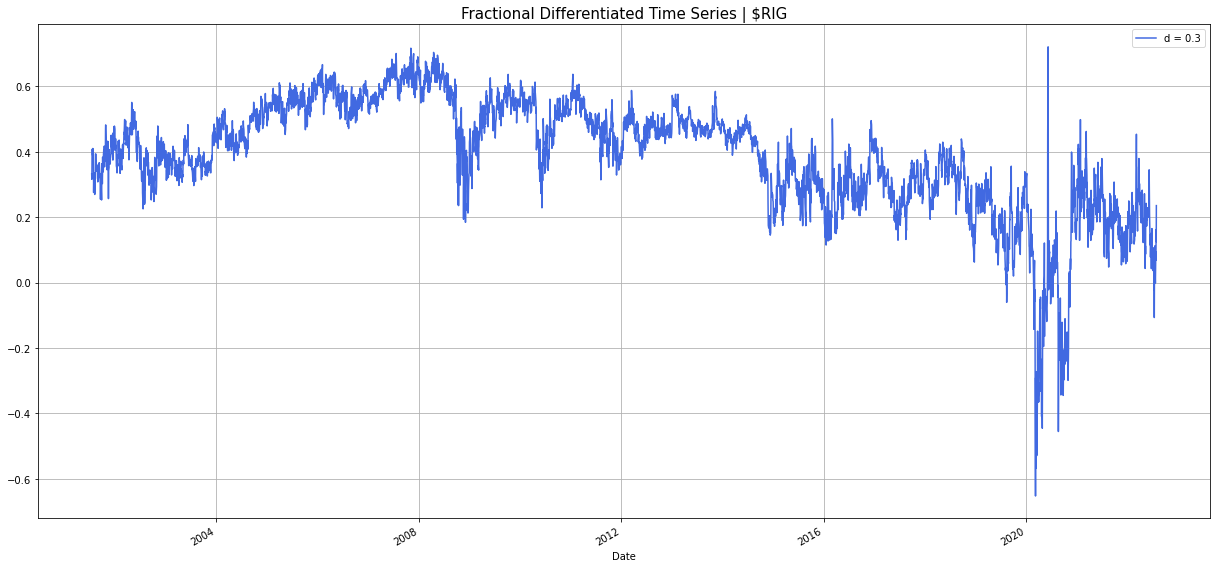

In [33]:
# example of fractional differentiation in asset 1
fractionalDTimeSeries(logAsset1["Close"], 0.3).plot(
    figsize=(17,8), grid=True, color='royalblue', label="d = 0.3"
)
plt.legend()
plt.title(
    "Fractional Differentiated Time Series | $RIG", 
    fontdict={'fontsize': 15, 'fontweight': 'medium'}
)
plt.tight_layout()
plt.show()

#### 1.1.1 Optimal Order of Differentiation: a relationship between Stationarity and Memory (sample)

Let's understand this relationship by using **$RIG**:

In [34]:
# computing a set 'd' order of differenciacion
dValues = np.arange(0,1,0.025) 

# apply all the frac. differentiations over the org. time series (!takes < 1 min) 
setFseries = [fractionalDTimeSeries(logAsset1, dVal) for dVal in dValues]

In [35]:
# get the ADF stat p-value & the ACF(1) for each transformed time series
acfCorrData = [
    [ADF(diffSeries['Close']).pvalue, sm.tsa.acf(diffSeries['Close'])[1]] 
    for diffSeries in setFseries
] 

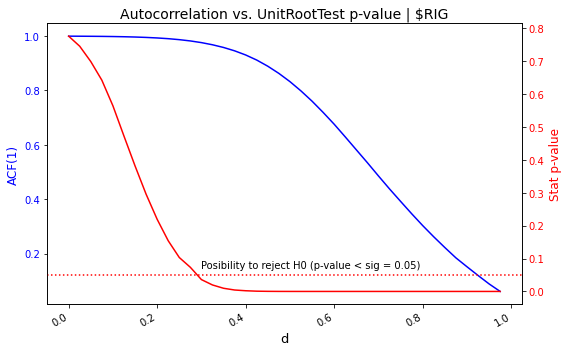

In [36]:
# plot the relationship between stationarity (ADF pVal sat) vs memory (ACF(1))
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

ax1.plot(dValues, list(zip(*acfCorrData))[1], color='blue')
ax2.plot(dValues, list(zip(*acfCorrData))[0], color='red')

ax1.set_xlabel("d", fontsize=13)
ax1.set_ylabel("ACF(1)", color='blue', fontsize=12, fontweight='medium')
ax1.tick_params(axis="y", labelcolor='blue')

ax2.set_ylabel("Stat p-value", color='red', fontsize=12, fontweight='medium')
ax2.tick_params(axis="y", labelcolor='red')

fig.autofmt_xdate()
plt.title("Autocorrelation vs. UnitRootTest p-value | $RIG", 
          fontdict={'fontsize': 14, 'fontweight': 'medium'})
plt.axhline(y=0.05, color='red', linestyle=':')
plt.text(0.3, 0.07,'Posibility to reject H0 (p-value < sig = 0.05)', fontsize=10)
plt.tight_layout()
plt.show()

### 1.2. Optimal Differentiation - Binary Search Procedure

In [37]:
def fractionalDOTimeSeries(ts, low, high, sig=0.05, t=1e-4, climit=1e-2):
    """
    Optimal Differentiation Procedure
    
    Description:
        Implements a Binary Search to find the optimal (min) order 'd'
        that pass the UnitRootTest for a given time series. 
        
    Parameters:
        - 'ts'  :: pd.core.Series/pd.core.DataFrame with shape (..., 1).
            > Base time series. It has the column with values to differentiate.\
        - 'high' :: positive integer/float
            > Represents the maximum order of differentiation 'd' expected to start
              the binary search
        - 'low' :: positive integer/float
            > Represents the minimum order of differentiation 'd' expected to start
              the binary search
        - 'sig' :: positive float 
            > Represents the required pValue to reject H0 in the Unit Root Test
              the binary search     
        - 't' :: positive non-integer value close to 0. Default value: 1e-4.
            > Minimum weight associated to a data point to be preserved. 
        - 'climit' :: positive non-integer value close to 0. Default value: 1e-4.
            > Order of convergence minimum between two last best solutions to cut the process.
            
    Output:
        - list composed by:
            > optimal d* (float)
            > differentiated time series with d* (pd.core.Series/pd.core.DataFrame)
            > autocorrelation value for lag = 1 (float)
            
    References:
        - Ygnacio, F. "Fractional Differentiation on Long-Memory Time Series: 
          A Case of Study in Fractional Brownian Motion Processes" 
          from the Notebook Archive (2022), https://notebookarchive.org/2022-07-9nbew3e   
          
    Note:
        Ygnacio (2022) implements a Fractional Differentiation procedure in Wolfram Language 
        using a recursive approach. For convenience, here we are using a iterative approach.
    """
    while (high-low) >= climit: 
        midOrderDiff = (low + high)/2
        fdTimeSeries = fractionalDTimeSeries(ts, midOrderDiff, t)
        statValue = ADF(fdTimeSeries).pvalue # allows constant trend, sames as MLDP (2018)
        if round(statValue, 4) < sig: 
            high = midOrderDiff
        else: 
            low = midOrderDiff
    return midOrderDiff, fdTimeSeries, statValue

### 1.3. Optimal Fractional Differentiation for each time series (Adj. Close)

#### Asset 1 : Transocean Ltd. ($RIG)

In [38]:
dop1, fdSerieslogAsset1, pval1 = fractionalDOTimeSeries(ts=logAsset1["Close"], low=0, high=1, sig=0.01)

#### Asset 2 : Papa Johns International Inc. ($PZZA)

In [39]:
dop2, fdSerieslogAsset2, pval2 = fractionalDOTimeSeries(ts=logAsset2["Close"], low=0, high=1, sig=0.01)

#### 1.3.1. Plot the differentiated time series of each asset

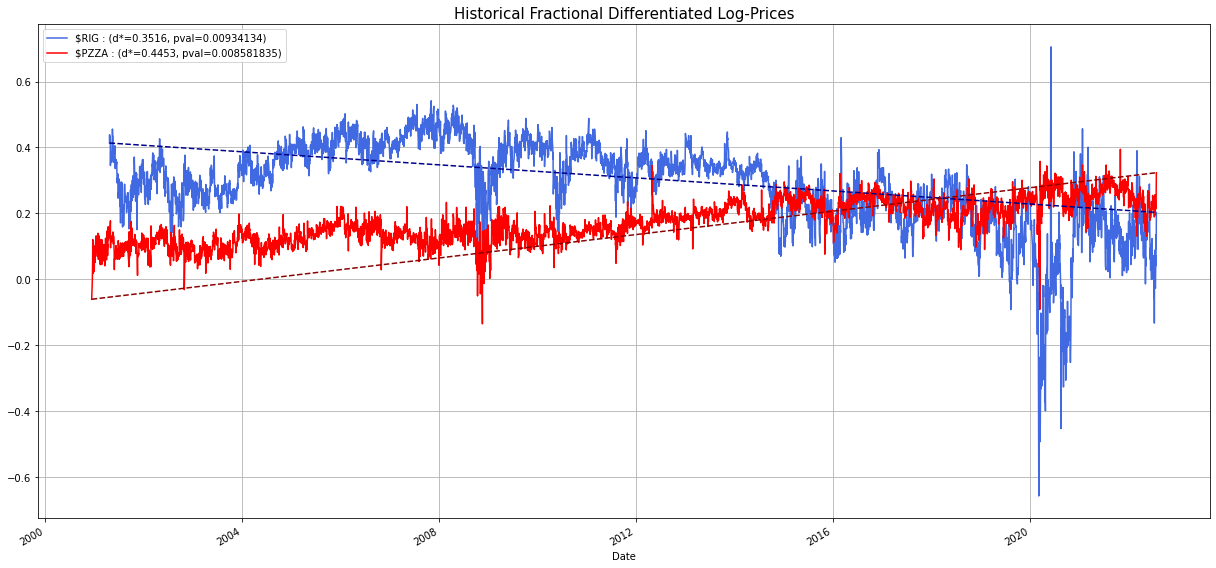

In [40]:
fig, ax = plt.subplots()
fdSerieslogAsset1.plot(figsize=(17,8), ax=ax, grid=True, color='royalblue')
fdSerieslogAsset2.plot(figsize=(17,8), ax=ax, grid=True, color='red')
ax.legend(
    [f"$RIG : (d*={round(dop1, 4)}, pval={round(pval1, 9)})", 
     f"$PZZA : (d*={round(dop2, 4)}, pval={round(pval2, 9)})"]
)
plt.plot(fdSerieslogAsset1.iloc[[0, -1]], color="darkblue", linestyle='--')
plt.plot(fdSerieslogAsset2.iloc[[0, -1]], color='darkred', linestyle='--')
ax.set_title(
    "Historical Fractional Differentiated Log-Prices", 
    fontdict={'fontsize': 15, 'fontweight': 'medium'}
)
plt.tight_layout()
plt.show()

#### 1.3.2. Plot the ACF of each fractional differentiated time series 

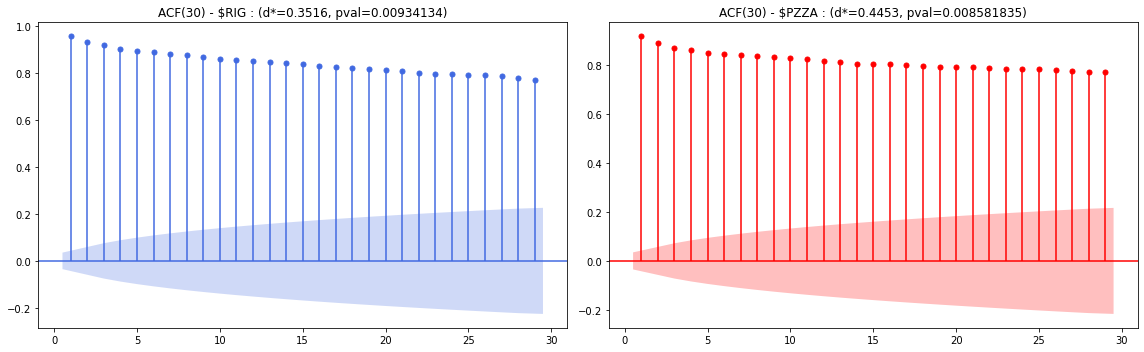

In [41]:
# Plot Autocorrelation Function for Frac. Differentiated Asset 1
curr_fig, curr_ax = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
sm.graphics.tsa.plot_acf(
    fdSerieslogAsset1.values,
    lags=range(1,30), alpha=1e-2,ax=curr_ax[0], 
    title=f"ACF(30) - $RIG : (d*={round(dop1, 4)}, pval={round(pval1, 9)})"
)
for item in curr_ax[0].collections:
    if type(item)==PolyCollection: item.set_facecolor("royalblue")
    if type(item)==LineCollection: item.set_color("royalblue")    
for item in curr_ax[0].lines: item.set_color("royalblue")

# Plot Autocorrelation Function for Frac. Differentiated Asset 2
sm.graphics.tsa.plot_acf(
    fdSerieslogAsset2.values,
    lags=range(1,30), alpha=1e-2,ax=curr_ax[1], 
    title=f"ACF(30) - $PZZA : (d*={round(dop2, 4)}, pval={round(pval2, 9)})"
)
for item in curr_ax[1].collections:
    if type(item)==PolyCollection: item.set_facecolor("red")
    if type(item)==LineCollection: item.set_color("red")    
for item in curr_ax[1].lines: item.set_color("red")
plt.tight_layout()
plt.show()

#### 1.3.2. Plot the traditional _d = 1_ differentiation for comparison

In [42]:
# compute the conventional differentiation of order 1
diffLogAsset1 = logAsset1.diff()
diffLogAsset2 = logAsset2.diff()

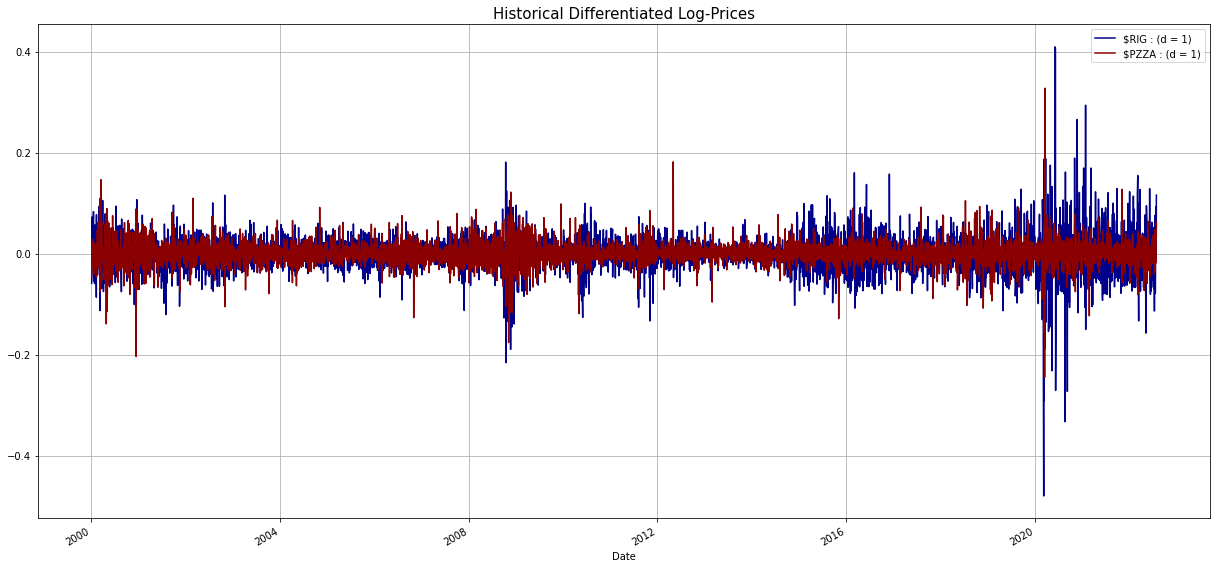

In [43]:
fig, ax = plt.subplots()
diffLogAsset1.plot(figsize=(17,8), ax=ax, grid=True, color='darkblue')
diffLogAsset2.plot(figsize=(17,8), ax=ax, grid=True, color='darkred')
ax.legend(
    [f"$RIG : (d = {1})", 
     f"$PZZA : (d = {1})"]
)
ax.set_title(
    "Historical Differentiated Log-Prices", 
    fontdict={'fontsize': 15, 'fontweight': 'medium'}
)
plt.tight_layout()
plt.show()

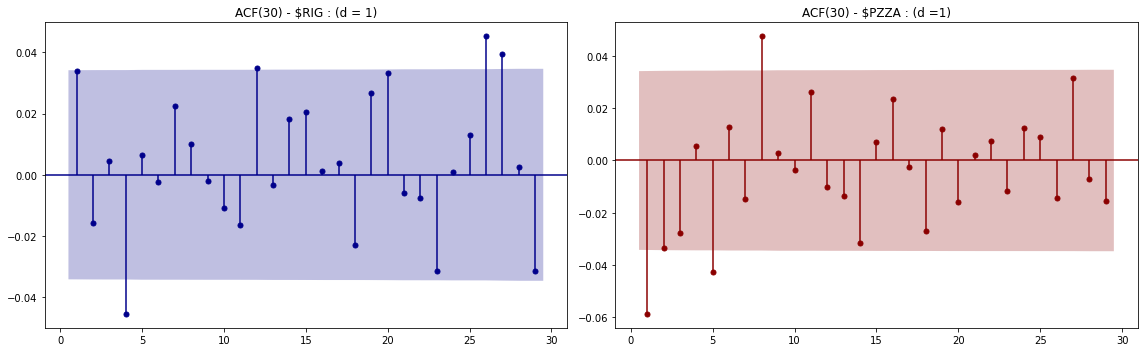

In [44]:
# Plot Autocorrelation Function for Frac. Differentiated Asset 1
curr_fig, curr_ax = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
sm.graphics.tsa.plot_acf(
    diffLogAsset1.dropna().values,
    lags=range(1,30), alpha=1e-2,ax=curr_ax[0], 
    title=f"ACF(30) - $RIG : (d = {1})"
)
for item in curr_ax[0].collections:
    if type(item)==PolyCollection: item.set_facecolor("darkblue")
    if type(item)==LineCollection: item.set_color("darkblue")    
for item in curr_ax[0].lines: item.set_color("darkblue")

# Plot Autocorrelation Function for Frac. Differentiated Asset 2
sm.graphics.tsa.plot_acf(
    diffLogAsset2.dropna().values,
    lags=range(1,30), alpha=1e-2,ax=curr_ax[1], 
    title=f"ACF(30) - $PZZA : (d ={1})"
)
for item in curr_ax[1].collections:
    if type(item)==PolyCollection: item.set_facecolor("darkred")
    if type(item)==LineCollection: item.set_color("darkred")    
for item in curr_ax[1].lines: item.set_color("darkred")
plt.tight_layout()
plt.show()

## II. Features Stage

### 2.1. Data Preprocessing

Computing adjusted log prices.

In [45]:
# computing logarithmic scaling for adjusted OHLC prices for asset 1
adjLogAsset1 = asset1.iloc[:,:-1].apply(lambda x: np.log(x))
adjLogAsset1['Volume'] = asset1['Volume']
adjLogAsset1.head()

Open      High       Low     Close   Volume
Date                                                       
2000-01-03  3.429653  3.431527  3.341447  3.414530  3183600
2000-01-04  3.389456  3.401107  3.351641  3.355689  3435806
2000-01-05  3.337340  3.353667  3.299600  3.320742  2439645
2000-01-06  3.324918  3.420228  3.324918  3.393355  3418665
2000-01-07  3.393355  3.457407  3.391408  3.450081  2301894

In [46]:
# computing logarithmic scaling for adjusted OHLC prices for asset 2
adjLogAsset2 = asset2.iloc[:,:-1].apply(lambda x: np.log(x))
adjLogAsset2['Volume'] = asset2['Volume']
adjLogAsset2.head()

Open      High       Low     Close   Volume
Date                                                       
2000-01-03  1.763378  1.798551  1.731860  1.784630  2603600
2000-01-04  1.789292  1.793932  1.716971  1.736774  2580000
2000-01-05  1.751373  1.751373  1.716971  1.721959  1970400
2000-01-06  1.719468  1.741664  1.716971  1.721959  1035600
2000-01-07  1.734320  1.756192  1.721959  1.744100  1521200

### 2.2. Features Computation

Features computation will be done over original dataset. Then, a different features-dataset will be created using ``fractionalDOTimeSeries`` for each of them.

#### 2.2.1 Features Class

The base features class is computed in the `featurescqf.py` file. Please, attach it to your local repository for a proper use.

#### 2.2.2 Features Computation

##### 2.2.2.1. Features parameters definition 

In [47]:
# framework 1
frame1 = [10, 14, 21]

# framework 2
frame2 = [5, 10, 21]

# framework 3
frame3 = [50, 200]

# deviations
stds = [2, 3, 4]

In [48]:
# RSI time framework
rsi_tf = frame1

# SMA time framework
sma_tf = frame2 + frame3

# MACD time framework configuration (all possible combinations for w1 and w2)
macd_tf = list(itertools.product(frame2, frame3))

# ATR time framework
atr_tf = frame1

# BBand timeframework configuration (all possible combinations for std and w)
bb_tf = list(itertools.product(stds, frame2[-2:]))

##### 2.2.2.2. Main features Computation 

In [49]:
# computing features dataframe for adj log asset 1
featdf1_ = Features(adjLogAsset1).compute_features(
    rsi_window=rsi_tf, 
    sma_window=sma_tf,
    macd_windows=macd_tf,
    atr_window=atr_tf,
    bb_window_std=bb_tf,
)
# concatenating feature indexes time series (only close prices) for asset 1
featdf1 = pd.concat(
    [featdf1_, featCloseIndexes], axis=1
)
featdf1.tail()

featSAR_0.2_val  featRSI_10w  featRSI_14w  featRSI_21w  \
Date                                                                 
2022-07-25         0.872028    44.942847    42.747525    41.782953   
2022-07-26         0.880010    43.923808    42.038395    41.301286   
2022-07-27         0.887673    53.942643    49.784270    46.855539   
2022-07-28         0.901321    52.824493    49.031848    46.364361   
2022-07-29         0.920498    62.831758    57.179364    52.479004   

            featSMA_5w  featSMA_10w  featSMA_21w  featSMA_50w  featSMA_200w  \
Date                                                                          
2022-07-25    1.017919     0.988832     1.097059     1.266121      1.288575   
2022-07-26    1.010130     0.989556     1.086056     1.261905      1.286942   
2022-07-27    1.019560     1.001417     1.077479     1.257654      1.285671   
2022-07-28    1.042784     1.023648     1.068168     1.251867      1.284287   
2022-07-29    1.096028     1.052219     1.066780     1.248005      1.283728   

            featMACD_5w_50w  ...  featALPHA101  featCORWINS_1mw  \
Date                         ...                                  
2022-07-25        -0.217819  ...      0.621536         0.216700   
2022-07-26        -0.212537  ...     -0.707886         0.000000   
2022-07-27        -0.200774  ...      0.833747         0.000000   
2022-07-28        -0.186717  ...     -0.442375         0.008845   
2022-07-29        -0.165335  ...      0.801774         0.000000   

            featBECKERP_1mw  featKYLEL    featQM_21w  fCloseFVX  fCloseTNX  \
Date                                                                         
2022-07-25         0.138688   0.000786  1.096459e+07      2.900      2.820   
2022-07-26         0.230371   0.000000  1.125822e+07      2.885      2.787   
2022-07-27         0.222462   0.000870  1.241053e+07      2.797      2.734   
2022-07-28         0.216876   0.000000  1.280368e+07      2.703      2.681   
2022-07-29         0.305747   0.000826  2.436476e+07      2.695      2.642   

            fCloseTYX  fCloseVIX    fCloseDX  
Date                                          
2022-07-25      3.049  23.360001  106.480003  
2022-07-26      3.009  24.690001  107.190002  
2022-07-27      3.002  23.240000  106.449997  
2022-07-28      3.039  22.330000  106.349998  
2022-07-29      2.974  21.330000  105.900002  

[5 rows x 40 columns]

In [50]:
# computing features dataframe for adj log asset 2
featdf2_ = Features(adjLogAsset2).compute_features(
    rsi_window=rsi_tf, 
    sma_window=sma_tf,
    macd_windows=macd_tf,
    atr_window=atr_tf,
    bb_window_std=bb_tf,
)

# concatenating feature indexes time series (only close prices) for asset 1
featdf2 = pd.concat(
    [featdf2_, featCloseIndexes], axis=1
)
featdf2.tail()

featSAR_0.2_val  featRSI_10w  featRSI_14w  featRSI_21w  \
Date                                                                 
2022-07-25         4.390292    48.293480    48.747604    48.210566   
2022-07-26         4.392099    45.912564    47.037964    47.093985   
2022-07-27         4.393870    51.101782    50.648968    49.474357   
2022-07-28         4.395605    63.582435    60.073725    56.136259   
2022-07-29         4.399840    72.635222    67.799038    62.235164   

            featSMA_5w  featSMA_10w  featSMA_21w  featSMA_50w  featSMA_200w  \
Date                                                                          
2022-07-25    4.455922     4.441934     4.443780     4.431319      4.661646   
2022-07-26    4.451140     4.441055     4.443934     4.432316      4.659606   
2022-07-27    4.446780     4.440845     4.444354     4.433190      4.657764   
2022-07-28    4.454202     4.449991     4.447632     4.435156      4.656209   
2022-07-29    4.475485     4.462400     4.453283     4.438519      4.654879   

            featMACD_5w_50w  ...  featALPHA101  featCORWINS_1mw  \
Date                         ...                                  
2022-07-25        -0.016380  ...     -0.669425         0.038953   
2022-07-26        -0.016289  ...      0.000000         0.000000   
2022-07-27        -0.015844  ...      0.277423         0.000000   
2022-07-28        -0.012039  ...      0.911600         0.000000   
2022-07-29        -0.003091  ...      0.776123         0.000000   

            featBECKERP_1mw  featKYLEL    featQM_21w  fCloseFVX  fCloseTNX  \
Date                                                                         
2022-07-25         0.058988   0.000000  1.602340e+06      2.900      2.820   
2022-07-26         0.078389   0.000000  1.670228e+06      2.885      2.787   
2022-07-27         0.069147   0.000901  1.703077e+06      2.797      2.734   
2022-07-28         0.091720   0.001560  3.364422e+06      2.703      2.681   
2022-07-29         0.135680   0.001474  5.472016e+06      2.695      2.642   

            fCloseTYX  fCloseVIX    fCloseDX  
Date                                          
2022-07-25      3.049  23.360001  106.480003  
2022-07-26      3.009  24.690001  107.190002  
2022-07-27      3.002  23.240000  106.449997  
2022-07-28      3.039  22.330000  106.349998  
2022-07-29      2.974  21.330000  105.900002  

[5 rows x 40 columns]

##### 2.2.2.3. Plot features signal for two assets

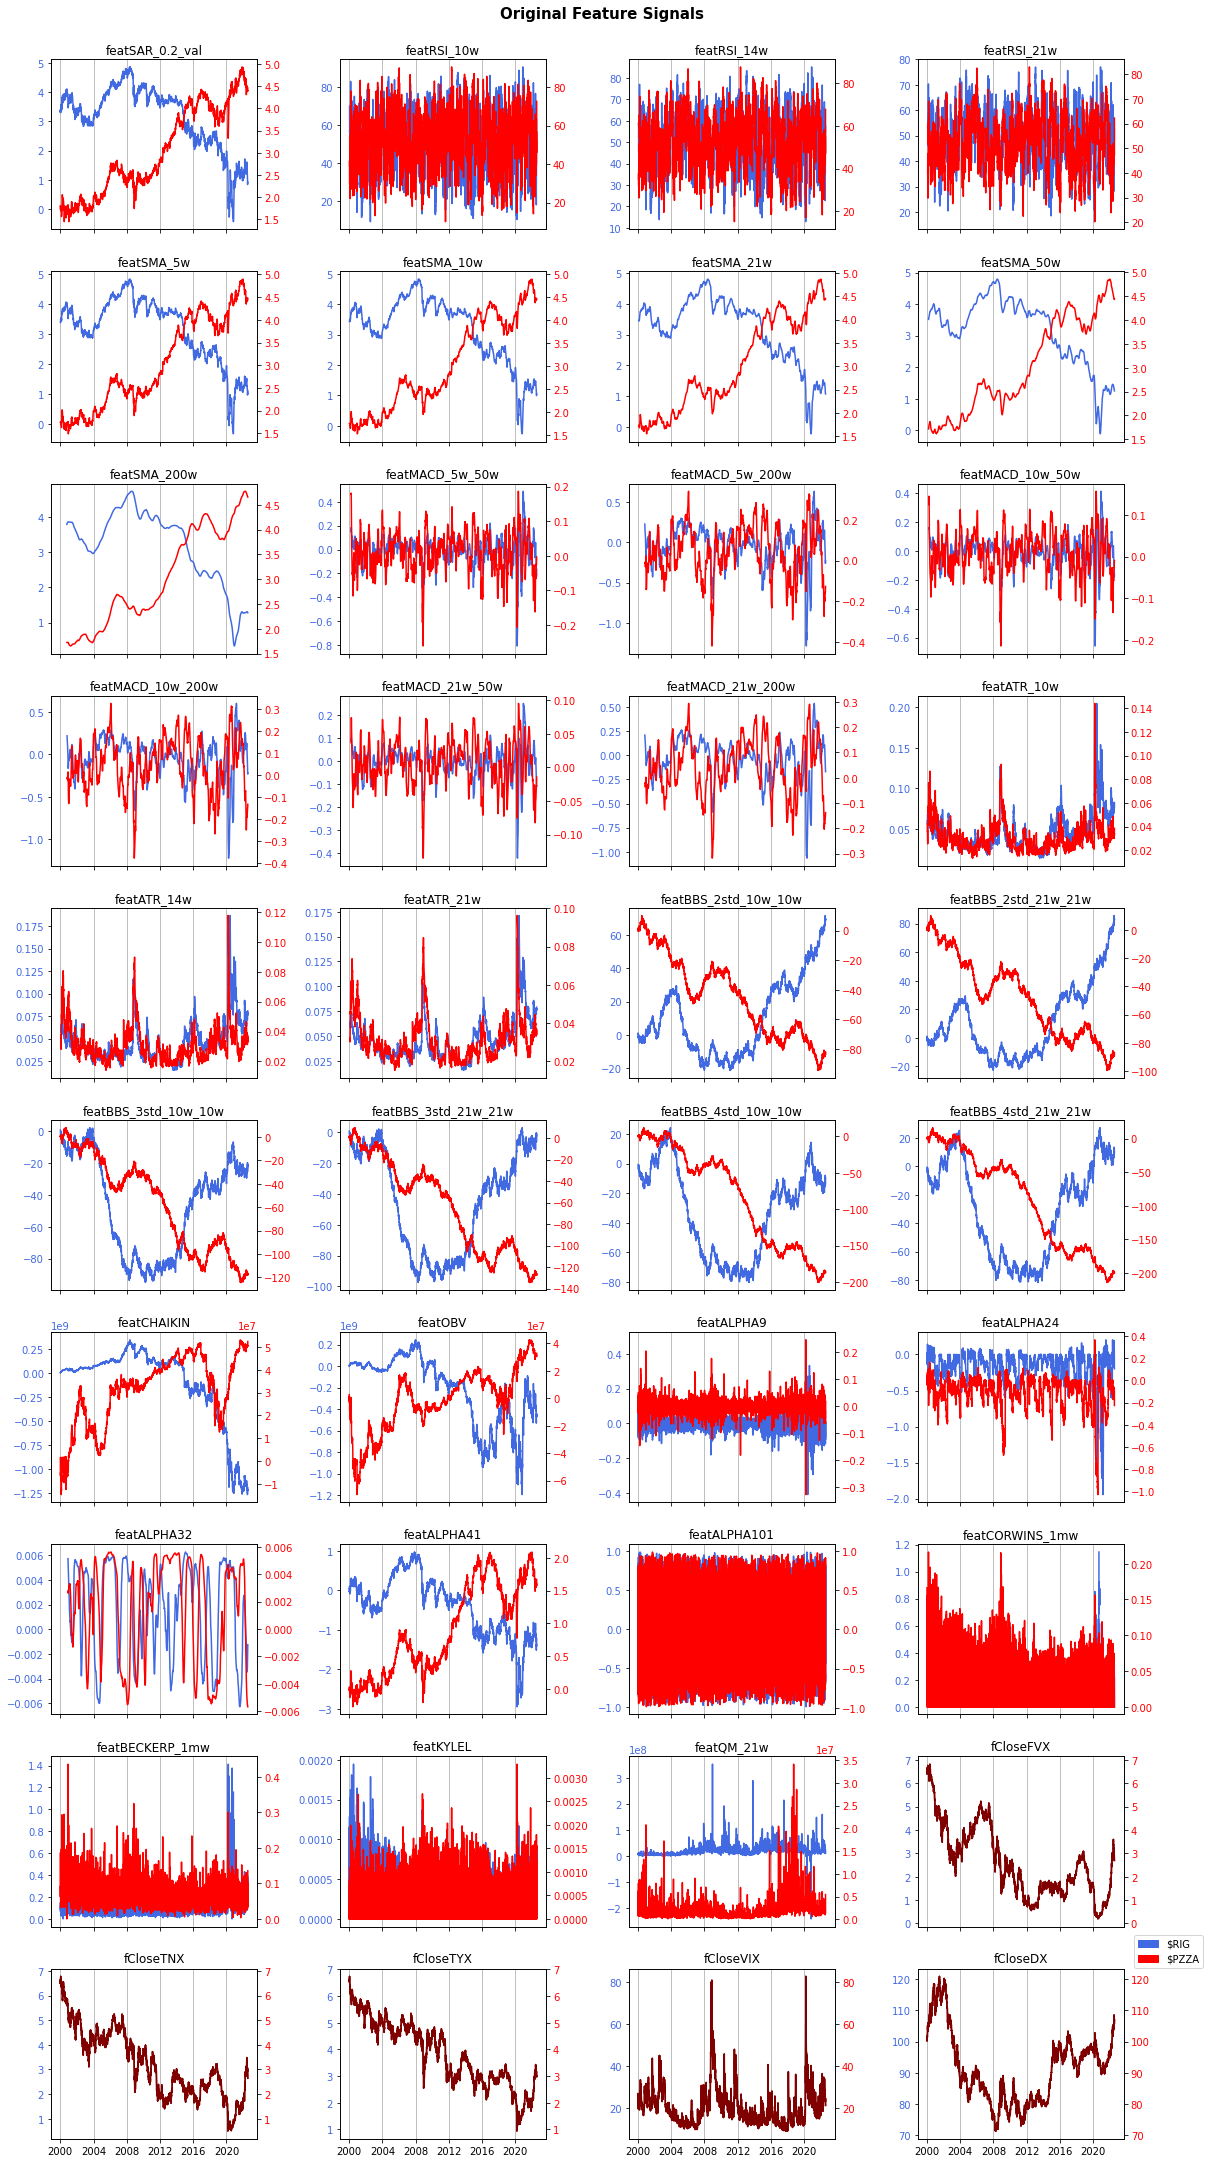

In [51]:
# plot features signal database
fig, axes = plt.subplots(figsize=(17,30), nrows=10, ncols=4, sharex=True)
for c, ax1 in zip(featdf1, axes.flatten()):
    colorA1, colorA2 = 'royalblue', 'red'
    if "fClose" in c: colorA1, colorA2 ="maroon", "maroon"
    ax2 = ax1.twinx()
    ax1.plot(featdf1[c], color=colorA1)
    ax2.plot(featdf2[c], color=colorA2)    
    ax1.xaxis.grid(True)
    ax2.xaxis.grid(True)    
    ax1.set_title(f'{c}', fontweight='medium')
    ax1.tick_params(axis="y", labelcolor='royalblue')
    ax2.tick_params(axis="y", labelcolor='red')
legAsset1 = mpatches.Patch(color='royalblue', label='$RIG')
legAsset2 = mpatches.Patch(color='red', label='$PZZA')
fig.suptitle('Original Feature Signals',fontweight ="bold", y=1+1e-4, fontsize=15)
plt.legend(handles=[legAsset1, legAsset2], bbox_to_anchor=(1.05, 1.2), loc='upper left', borderaxespad=0)
plt.tight_layout() 
plt.show()

### 2.3. Features Fractional Differentiation method

Lopez de Prado (2018) proposes a cumulative sum of features time series to ensure some order of differentiation is needed. We will apply it only for stationary features.

#### 2.3.1. Computing ADF test over features database

In [52]:
# level of significance
siglevel = 0.01

In [53]:
# get only stationary features for asset 1
statFeat1 = featdf1.apply(lambda featseries: ADF(featseries.dropna()).pvalue < siglevel)
statFeat1 = statFeat1[statFeat1].index

# get only stationary features for asset 2
statFeat2 = featdf2.apply(lambda featseries: ADF(featseries.dropna()).pvalue < siglevel)
statFeat2 = statFeat2[statFeat2].index

In [54]:
# check stationary features por asset 1
print(statFeat1)

Index(['featRSI_10w', 'featRSI_14w', 'featRSI_21w', 'featMACD_5w_50w',
       'featMACD_5w_200w', 'featMACD_10w_50w', 'featMACD_10w_200w',
       'featMACD_21w_50w', 'featMACD_21w_200w', 'featATR_10w', 'featATR_14w',
       'featATR_21w', 'featALPHA9', 'featALPHA24', 'featALPHA32',
       'featALPHA101', 'featCORWINS_1mw', 'featBECKERP_1mw', 'featKYLEL',
       'featQM_21w', 'fCloseVIX'],
      dtype='object')


In [55]:
# both assets shares the same stationary features 
print(":::>>> Do both assets have same stationary features? :", all(statFeat1 == statFeat2))

:::>>> Do both assets have same stationary features? : True


#### 2.3.2. Replacing stationary features by its cumulative sum form

In [56]:
# make a copy of original features datasets
cumfeatdf1, cumfeatdf2 = featdf1.copy(), featdf2.copy()  

In [57]:
# replace stationary features by its cumulative sum form for both assets
cumfeatdf1[statFeat1] = cumfeatdf1[statFeat1].cumsum()
cumfeatdf2[statFeat2] = cumfeatdf2[statFeat2].cumsum()

#### 2.3.3. Compute the optimal fractional differentiation for the new features dataset
This process might take some time (5 minutes).

In [58]:
# optimal fractional order of differentiation to new cumsum features database for asset 1
setfdfeatures1 = cumfeatdf1.apply(lambda cumfeat: fractionalDOTimeSeries(ts=cumfeat, low=0, high=1, sig=0.01))

# optimal fractional order of differentiation to new cumsum features database for asset 2
setfdfeatures2 = cumfeatdf2.apply(lambda cumfeat: fractionalDOTimeSeries(ts=cumfeat, low=0, high=1, sig=0.01))

##### a. Plot different d* required per feature for both assets

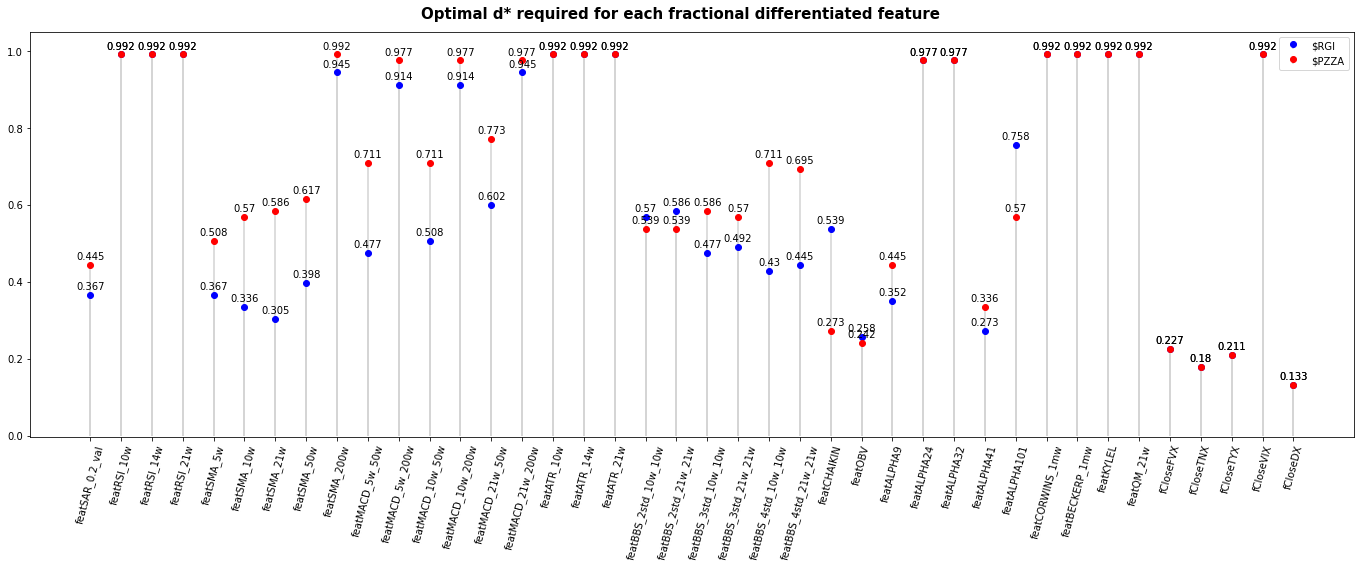

In [59]:
# d* required per feature for both assets
fig, ax = plt.subplots(figsize=(19,8))
plt.stem(setfdfeatures1.columns, setfdfeatures1.iloc[0], 'lightgrey', markerfmt='bo', label='$RGI', basefmt=" ")
for x,y in zip(setfdfeatures1.columns, setfdfeatures1.iloc[0]):
    plt.annotate(f'{round(y, 3)}', xy=(x,y), xytext=(0,5), textcoords='offset points', ha='center')
plt.stem(setfdfeatures2.columns, setfdfeatures2.iloc[0], 'lightgrey', markerfmt='ro', label='$PZZA', basefmt=" ")
for x,y in zip(setfdfeatures2.columns, setfdfeatures2.iloc[0]):
    plt.annotate(f'{round(y, 3)}', xy=(x,y), xytext=(0,5), textcoords='offset points', ha='center')
fig.suptitle(
    'Optimal d* required for each fractional differentiated feature', 
    fontweight ="semibold", fontsize=15
)
plt.xticks(rotation=75)
plt.ylim(-0.001, 1.05)
plt.tight_layout()
plt.legend()
plt.show()

##### b. Build the new fractional differentiated features database

In [60]:
# getting fractional differentiated features for asset 1
fdfeatdf1 = pd.concat(setfdfeatures1.iloc[1].values, axis=1)

# getting fractional differentiated features for asset 2
fdfeatdf2 = pd.concat(setfdfeatures2.iloc[1].values, axis=1)

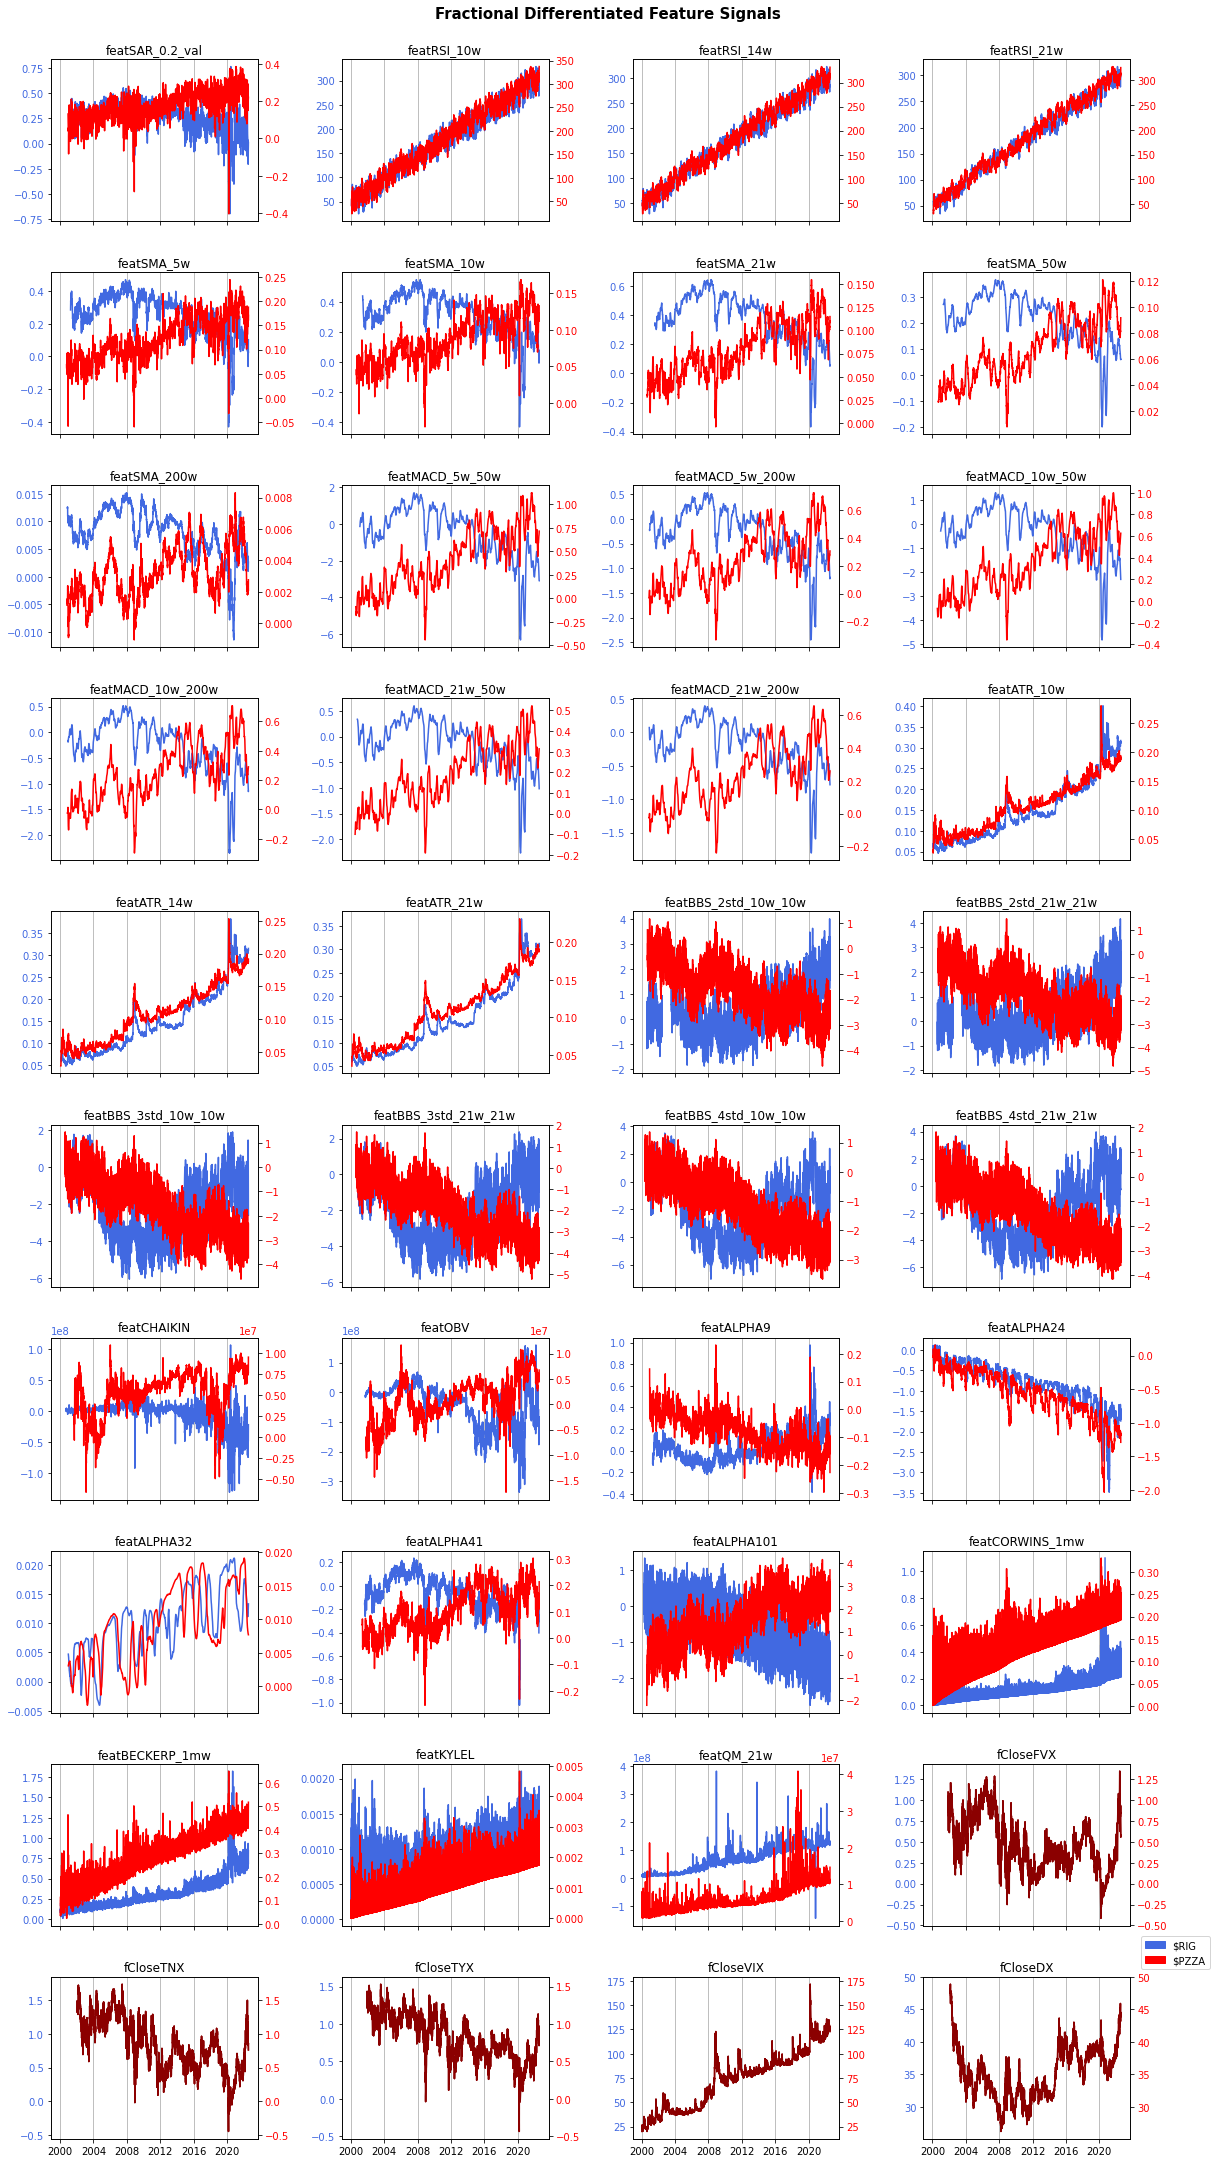

In [61]:
# plotting fractional differentiated features database
fig, axes = plt.subplots(figsize=(17,30), nrows=10, ncols=4, sharex=True)
for c, ax1 in zip(fdfeatdf1, axes.flatten()):
    colorA1, colorA2 = 'royalblue', 'red'
    if "fClose" in c: colorA1, colorA2 ="darkred", "darkred"    
    ax2 = ax1.twinx()
    ax1.plot(fdfeatdf1[c], color=colorA1)
    ax2.plot(fdfeatdf2[c], color=colorA2)    
    ax1.xaxis.grid(True)
    ax2.xaxis.grid(True)    
    ax1.set_title(f'{c}', fontweight='medium')
    ax1.tick_params(axis="y", labelcolor='royalblue')
    ax2.tick_params(axis="y", labelcolor='red')
legAsset1 = mpatches.Patch(color='royalblue', label='$RIG')
legAsset2 = mpatches.Patch(color='red', label='$PZZA')
fig.suptitle('Fractional Differentiated Feature Signals',fontweight ="bold", y=1+1e-4, fontsize=15)
plt.legend(handles=[legAsset1, legAsset2], bbox_to_anchor=(1.05, 1.25), loc='upper left', borderaxespad=0)
plt.tight_layout() 
plt.show()

### 2.4. Feature Selection

### Part I - Feature Dimensionality Reduction

Dimensionality reduction of features that belongs to the same category.

#### 2.4.1. Refinement of features datasets

##### a. Non differentiated features

In [62]:
# chek for missing values in features for asset 1 & asset 2
pd.DataFrame({'RIG':featdf1.isnull().sum(), 'PZZA':featdf2.isnull().sum()}).T

featSAR_0.2_val  featRSI_10w  featRSI_14w  featRSI_21w  featSMA_5w  \
RIG                 1           10           14           21           4   
PZZA                1           10           14           21           4   

      featSMA_10w  featSMA_21w  featSMA_50w  featSMA_200w  featMACD_5w_50w  \
RIG             9           20           49           199               57   
PZZA            9           20           49           199               57   

      ...  featALPHA101  featCORWINS_1mw  featBECKERP_1mw  featKYLEL  \
RIG   ...             0               20               20          1   
PZZA  ...             0                1                1          1   

      featQM_21w  fCloseFVX  fCloseTNX  fCloseTYX  fCloseVIX  fCloseDX  
RIG            0          0          0          0          0         0  
PZZA           0          0          0          0          0         0  

[2 rows x 40 columns]

In [63]:
# filling missing values with 'ffill' (missing values with previous data to avoid look ahead bias)
featdf1.fillna(method='ffill',  inplace=True)
featdf2.fillna(method='ffill', inplace=True)

In [64]:
# checking again how missing values are now for both assets
pd.DataFrame({'RIG':featdf1.isnull().sum(), 'PZZA':featdf2.isnull().sum()}).T

featSAR_0.2_val  featRSI_10w  featRSI_14w  featRSI_21w  featSMA_5w  \
RIG                 1           10           14           21           4   
PZZA                1           10           14           21           4   

      featSMA_10w  featSMA_21w  featSMA_50w  featSMA_200w  featMACD_5w_50w  \
RIG             9           20           49           199               57   
PZZA            9           20           49           199               57   

      ...  featALPHA101  featCORWINS_1mw  featBECKERP_1mw  featKYLEL  \
RIG   ...             0                1                1          1   
PZZA  ...             0                1                1          1   

      featQM_21w  fCloseFVX  fCloseTNX  fCloseTYX  fCloseVIX  fCloseDX  
RIG            0          0          0          0          0         0  
PZZA           0          0          0          0          0         0  

[2 rows x 40 columns]

The remaining missing values belong to the beginning of the time series; i.e., there were no previous value that can be used to replace the following missing ones. Thus, now we can make simple drop them.

In [65]:
featdf1, featdf2 = featdf1.dropna(), featdf2.dropna()

In [66]:
# checking again how missing values are now for both assets
pd.DataFrame({'RIG':featdf1.isnull().sum(), 'PZZA':featdf2.isnull().sum()}).T

featSAR_0.2_val  featRSI_10w  featRSI_14w  featRSI_21w  featSMA_5w  \
RIG                 0            0            0            0           0   
PZZA                0            0            0            0           0   

      featSMA_10w  featSMA_21w  featSMA_50w  featSMA_200w  featMACD_5w_50w  \
RIG             0            0            0             0                0   
PZZA            0            0            0             0                0   

      ...  featALPHA101  featCORWINS_1mw  featBECKERP_1mw  featKYLEL  \
RIG   ...             0                0                0          0   
PZZA  ...             0                0                0          0   

      featQM_21w  fCloseFVX  fCloseTNX  fCloseTYX  fCloseVIX  fCloseDX  
RIG            0          0          0          0          0         0  
PZZA           0          0          0          0          0         0  

[2 rows x 40 columns]

##### b. Fractional Differentiated features

In [67]:
# chek for missing values in fractional differentiated features for asset 1 & asset 2
pd.DataFrame({'RIG':fdfeatdf1.isnull().sum(), 'PZZA':fdfeatdf2.isnull().sum()}).T

featSAR_0.2_val  featRSI_10w  featRSI_14w  featRSI_21w  featSMA_5w  \
RIG               305           10           14           21         308   
PZZA              233           10           14           21         189   

      featSMA_10w  featSMA_21w  featSMA_50w  featSMA_200w  featMACD_5w_50w  \
RIG           346          392          323           215              264   
PZZA          155          158          171           199              140   

      ...  featALPHA101  featCORWINS_1mw  featBECKERP_1mw  featKYLEL  \
RIG   ...            67               53               53          1   
PZZA  ...           146                1                1          1   

      featQM_21w  fCloseFVX  fCloseTNX  fCloseTYX  fCloseVIX  fCloseDX  
RIG            0        461        503        477          0       517  
PZZA           0        461        503        477          0       517  

[2 rows x 40 columns]

In [68]:
# filling missing values with 'ffill'
fdfeatdf1.fillna(method='ffill',  inplace=True)
fdfeatdf2.fillna(method='ffill', inplace=True)

In [69]:
# checking again how missing values are now for both assets
pd.DataFrame({'RIG':fdfeatdf1.isnull().sum(), 'PZZA':fdfeatdf2.isnull().sum()}).T

featSAR_0.2_val  featRSI_10w  featRSI_14w  featRSI_21w  featSMA_5w  \
RIG               305           10           14           21         308   
PZZA              233           10           14           21         189   

      featSMA_10w  featSMA_21w  featSMA_50w  featSMA_200w  featMACD_5w_50w  \
RIG           346          392          323           215              264   
PZZA          155          158          171           199              140   

      ...  featALPHA101  featCORWINS_1mw  featBECKERP_1mw  featKYLEL  \
RIG   ...            67                1                1          1   
PZZA  ...           146                1                1          1   

      featQM_21w  fCloseFVX  fCloseTNX  fCloseTYX  fCloseVIX  fCloseDX  
RIG            0        461        503        477          0       517  
PZZA           0        461        503        477          0       517  

[2 rows x 40 columns]

The remaining missing values belong to the beginning of the time series; i.e., there were no previous value that can be used to replace the following missing ones. Thus, now we can make simple drop them.

In [70]:
fdfeatdf1, fdfeatdf2 = fdfeatdf1.dropna(), fdfeatdf2.dropna()

In [71]:
# checking again how missing values are now for both assets
pd.DataFrame({'RIG':fdfeatdf1.isnull().sum(), 'PZZA':fdfeatdf2.isnull().sum()}).T

featSAR_0.2_val  featRSI_10w  featRSI_14w  featRSI_21w  featSMA_5w  \
RIG                 0            0            0            0           0   
PZZA                0            0            0            0           0   

      featSMA_10w  featSMA_21w  featSMA_50w  featSMA_200w  featMACD_5w_50w  \
RIG             0            0            0             0                0   
PZZA            0            0            0             0                0   

      ...  featALPHA101  featCORWINS_1mw  featBECKERP_1mw  featKYLEL  \
RIG   ...             0                0                0          0   
PZZA  ...             0                0                0          0   

      featQM_21w  fCloseFVX  fCloseTNX  fCloseTYX  fCloseVIX  fCloseDX  
RIG            0          0          0          0          0         0  
PZZA           0          0          0          0          0         0  

[2 rows x 40 columns]

##### c. Check general comparisson between original and frac. differentiated features dataset

In [72]:
print(":::>>> Do both features dataset have same index datetime? :", all(featdf1.index == featdf2.index))
print("   :::>> First date: ", featdf1.index[0])
print("   :::>> Last date: ", featdf1.index[-1])

:::>>> Do both features dataset have same index datetime? : True
   :::>> First date:  2000-12-05 00:00:00
   :::>> Last date:  2022-07-29 00:00:00


In [73]:
print(":::>>> Do both fractional differentiated features dataset have same index datetime? :", 
      all(fdfeatdf1.index == fdfeatdf2.index))
print("   :::>> First date: ", fdfeatdf1.index[0])
print("   :::>> Last date: ", fdfeatdf1.index[-1])

:::>>> Do both fractional differentiated features dataset have same index datetime? : True
   :::>> First date:  2002-02-08 00:00:00
   :::>> Last date:  2022-07-29 00:00:00


In [74]:
# redefining fully diff. features dataset of asset 1 and 2 to be comparable w.r. fractional diff. dataset
featdf1 = featdf1.loc[fdfeatdf1.index]
featdf2 = featdf2.loc[fdfeatdf2.index]

#### 2.4.2. Preprocessing of features datasets (original features only)

Since we are seeking to test features dataset w.r. to the fractional differentiated version of them, we should apply a differentiation procedure in the former.  

In [75]:
# selecting features that are not stationary and apply a differentiation of order d=1 over them for both assets
featdf1[featdf1.columns.difference(statFeat1)] = featdf1[featdf1.columns.difference(statFeat1)].diff()
featdf1.dropna(inplace=True)
featdf2[featdf1.columns.difference(statFeat2)] = featdf2[featdf2.columns.difference(statFeat2)].diff()
featdf2.dropna(inplace=True)

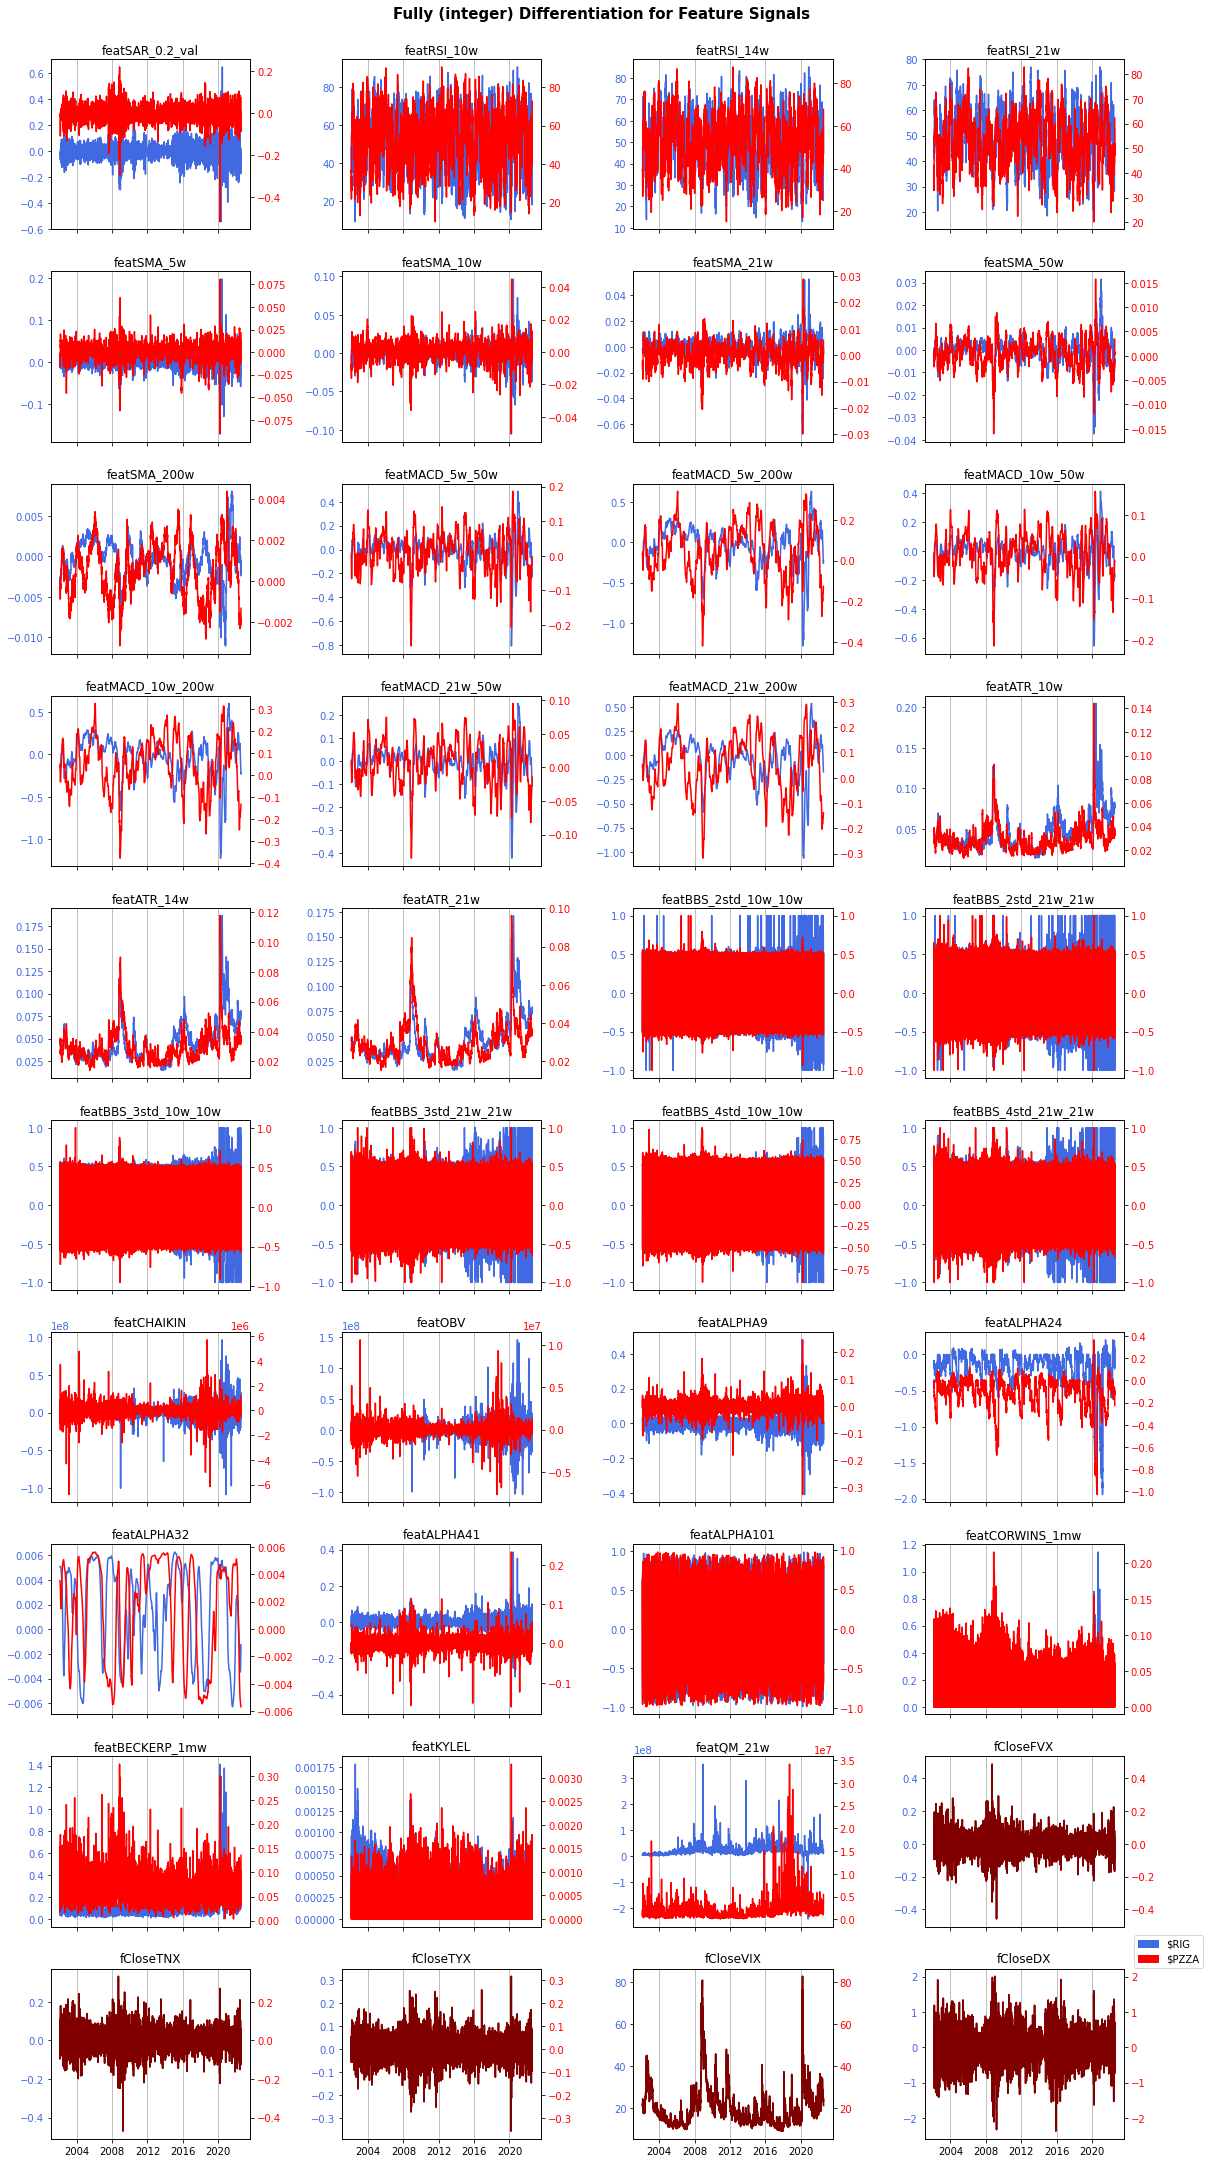

In [76]:
# plot again features signal database to understand integer differentiation 
# plot features signal database
fig, axes = plt.subplots(figsize=(17,30), nrows=10, ncols=4, sharex=True)
for c, ax1 in zip(featdf1, axes.flatten()):
    colorA1, colorA2 = 'royalblue', 'red'
    if "fClose" in c: colorA1, colorA2 ="maroon", "maroon"
    ax2 = ax1.twinx()
    ax1.plot(featdf1[c], color=colorA1)
    ax2.plot(featdf2[c], color=colorA2)    
    ax1.xaxis.grid(True)
    ax2.xaxis.grid(True)    
    ax1.set_title(f'{c}', fontweight='medium')
    ax1.tick_params(axis="y", labelcolor='royalblue')
    ax2.tick_params(axis="y", labelcolor='red')
legAsset1 = mpatches.Patch(color='royalblue', label='$RIG')
legAsset2 = mpatches.Patch(color='red', label='$PZZA')
fig.suptitle('Fully (integer) Differentiation for Feature Signals',
             fontweight ="bold", y=1+1e-4, fontsize=15)
plt.legend(handles=[legAsset1, legAsset2], bbox_to_anchor=(1.05, 1.2), loc='upper left', borderaxespad=0)
plt.tight_layout() 
plt.show()

##### 2.4.2.1. Definition of subsets of features (for parameter selection)

In [77]:
# find a list that contains the categories of all the features
featuresCat = np.unique([''.join(filter(lambda c: c.isupper(), col)) for col in featdf1.columns])
featuresCat

array(['ALPHA', 'ATR', 'BBS', 'BECKERP', 'CDX', 'CFVX', 'CHAIKIN',
       'CORWINS', 'CTNX', 'CTYX', 'CVIX', 'KYLEL', 'MACD', 'OBV', 'QM',
       'RSI', 'SAR', 'SMA'], dtype='<U7')

**a. Fully differentiated features**

In [78]:
# group features based on similar category for asset 1 (not considering 'ALPHA's cause' they are different though)
subfeatlist1 = [featdf1.filter(regex=category) for category in featuresCat[1:]]

# group features based on similar category for asset 2
subfeatlist2 = [featdf2.filter(regex=category) for category in featuresCat[1:]]

In [79]:
# select features that comes from the same category (except ALPHA's cause' they are different though)
subfeatCatdf1 = [dataset for dataset in subfeatlist1 if dataset.shape[1]>1]
subfeatCatdf2 = [dataset for dataset in subfeatlist2 if dataset.shape[1]>1]

**b. Fractional differentiated features**

In [80]:
# group features based on similar category for asset 1 (not considering 'ALPHA's cause' they are different though)
subfdfeatlist1 = [fdfeatdf1.filter(regex=category) for category in featuresCat[1:]]

# group features based on similar category for asset 2
subfdfeatlist2 = [fdfeatdf2.filter(regex=category) for category in featuresCat[1:]]

In [81]:
# select features that comes from the same category (except ALPHA's cause' they are different though)
subfdfeatCatdf1 = [dataset for dataset in subfdfeatlist1 if dataset.shape[1]>1]
subfdfeatCatdf2 = [dataset for dataset in subfdfeatlist2 if dataset.shape[1]>1]

#### 2.4.3. Parameter Reduction using Single Feature Importance method (SFI)

In [82]:
# definition of base naive estimator
base_estimator = RandomForestClassifier(n_estimators=25, random_state=42)

# base color list for SFI plotting
colorList = [
    ("rosybrown", "indianred"), 
    ("bisque", "orange"), 
    ("limegreen", "darkgreen"), 
    ("lightpink", "hotpink"), 
    ("cyan", "darkcyan")
]

##### 2.4.3.1. Fully differentiated features

In [83]:
# computing SFI for both assets (this process should take < 2 minutes)
n_splits = 10
sfi_featasset1, sfi_featasset2 = [], [] 
for subDfAsset1, subDfAsset2 in zip(subfeatCatdf1, subfeatCatdf2):
    sfi_featasset1.append(SFI_CQF(base_estimator, subDfAsset1, labelAsset1.dropna(), n_splits))
    sfi_featasset2.append(SFI_CQF(base_estimator, subDfAsset2, labelAsset1.dropna(), n_splits))

SFI | Processing - featATR_21w: 100%|████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]
SFI | Processing - featATR_21w: 100%|████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]
SFI | Processing - featBBS_4std_21w_21w: 100%|███████████████████████████████████████████| 6/6 [00:06<00:00,  1.04s/it]
SFI | Processing - featBBS_4std_21w_21w: 100%|███████████████████████████████████████████| 6/6 [00:05<00:00,  1.03it/s]
SFI | Processing - featMACD_21w_200w: 100%|██████████████████████████████████████████████| 6/6 [00:06<00:00,  1.05s/it]
SFI | Processing - featMACD_21w_200w: 100%|██████████████████████████████████████████████| 6/6 [00:05<00:00,  1.05it/s]
SFI | Processing - featRSI_21w: 100%|████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]
SFI | Processing - featRSI_21w: 100%|████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]
SFI | Processing - featSMA_200w: 100%|██

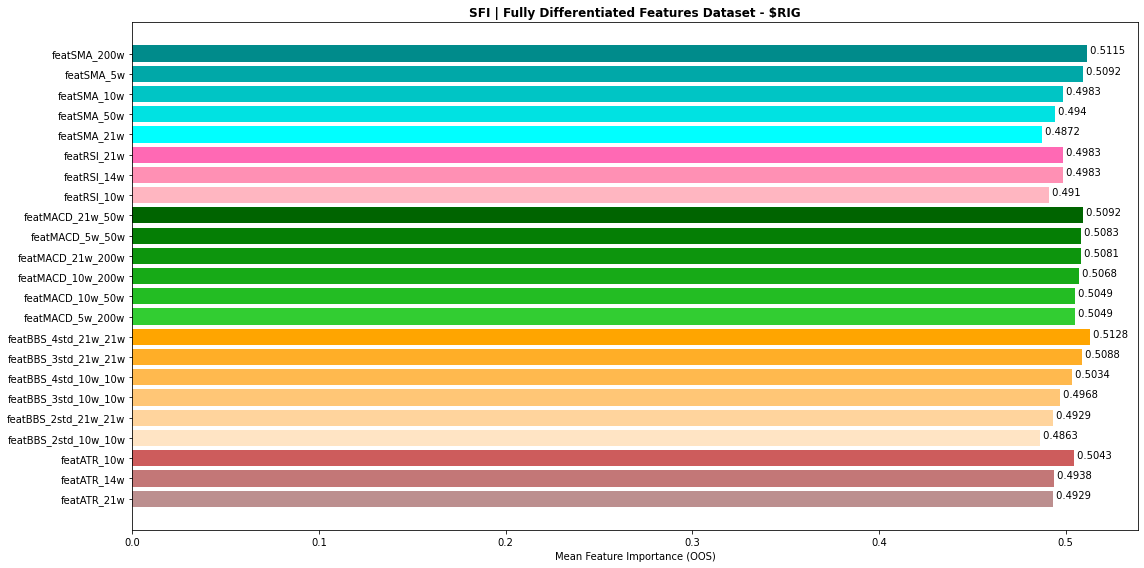

In [84]:
# plotting SFI results for asset 1
plt.figure(figsize=(16,8))
for idxCat, sfiAsset1 in enumerate(sfi_featasset1):
    _ = sfiAsset1[['meanImportance']].sort_values('meanImportance')
    pObj = plt.barh(
        _.index.values, _.meanImportance.values,
        color=[color.rgb for color in 
               list(Color(colorList[idxCat][0]).range_to(Color(colorList[idxCat][1]), sfiAsset1.shape[0]))
              ] 
    )
    for bar in pObj:
        width = bar.get_width()
        label_y = bar.get_y() + bar.get_height() / 2
        plt.text(width, label_y, s=f' {round(width,4)}')
plt.title("SFI | Fully Differentiated Features Dataset - $RIG", weight='semibold')
plt.xlabel('Mean Feature Importance (OOS)')
plt.tight_layout()
plt.show()

In [85]:
# selection of features with the highest SFI for Asset 1 based on previous result
selectedFeat1 = [featDfCat[['meanImportance']].sort_values('meanImportance').index[-1] for featDfCat in sfi_featasset1] 
print(" :::>>> Features por Asset 1:", selectedFeat1)

 :::>>> Features por Asset 1: ['featATR_10w', 'featBBS_4std_21w_21w', 'featMACD_21w_50w', 'featRSI_21w', 'featSMA_200w']


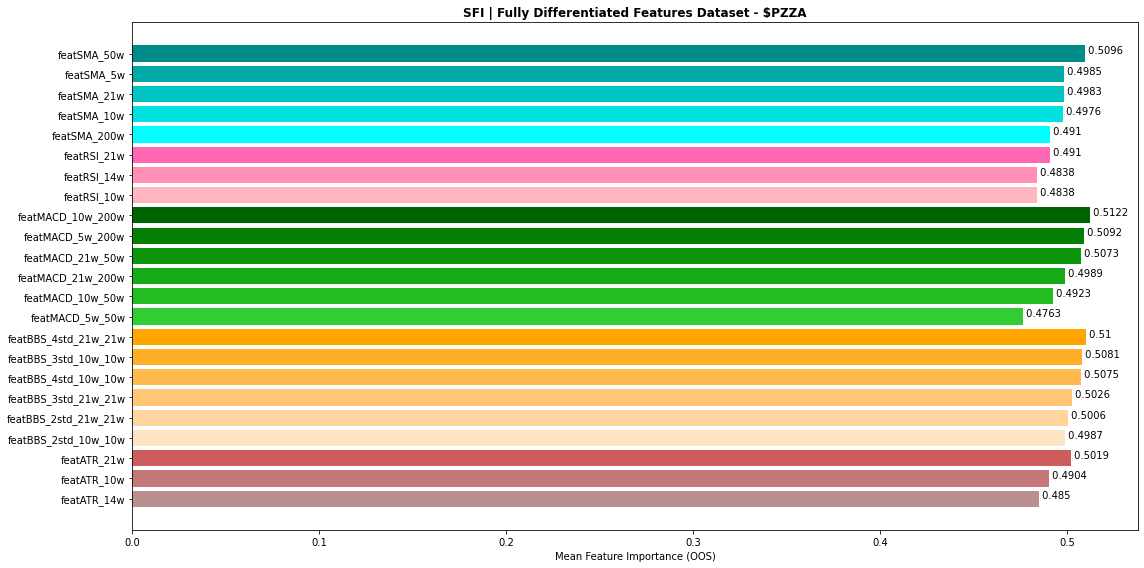

In [86]:
# plotting SFI results for asset 2
plt.figure(figsize=(16,8))
for idxCat, sfiAsset2 in enumerate(sfi_featasset2):
    _ = sfiAsset2[['meanImportance']].sort_values('meanImportance')
    pObj=plt.barh(
        _.index.values, _.meanImportance.values,
        color=[color.rgb for color in 
               list(Color(colorList[idxCat][0]).range_to(Color(colorList[idxCat][1]), sfiAsset2.shape[0]))
              ] 
    )
    for bar in pObj:
        width = bar.get_width()
        label_y = bar.get_y() + bar.get_height() / 2
        plt.text(width, label_y, s=f' {round(width,4)}')
plt.title("SFI | Fully Differentiated Features Dataset - $PZZA", weight='semibold')
plt.xlabel('Mean Feature Importance (OOS)')
plt.tight_layout()
plt.show()

In [87]:
# selection of features with the highest SFI for Asset 1 based on previous result
selectedFeat2 = [featDfCat[['meanImportance']].sort_values('meanImportance').index[-1] for featDfCat in sfi_featasset2] 
print(" :::>>> Features por Asset 2:", selectedFeat2)

 :::>>> Features por Asset 2: ['featATR_21w', 'featBBS_4std_21w_21w', 'featMACD_10w_200w', 'featRSI_21w', 'featSMA_50w']


##### 2.4.3.2. Fractional differentiated features

In [88]:
# computing SFI for both assets (this process should take < 2 minutes)
n_splits = 10
sfi_featfdasset1, sfi_featfdasset2 = [], [] 
for subfdDfAsset1, subfdDfAsset2 in zip(subfdfeatCatdf1, subfdfeatCatdf2):
    sfi_featfdasset1.append(SFI_CQF(base_estimator, subfdDfAsset1, labelAsset1, n_splits))
    sfi_featfdasset2.append(SFI_CQF(base_estimator, subfdDfAsset2, labelAsset2, n_splits))

SFI | Processing - featATR_21w: 100%|████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]
SFI | Processing - featATR_21w: 100%|████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]
SFI | Processing - featBBS_4std_21w_21w: 100%|███████████████████████████████████████████| 6/6 [00:06<00:00,  1.06s/it]
SFI | Processing - featBBS_4std_21w_21w: 100%|███████████████████████████████████████████| 6/6 [00:06<00:00,  1.07s/it]
SFI | Processing - featMACD_21w_200w: 100%|██████████████████████████████████████████████| 6/6 [00:06<00:00,  1.06s/it]
SFI | Processing - featMACD_21w_200w: 100%|██████████████████████████████████████████████| 6/6 [00:06<00:00,  1.08s/it]
SFI | Processing - featRSI_21w: 100%|████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.05it/s]
SFI | Processing - featRSI_21w: 100%|████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]
SFI | Processing - featSMA_200w: 100%|██

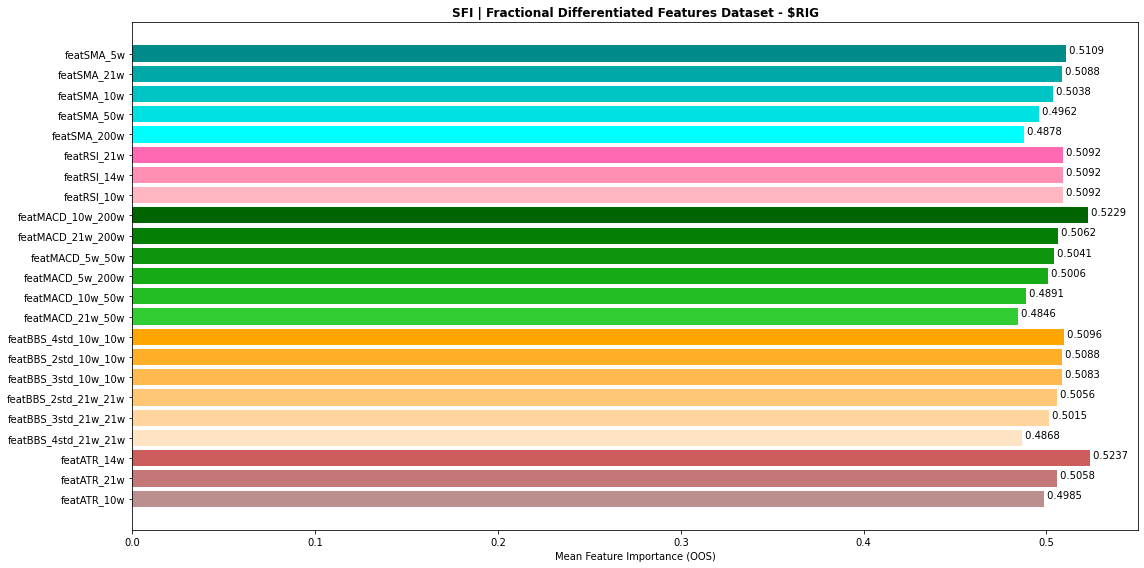

In [89]:
# plotting SFI results for asset 1 
plt.figure(figsize=(16,8))
for idxCat, sfiAsset1 in enumerate(sfi_featfdasset1):
    _ = sfiAsset1[['meanImportance']].sort_values('meanImportance')
    pObj = plt.barh(
        _.index.values, _.meanImportance.values,
        color=[color.rgb for color in 
               list(Color(colorList[idxCat][0]).range_to(Color(colorList[idxCat][1]), sfiAsset1.shape[0]))
              ] 
    )
    for bar in pObj:
        width = bar.get_width()
        label_y = bar.get_y() + bar.get_height() / 2
        plt.text(width, label_y, s=f' {round(width,4)}')
plt.title("SFI | Fractional Differentiated Features Dataset - $RIG", weight='semibold')
plt.xlabel('Mean Feature Importance (OOS)')
plt.tight_layout()
plt.show()

In [90]:
# selection of fractional features with the highest SFI for Asset 1 based on previous result
selectedfdFeat1 = \
[fdfeatDfCat[['meanImportance']].sort_values('meanImportance').index[-1] for fdfeatDfCat in sfi_featfdasset1] 
print(" :::>>> Features por Asset 1:", selectedfdFeat1)

 :::>>> Features por Asset 1: ['featATR_14w', 'featBBS_4std_10w_10w', 'featMACD_10w_200w', 'featRSI_21w', 'featSMA_5w']


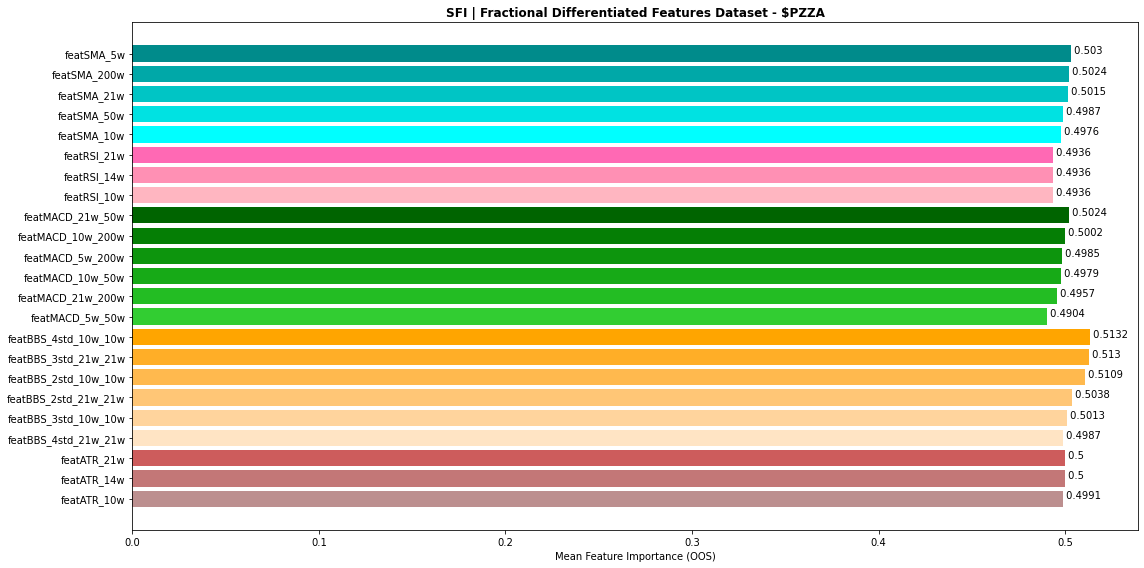

In [91]:
# plotting SFI results for asset 2
plt.figure(figsize=(16,8))
for idxCat, sfiAsset2 in enumerate(sfi_featfdasset2):
    _ = sfiAsset2[['meanImportance']].sort_values('meanImportance')
    pObj = plt.barh(
        _.index.values, _.meanImportance.values,
        color=[color.rgb for color in 
               list(Color(colorList[idxCat][0]).range_to(Color(colorList[idxCat][1]), sfiAsset2.shape[0]))
              ] 
    )
    for bar in pObj:
        width = bar.get_width()
        label_y = bar.get_y() + bar.get_height() / 2
        plt.text(width, label_y, s=f' {round(width,4)}')
plt.title("SFI | Fractional Differentiated Features Dataset - $PZZA", weight='semibold')
plt.xlabel('Mean Feature Importance (OOS)')
plt.tight_layout()
plt.show()

In [92]:
# selection of fractional features with the highest SFI for Asset 1 based on previous result
selectedfdFeat2 = \
[fdfeatDfCat[['meanImportance']].sort_values('meanImportance').index[-1] for fdfeatDfCat in sfi_featfdasset2] 
print(" :::>>> Features por Asset 2:", selectedfdFeat2)

 :::>>> Features por Asset 2: ['featATR_21w', 'featBBS_4std_10w_10w', 'featMACD_21w_50w', 'featRSI_21w', 'featSMA_5w']


### Part II - Features Selection

K-Means and Self-Organized Maps (SOM)

In [93]:
# general features tested for both assets and both types of features dataset
testingFeaturesUniverse = list(itertools.chain.from_iterable([data.columns for data in subfeatCatdf1]))

In [94]:
# selection of reduced dataset for both assets and both type of features
featsetdf1 = featdf1[featdf1.columns.difference(set(testingFeaturesUniverse) ^ set(selectedFeat1))]
featsetdf2 = featdf2[featdf2.columns.difference(set(testingFeaturesUniverse) ^ set(selectedFeat2))]

fdfeatsetdf1 = fdfeatdf1[fdfeatdf1.columns.difference(set(testingFeaturesUniverse) ^ set(selectedfdFeat1))]
fdfeatsetdf2 = fdfeatdf2[fdfeatdf2.columns.difference(set(testingFeaturesUniverse) ^ set(selectedfdFeat2))]

In [95]:
# definition of base dictionary containing features dataset for both assets
orgfeatdict, fdfeatdict = {'RIG': featsetdf1.T, 'PZZA': featsetdf2.T}, {'RIG': fdfeatsetdf1.T, 'PZZA': fdfeatsetdf2.T}

#### 2.4.4. K-Means Clustering

##### 2.4.4.1. Elbow Plot

In [96]:
# set general clusters to test
n_clusters = range(2,18)

**a. Fully Differentiated Features**

In [97]:
# computing Kmeans metrics
inertiaOrgFeat, silhouetteOrgFeat, OrgKMeansPerK = elbowKMeansIteration(orgfeatdict, n_clusters)

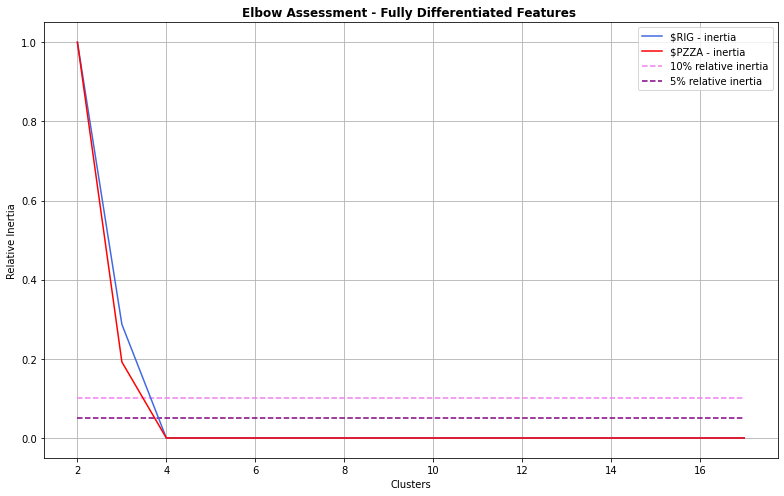

In [98]:
# elbow plot
fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)
plt.plot(n_clusters, np.divide(inertiaOrgFeat['RIG'], inertiaOrgFeat['RIG'][0]), color='royalblue')
plt.plot(n_clusters, np.divide(inertiaOrgFeat['PZZA'], inertiaOrgFeat['PZZA'][0]), color='red')
plt.hlines(0.1, n_clusters[0], n_clusters[-1], 'violet', linestyles='dashed')
plt.hlines(0.05, n_clusters[0], n_clusters[-1], 'purple', linestyles='dashed')
plt.title("Elbow Assessment - Fully Differentiated Features ", fontweight="semibold", fontsize=12)
plt.xlabel('Clusters', fontsize=10)
plt.ylabel('Relative Inertia', fontsize=10)
plt.legend(['$RIG - inertia', '$PZZA - inertia', '10% relative inertia', '5% relative inertia'])
plt.grid()
plt.tight_layout()
plt.show()

**b. Fractional Differentiated Features**

In [99]:
inertiaFdFeat, silhouetteFdFeat, fdKMeansPerK = elbowKMeansIteration(fdfeatdict, n_clusters)

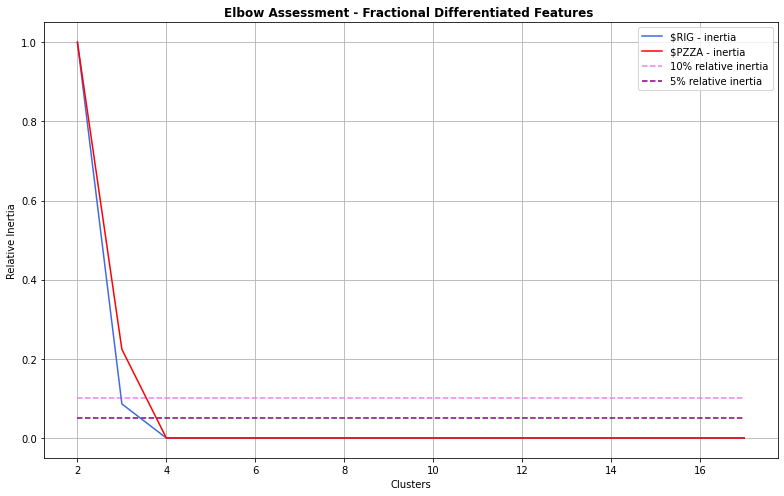

In [100]:
# ELBOW plot
fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)
plt.plot(n_clusters, np.divide(inertiaFdFeat['RIG'], inertiaFdFeat['RIG'][0]), color='royalblue')
plt.plot(n_clusters, np.divide(inertiaFdFeat['PZZA'], inertiaFdFeat['PZZA'][0]), color='red')
plt.hlines(0.1, n_clusters[0], n_clusters[-1], 'violet', linestyles='dashed')
plt.hlines(0.05, n_clusters[0], n_clusters[-1], 'purple', linestyles='dashed')
plt.title("Elbow Assessment - Fractional Differentiated Features ", fontweight="semibold", fontsize=12)
plt.xlabel('Clusters', fontsize=10)
plt.ylabel('Relative Inertia', fontsize=10)
plt.legend(['$RIG - inertia', '$PZZA - inertia', '10% relative inertia', '5% relative inertia'])
plt.grid()
plt.tight_layout()
plt.show()

##### 2.4.4.2. Silhouette Score Analysis

**a. Fully Differentiated Features**

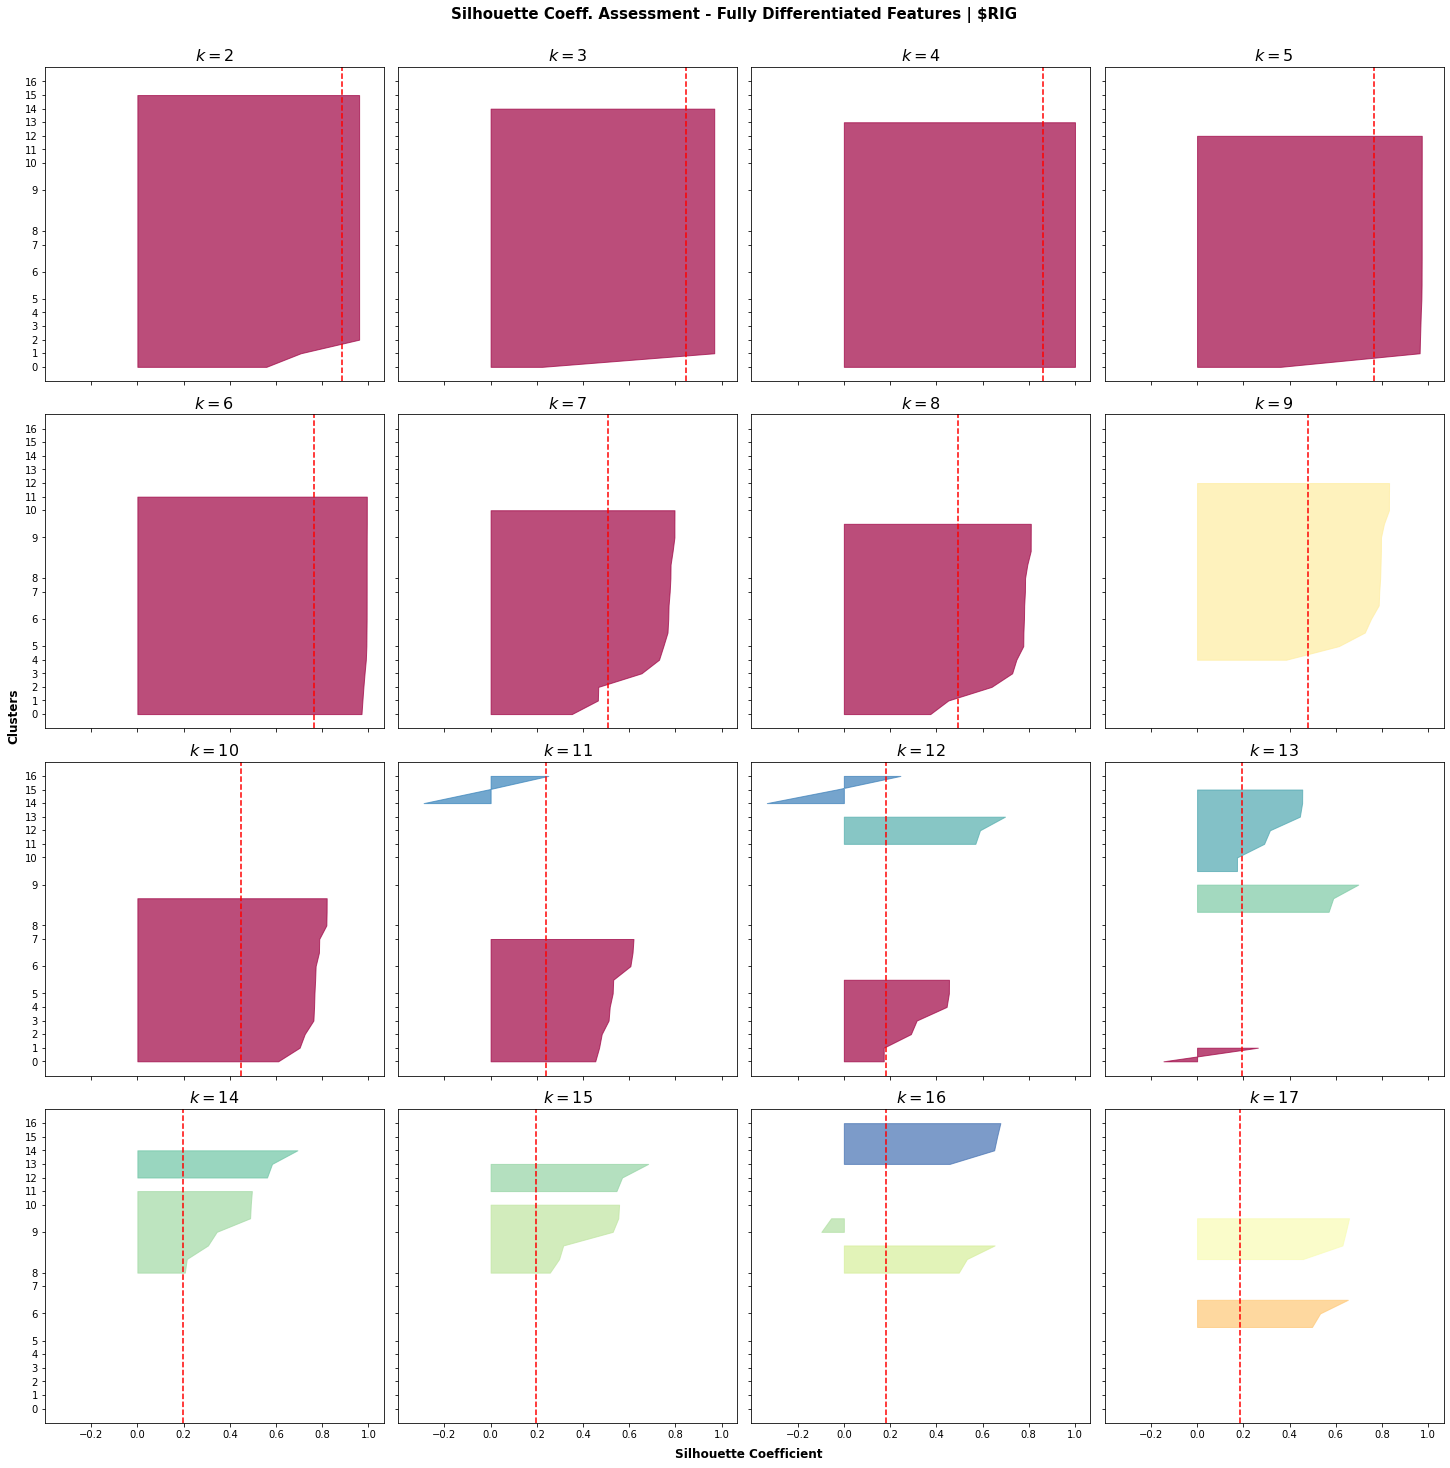

******************************************************************************************************************************


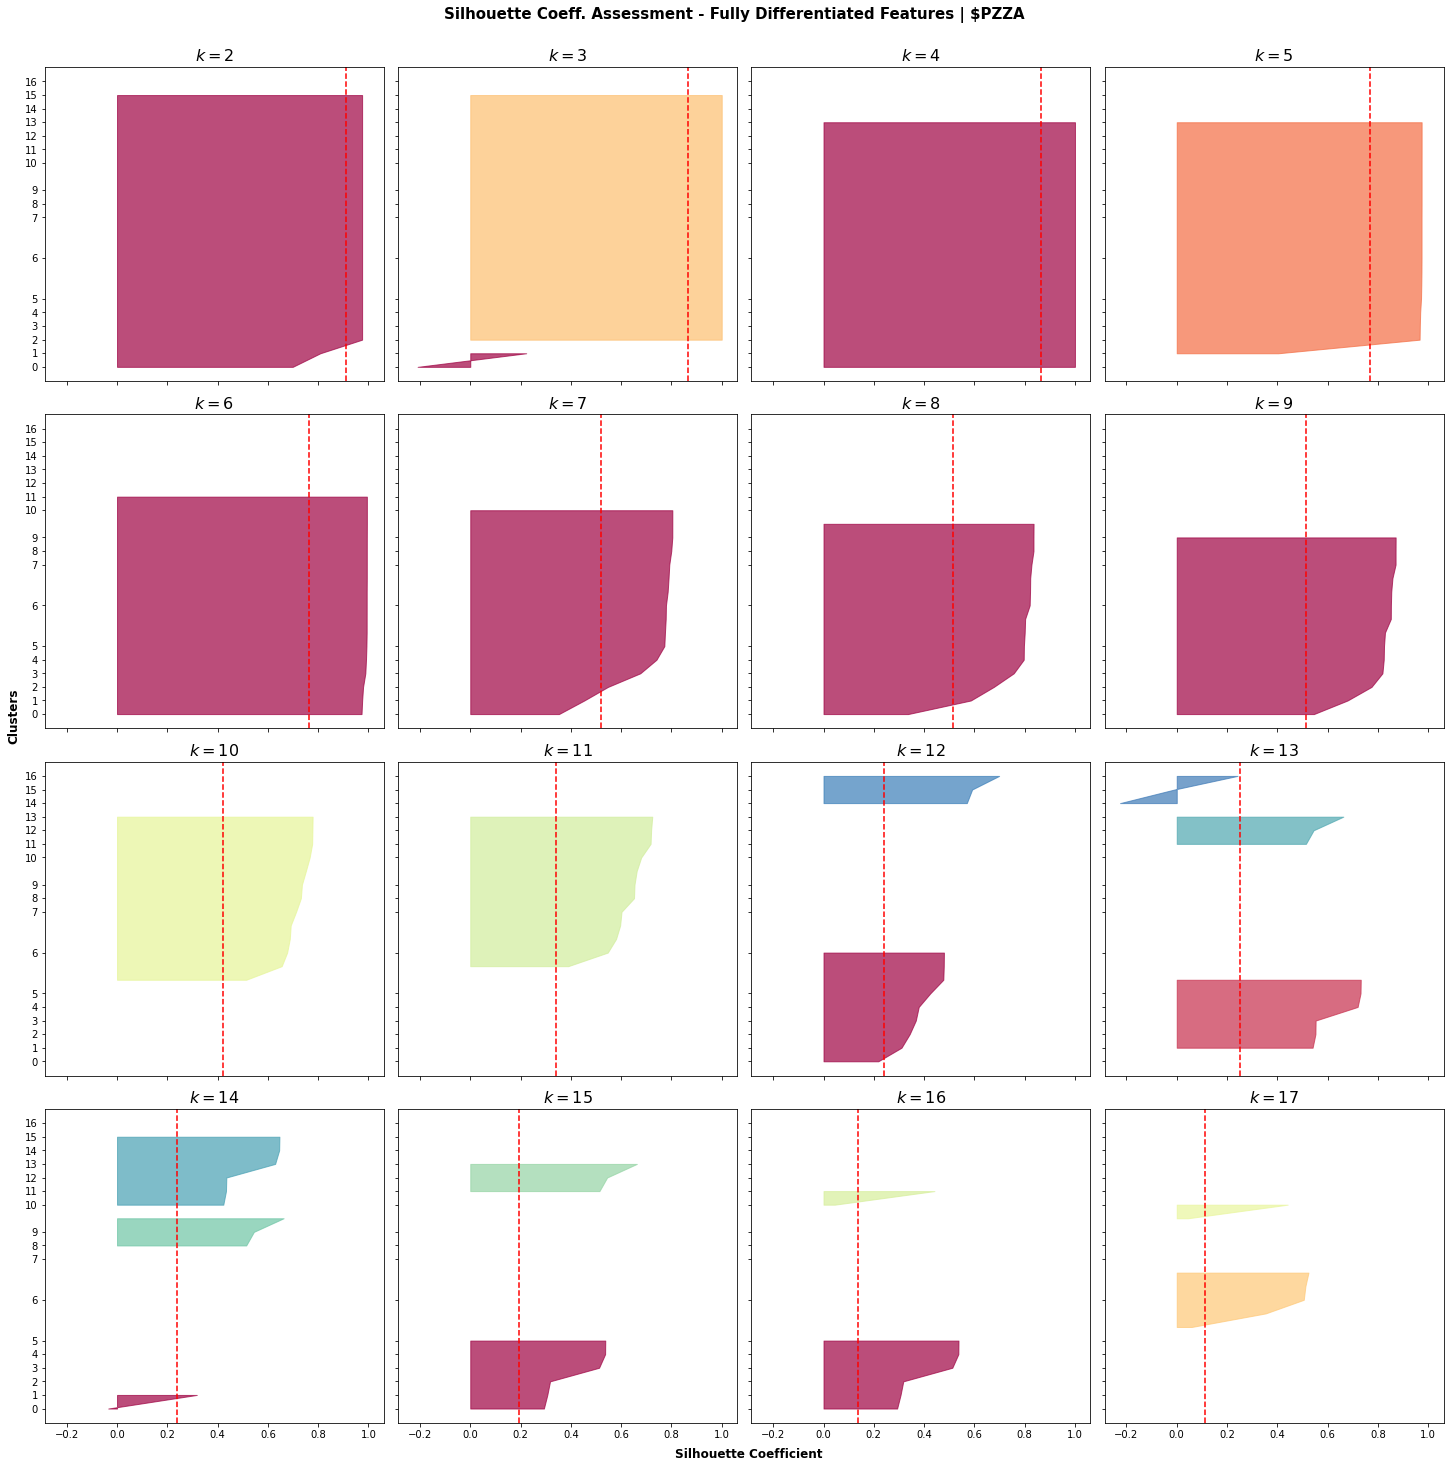

******************************************************************************************************************************


In [101]:
# plotting silhouette assessment
for assetName, silhouetteInfo in silhouetteOrgFeat.items():
    plotSilhouette(
        silhouette_scores = silhouetteInfo, 
        kmeans_per_k = OrgKMeansPerK[assetName], 
        X = orgfeatdict[assetName], 
        range_k = n_clusters, 
        name = "$"+assetName, 
        titleName = 'Fully Differentiated Features',
        plotdim=(4,4))
    print("***"*42)

In [102]:
# definition of K clusters for both assets based on the previous results
kA1, kA2 = 16, 15

**b. Fractional Differentiated Features**

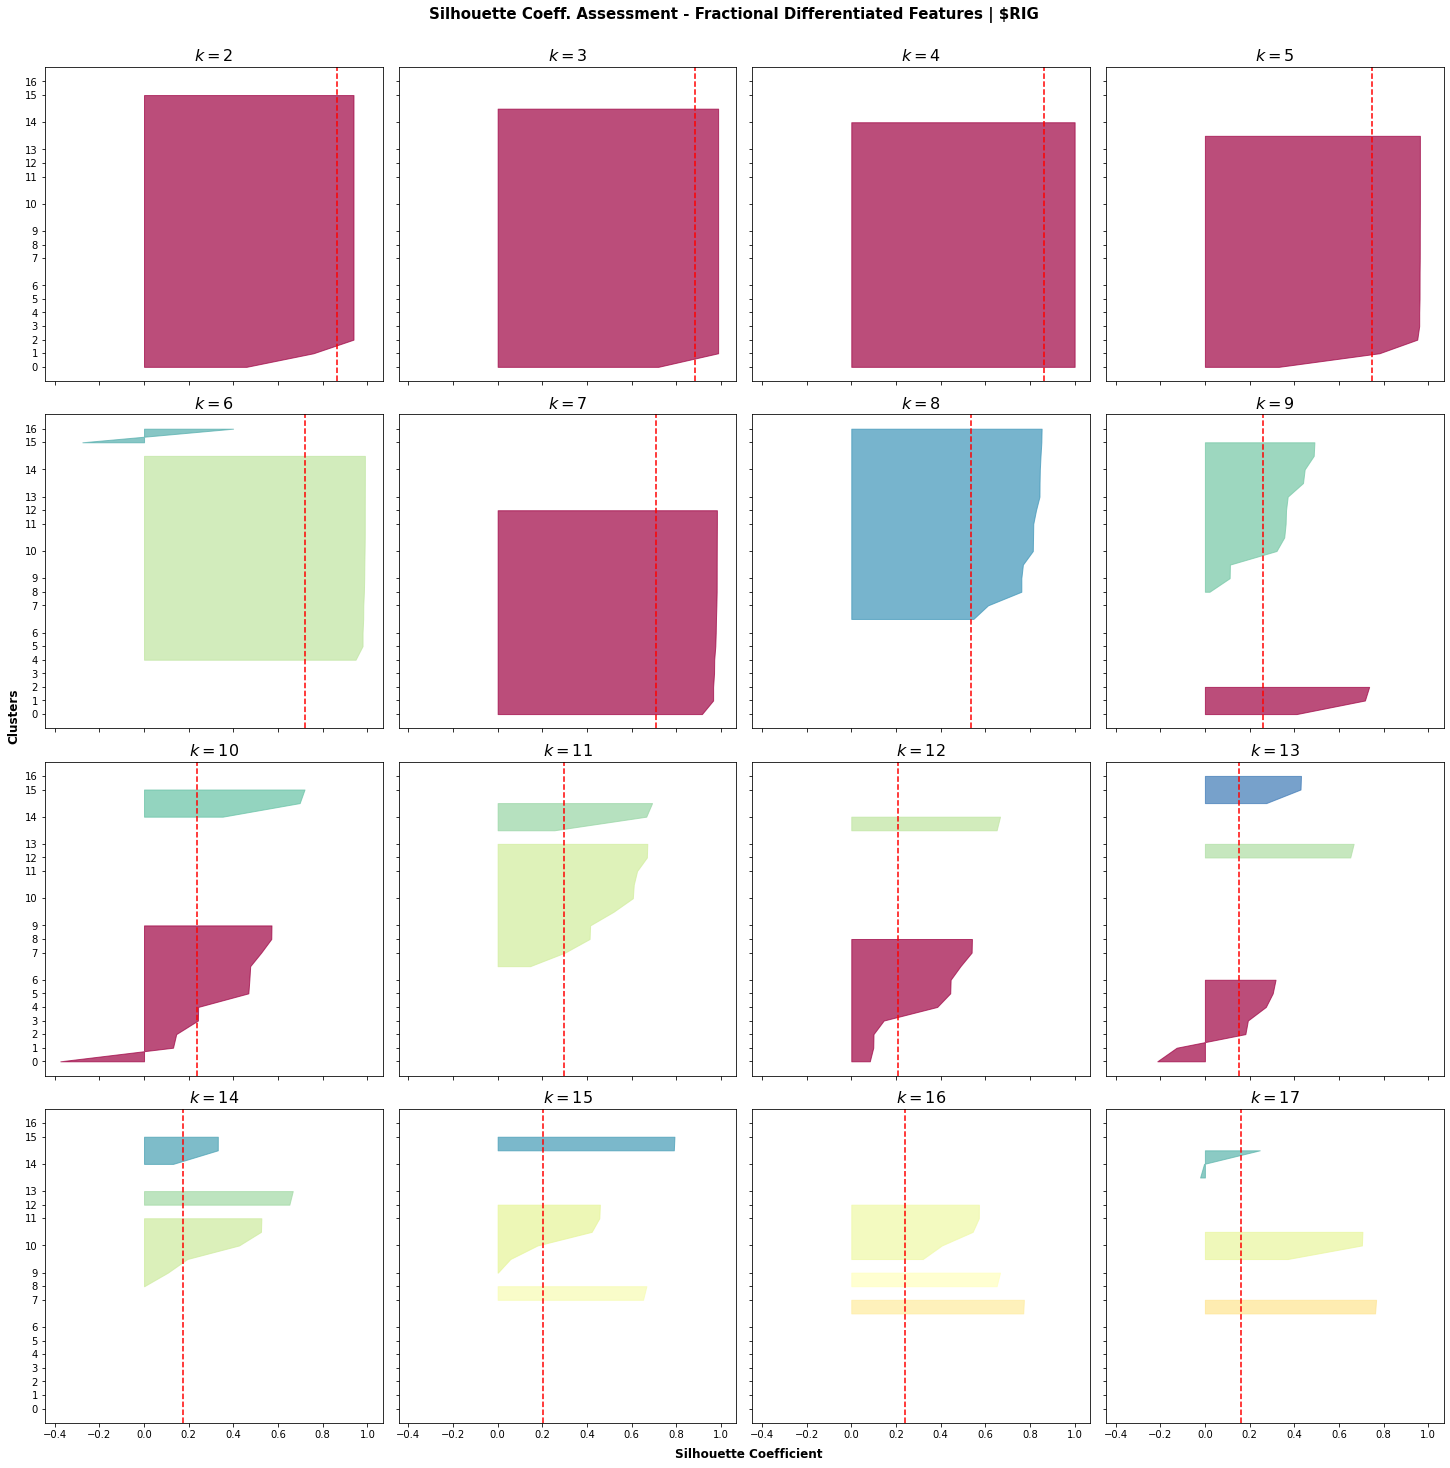

******************************************************************************************************************************


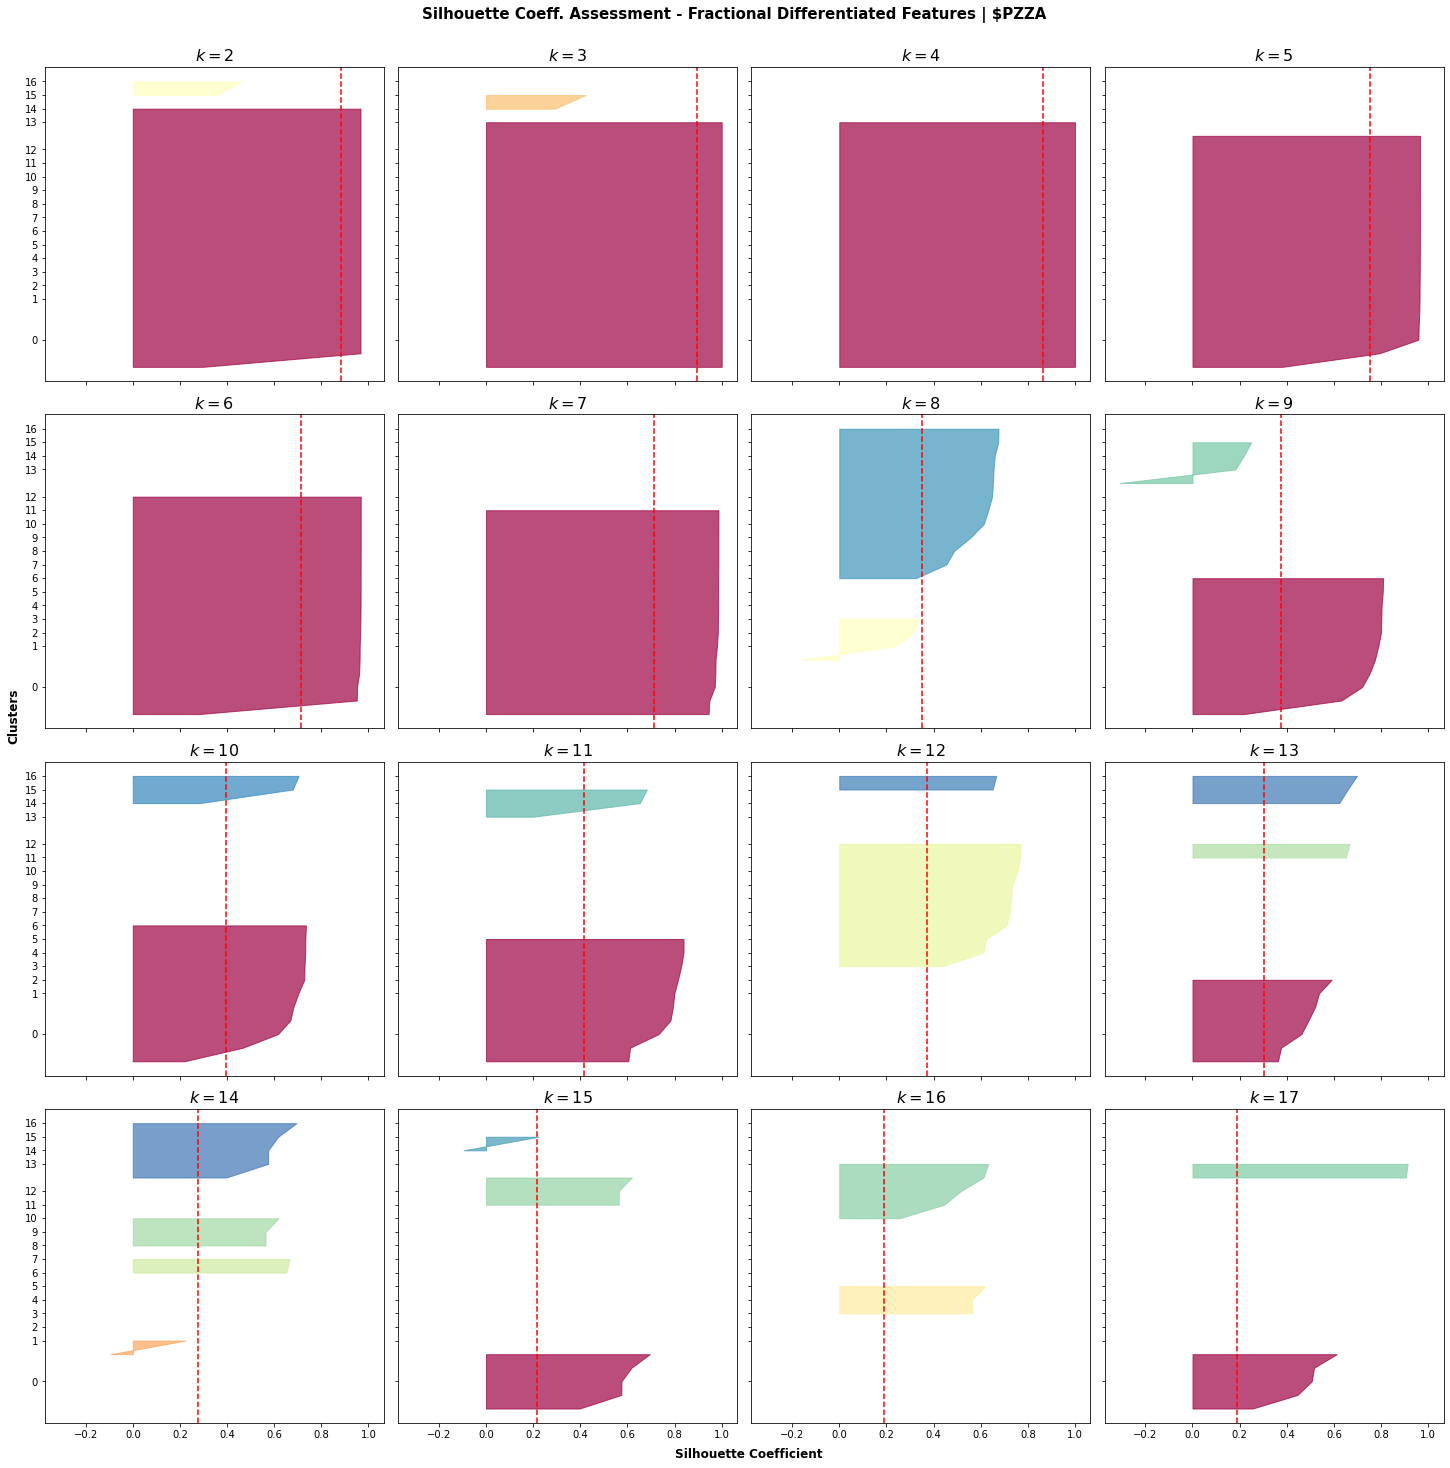

******************************************************************************************************************************


In [103]:
# plotting silhouette assessment
for assetName, silhouetteInfo in silhouetteFdFeat.items():
    plotSilhouette(
        silhouette_scores = silhouetteInfo, 
        kmeans_per_k = fdKMeansPerK[assetName], 
        X = fdfeatdict[assetName], 
        range_k = n_clusters, 
        name = "$"+assetName, 
        titleName = 'Fractional Differentiated Features',
        plotdim=(4,4))
    print("***"*42)

In [104]:
# definition of K clusters for both assets based on the previous results
fdkA1, fdkA2 = 11, 13

##### 2.4.4.3. K selection and K-means computation

In [105]:
# general pipeline function
def pipeworkflow(k_selected, X):
    # pipeline base workflow
    pipe = Pipeline([("normalization", MinMaxScaler()), ("cluster", KMeans(n_clusters=k_selected, random_state=55))])
    # pipeline fitting process
    pipe.fit(X)
    # return prediction (labels)
    return pipe.predict(X)

**a. Fully Differentiated Features**

In [106]:
# cluster info for fully diff. features of asset 1
labelsAsset1 = pipeworkflow(k_selected= kA1, X= orgfeatdict['RIG'])
dfClusterA1 = pd.DataFrame(
    {
        'Cluster': labelsAsset1, 
        'Feature': orgfeatdict['RIG'].index,
        'BaseFeature': orgfeatdict['RIG'].mean(axis=1)
    }
).sort_values(by=['Cluster'], axis = 0).reset_index(drop=True)

# cluster info for fully diff. features of asset 2
labelsAsset2 = pipeworkflow(k_selected= kA2, X= orgfeatdict['PZZA'])
dfClusterA2 = pd.DataFrame(
    {
        'Cluster': labelsAsset2, 
        'Feature': orgfeatdict['PZZA'].index,
        'BaseFeature': orgfeatdict['PZZA'].mean(axis=1)        
    }
).sort_values(by=['Cluster'], axis = 0).reset_index(drop=True)

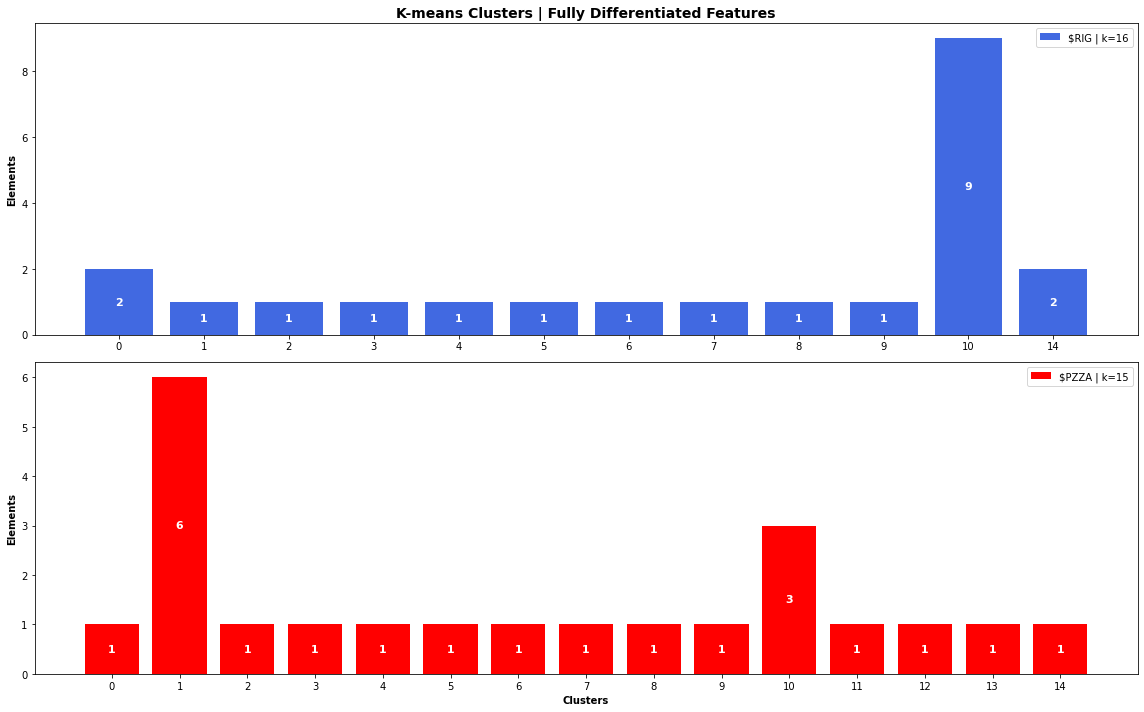

In [107]:
# asset1 object to plot
_A1Clusters = dfClusterA1.value_counts('Cluster').sort_index()
_A2Clusters = dfClusterA2.value_counts('Cluster').sort_index()

# plot clusters for asset 1
fig, axes = plt.subplots(figsize=(16,10), nrows=2, ncols=1)
pl1=axes[0].bar(
    [str(val) for val in _A1Clusters.index.values], 
    _A1Clusters.values, 
    color='royalblue'
)
axes[0].bar_label(pl1, label_type="center", fontweight='bold', fontsize=11, color='white')
axes[0].set_title("K-means Clusters | Fully Differentiated Features", fontweight='bold', fontsize=14)
axes[0].legend([f'$RIG | k={kA1}'])

# plot clusters for asset 1
pl2=axes[1].bar(
    [str(val) for val in _A2Clusters.index.values], 
    _A2Clusters.values, 
    color='red'
)
axes[1].bar_label(pl2, label_type="center", fontweight='bold', fontsize=11, color='white')
axes[1].legend([f'$PZZA | k={kA2}'])

# general setting elements for plot
axes[0].set_ylabel("Elements", fontweight='semibold')
axes[1].set_ylabel("Elements", fontweight='semibold')
axes[1].set_xlabel("Clusters", fontweight='semibold')
plt.tight_layout()
plt.show()

**b. Fractional Differentiated Features**

In [108]:
# cluster info for fully diff. features of asset 1
fdlabelsAsset1 = pipeworkflow(k_selected= fdkA1, X= fdfeatdict['RIG'])
fddfClusterA1 = pd.DataFrame(
    {
        'Cluster': fdlabelsAsset1, 
        'Feature': fdfeatdict['RIG'].index,
        'BaseFeature': fdfeatdict['RIG'].mean(axis=1)        
    }
).sort_values(by=['Cluster'], axis = 0).reset_index(drop=True)

# cluster info for fully diff. features of asset 2
fdlabelsAsset2 = pipeworkflow(k_selected= fdkA2, X= fdfeatdict['PZZA'])
fddfClusterA2 = pd.DataFrame(
    {
        'Cluster': fdlabelsAsset2, 
        'Feature': fdfeatdict['PZZA'].index,
        'BaseFeature': fdfeatdict['PZZA'].mean(axis=1)           
    }
).sort_values(by=['Cluster'], axis = 0).reset_index(drop=True)

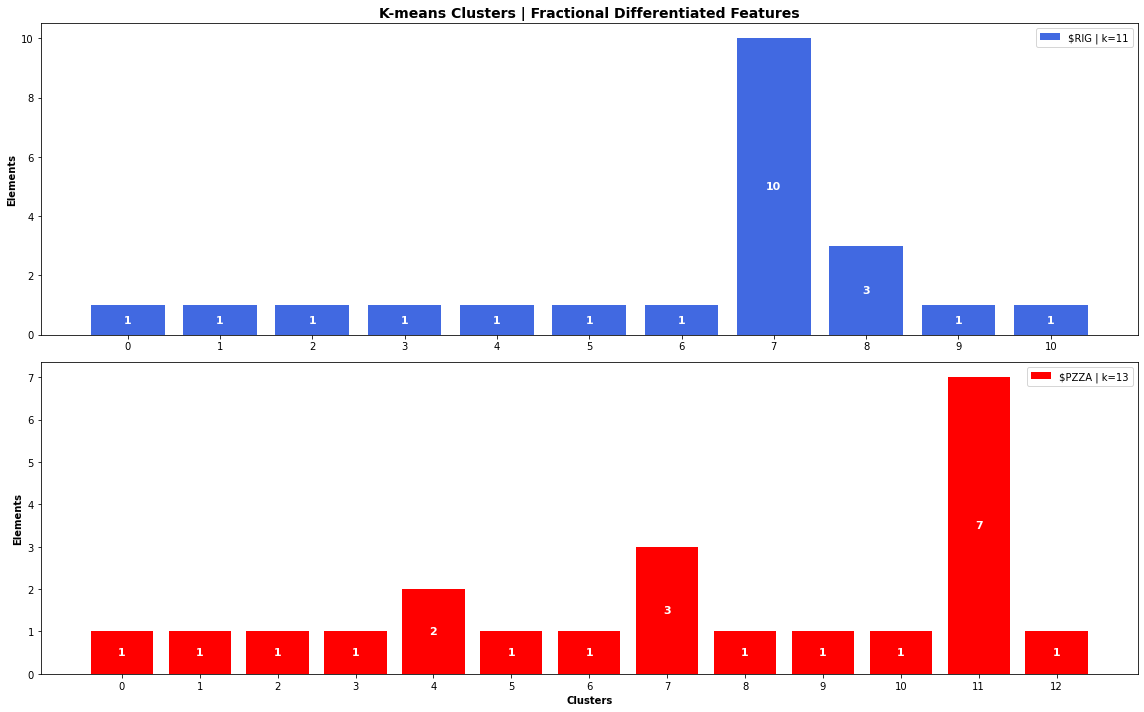

In [109]:
# asset1 object to plot
fd_A1Clusters = fddfClusterA1.value_counts('Cluster').sort_index()
fd_A2Clusters = fddfClusterA2.value_counts('Cluster').sort_index()

# plot clusters for asset 1
fig, axes = plt.subplots(figsize=(16,10), nrows=2, ncols=1)
pl1=axes[0].bar(
    [str(val) for val in fd_A1Clusters.index.values], 
    fd_A1Clusters.values, 
    color='royalblue'
)
axes[0].bar_label(pl1, label_type="center", fontweight='bold', fontsize=11, color='white')
axes[0].set_title("K-means Clusters | Fractional Differentiated Features", fontweight='bold', fontsize=14)
axes[0].legend([f'$RIG | k={fdkA1}'])

# plot clusters for asset 1
pl2=axes[1].bar(
    [str(val) for val in fd_A2Clusters.index.values], 
    fd_A2Clusters.values, 
    color='red'
)
axes[1].bar_label(pl2, label_type="center", fontweight='bold', fontsize=11, color='white')
axes[1].legend([f'$PZZA | k={fdkA2}'])

# general setting elements for plot
axes[0].set_ylabel("Elements", fontweight='semibold')
axes[1].set_ylabel("Elements", fontweight='semibold')
axes[1].set_xlabel("Clusters", fontweight='semibold')
plt.tight_layout()
plt.show()


#### 2.4.5. Self-Organized Map

In [110]:
# example of transposed features dataset for SOM analysis
dfClusterA2

Cluster               Feature   BaseFeature
0         0           featCHAIKIN  5.506628e+03
1         1           featSMA_50w  5.115981e-04
2         1             featKYLEL  3.500967e-04
3         1           featALPHA32  1.577818e-03
4         1           featALPHA41  3.163376e-04
5         1            featALPHA9 -5.432461e-04
6         1       featSAR_0.2_val  4.949712e-04
7         2            featQM_21w  1.795813e+06
8         3               featOBV  1.386338e+04
9         4           featRSI_21w  5.258493e+01
10        5             fCloseVIX  1.965646e+01
11        6  featBBS_4std_21w_21w -3.805265e-02
12        7          featALPHA101  1.603225e-02
13        8              fCloseDX -2.538328e-03
14        9           featALPHA24 -1.202139e-01
15       10             fCloseTYX -4.667185e-04
16       10             fCloseTNX -4.341161e-04
17       10             fCloseFVX -2.866291e-04
18       11     featMACD_10w_200w  5.211811e-02
19       12       featBECKERP_1mw  7.197504e-02
20       13       featCORWINS_1mw  3.608277e-02
21       14           featATR_21w  2.942104e-02

In [111]:
# rule of thumb for SOM network config. (same for all assets)
maxDSomMatrix = int(round(5 * np.sqrt(dfClusterA1.shape[0]), 0))
print(":::>>> Referential Min. Dimension for SOM NN :", maxDSomMatrix)

:::>>> Referential Min. Dimension for SOM NN : 23


##### 2.4.5.1. Fully Differentiated Features

 [  1558 / 10000 ]  16% - 0:00:00 left  [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.1085758652344367e-10
***********************************


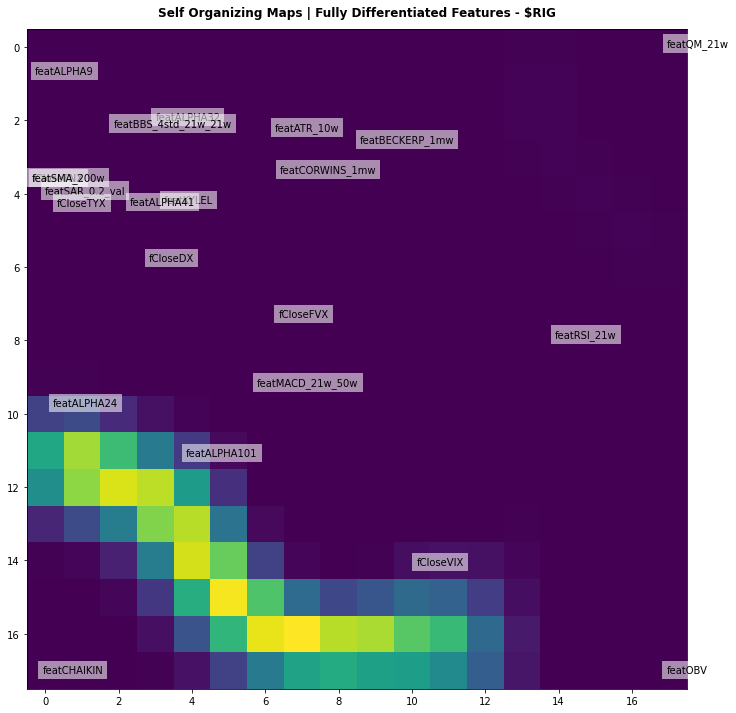

:::>>> SOM Automated Fully Diff. Features selected for Asset 1: ['featOBV', 'featBBS_4std_21w_21w']


In [112]:
# features asset 1 
finalFeatSel1 = somAnalysis(
    dfClusterA1[['BaseFeature']], 
    dfClusterA1.Feature, 
    nIter = 10000, 
    somDim=(18,18), 
    plot=True, nameTitle='Fully Differentiated Features - $RIG'
)
print(":::>>> SOM Automated Fully Diff. Features selected for Asset 1:", finalFeatSel1)

 [  1477 / 10000 ]  15% - 0:00:00 left  [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 2.966249741839718e-11
***********************************


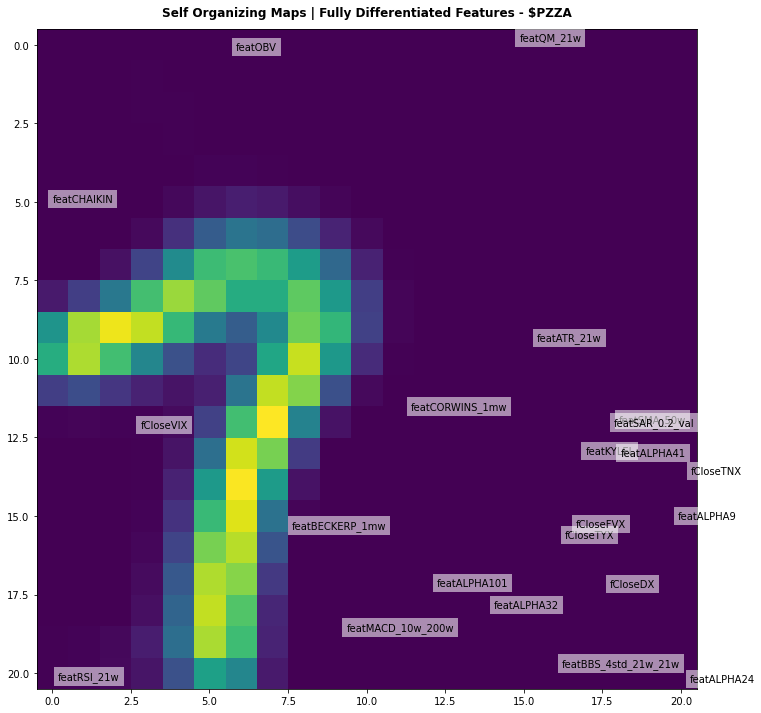

:::>>> SOM Automated Fully Diff. Features selected for Asset 2: ['featALPHA24', 'fCloseTYX']


In [113]:
# features asset 2
finalFeatSel2 = somAnalysis(
    dfClusterA2[['BaseFeature']], 
    dfClusterA2.Feature, 
    nIter = 10000, 
    somDim=(21,21), 
    plot=True, nameTitle='Fully Differentiated Features - $PZZA'
)
print(":::>>> SOM Automated Fully Diff. Features selected for Asset 2:", finalFeatSel2)

##### 2.4.5.2. Fractional Differentiated Features

 [  1613 / 10000 ]  16% - 0:00:00 left  [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.316430887586679e-09
***********************************


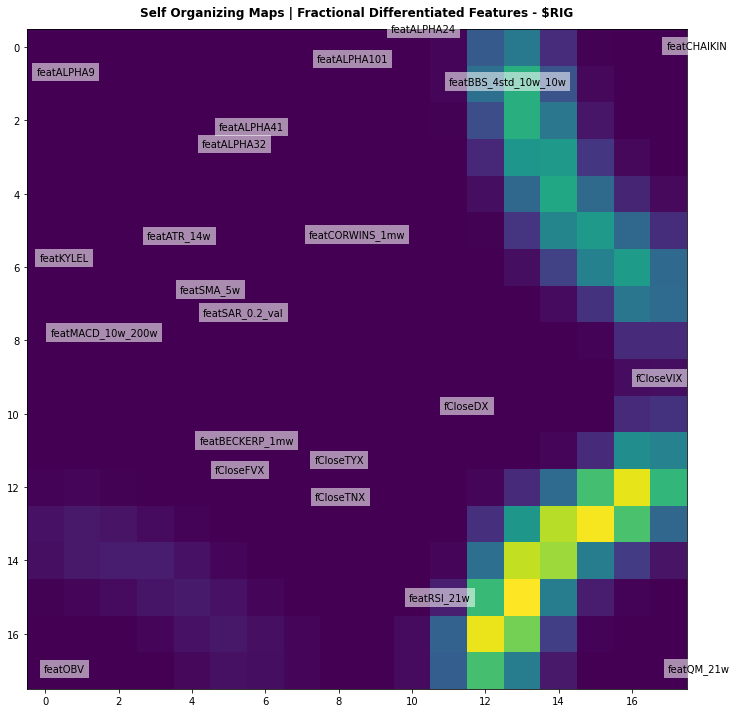

:::>>> SOM Automated Fractional Diff. Features for Asset 1: ['featQM_21w']


In [114]:
# features asset 1
fdfinalFeatSel1 = somAnalysis(
    fddfClusterA1[['BaseFeature']], 
    fddfClusterA1.Feature, 
    nIter = 10000, 
    somDim=(18,18), 
    plot=True, nameTitle='Fractional Differentiated Features - $RIG'
)
print(":::>>> SOM Automated Fractional Diff. Features for Asset 1:", fdfinalFeatSel1)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 9.512009386949477e-10
***********************************


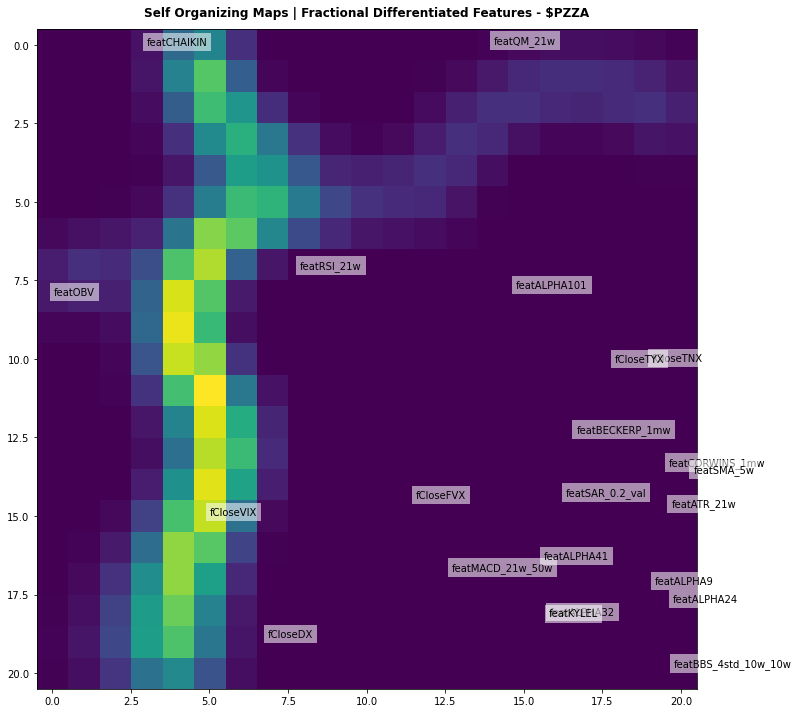

:::>>> SOM Automated Fractional Diff. Features for Asset 2: ['featBBS_4std_10w_10w', 'featALPHA41']


In [115]:
# features asset 2
fdfinalFeatSel2 = somAnalysis(
    fddfClusterA2[['BaseFeature']], 
    fddfClusterA2.Feature, 
    nIter = 10000, 
    somDim=(21,21),
    plot=True, nameTitle='Fractional Differentiated Features - $PZZA'
)
print(":::>>> SOM Automated Fractional Diff. Features for Asset 2:", fdfinalFeatSel2 )

Finally, in order to get a comparable set of universe of features for each asset, let's generate a global list of features for both of them. 

In [116]:
# features for asset 1
globalFeaturesAsset1 = list(set(finalFeatSel1) | set(fdfinalFeatSel1))
print(":::>>> Global set of features for Asset 1:", globalFeaturesAsset1)

:::>>> Global set of features for Asset 1: ['featOBV', 'featQM_21w', 'featBBS_4std_21w_21w']


In [117]:
# features for asset 2
globalFeaturesAsset2 = list(set(finalFeatSel2) | set(fdfinalFeatSel2))
print(":::>>> Global set of features for Asset 2:", globalFeaturesAsset2)

:::>>> Global set of features for Asset 2: ['featALPHA41', 'fCloseTYX', 'featBBS_4std_10w_10w', 'featALPHA24']


Using this global set of features for both assets, we are able now to start the Exploration Data Analysis.

### Part III - EDA

Exploratory Data Analysis (EDA)

In [118]:
# define global fully differentiated features set for asset 1 and asset 2
globalFeatSetdf1 = featdf1[globalFeaturesAsset1]
globalFeatSetdf2 = featdf2[globalFeaturesAsset2]

# define global fractional differentiated features set for asset 1 and asset 2
fdglobalFeatSetdf1 = fdfeatdf1[globalFeaturesAsset1]
fdglobalFeatSetdf2 = fdfeatdf2[globalFeaturesAsset2]

#### 2.4.6. Correlation Map

##### 2.4.6.1 Fully differentiated features

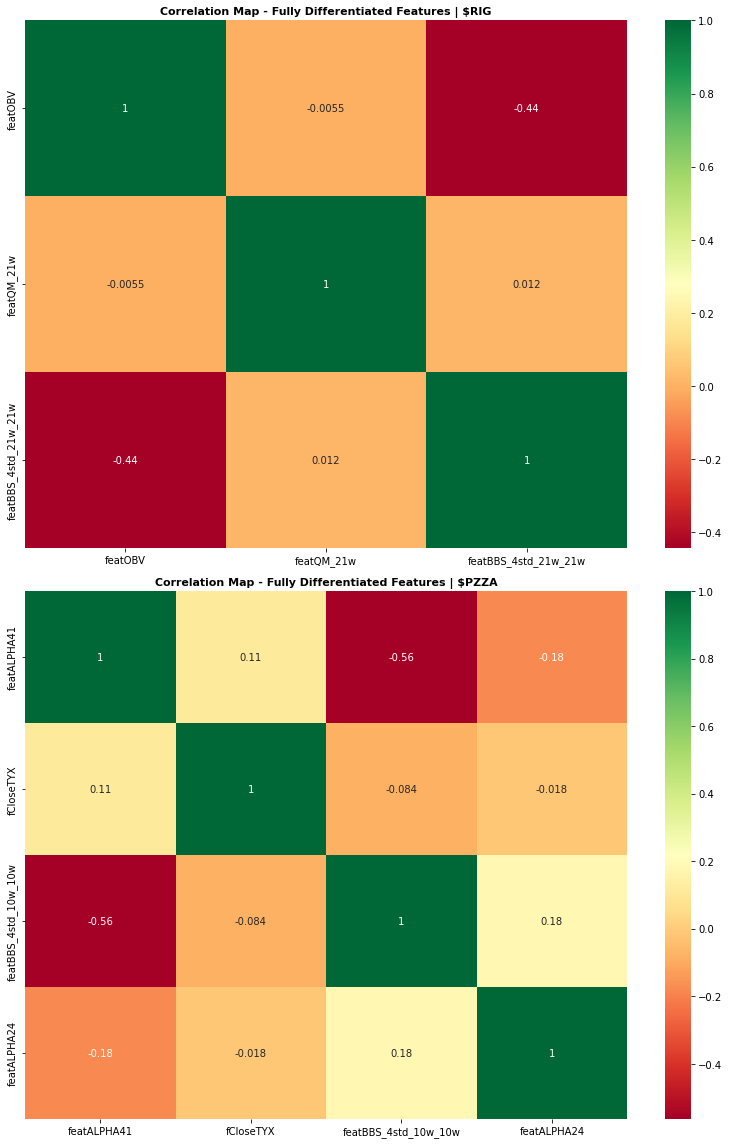

In [119]:
# plot correlation map for fully differentiated features of asset 1 and asset 2
fig, ax = plt.subplots(figsize=(11, 16), nrows=2, ncols=1)
sns.heatmap(globalFeatSetdf1.corr(),annot=True,cmap="RdYlGn", ax=ax[0])
sns.heatmap(globalFeatSetdf2.corr(),annot=True,cmap="RdYlGn", ax=ax[1])

ax[0].set_title('Correlation Map - Fully Differentiated Features | $RIG', 
          fontweight='semibold', fontsize=11)
ax[1].set_title('Correlation Map - Fully Differentiated Features | $PZZA', 
          fontweight='semibold', fontsize=11)
plt.tight_layout()
plt.show()

##### 2.4.6.2 Fractional differentiated features

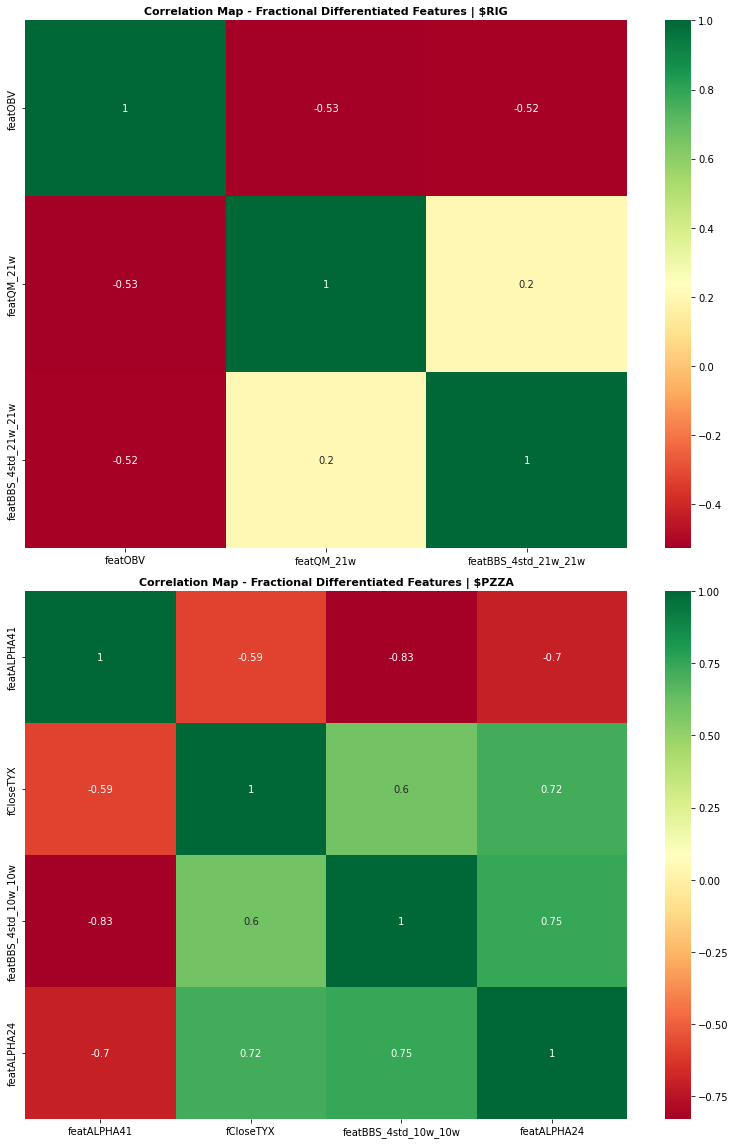

In [120]:
# plot correlation map for fully differentiated features of asset 1 and asset 2
fig, ax = plt.subplots(figsize=(11, 16), nrows=2, ncols=1)
sns.heatmap(fdglobalFeatSetdf1.corr(),annot=True,cmap="RdYlGn", ax=ax[0])
sns.heatmap(fdglobalFeatSetdf2.corr(),annot=True,cmap="RdYlGn", ax=ax[1])

ax[0].set_title('Correlation Map - Fractional Differentiated Features | $RIG', 
          fontweight='semibold', fontsize=11)
ax[1].set_title('Correlation Map - Fractional Differentiated Features | $PZZA', 
          fontweight='semibold', fontsize=11)
plt.tight_layout()
plt.show()

#### 2.4.7. Pairwise relationships (_pairplot_)

##### 2.4.7.1 Fully differentiated features

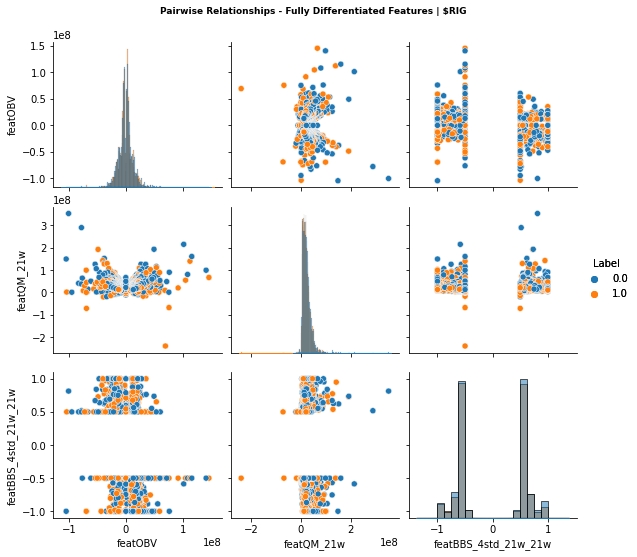

In [121]:
# asset 1 (this might take a couple of seconds...)
g=sns.pairplot(globalFeatSetdf1.join(labelAsset1).dropna(), hue = 'Label')
g.fig.suptitle("Pairwise Relationships - Fully Differentiated Features | $RIG", 
               y=1.025, fontweight='semibold', fontsize=9)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

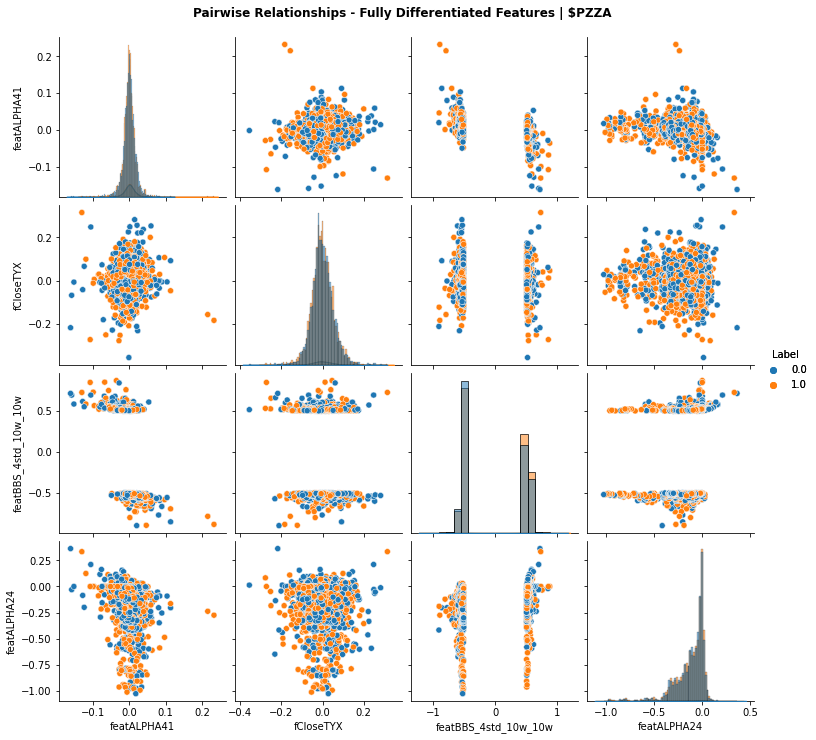

In [122]:
# asset 2 (this might take a couple of seconds...)
g= sns.pairplot(globalFeatSetdf2.join(labelAsset2).dropna(), hue = 'Label')
g.fig.suptitle("Pairwise Relationships - Fully Differentiated Features | $PZZA", 
               y=1.025, fontweight='semibold', fontsize=12)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

##### 2.4.7.2 Fully differentiated features

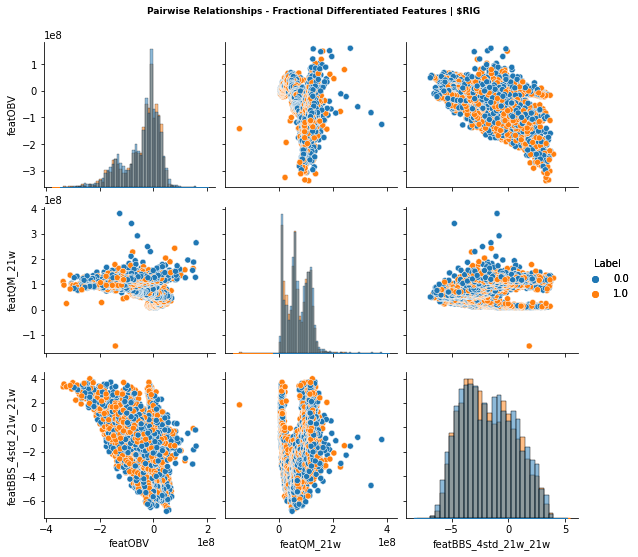

In [123]:
# asset 1
g=sns.pairplot(fdglobalFeatSetdf1.join(labelAsset1).dropna(), hue = 'Label')
g.fig.suptitle("Pairwise Relationships - Fractional Differentiated Features | $RIG", 
               y=1.025, fontweight='semibold', fontsize=9)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

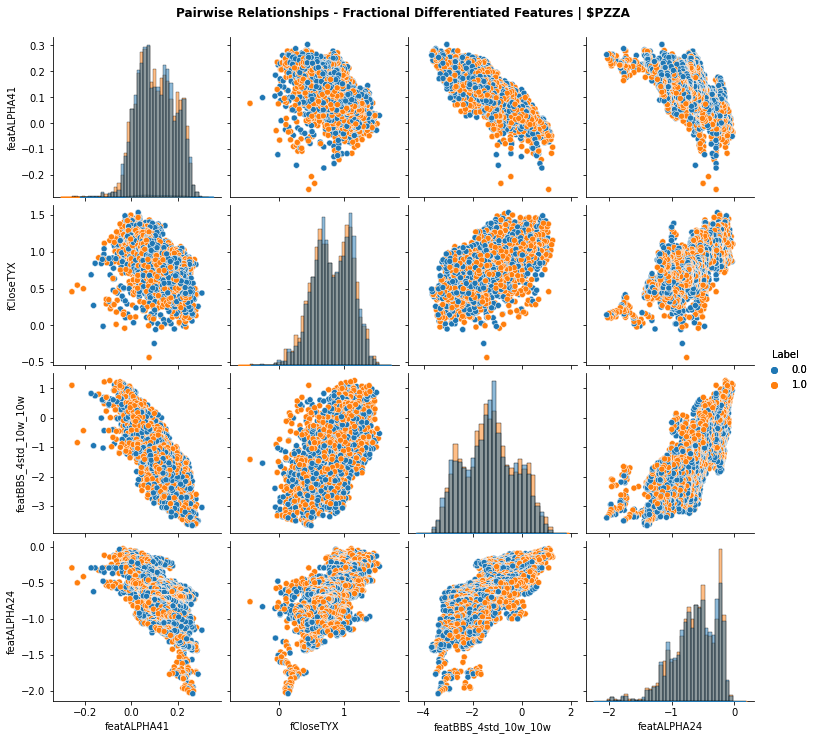

In [124]:
# asset 2
g= sns.pairplot(fdglobalFeatSetdf2.join(labelAsset2).dropna(), hue = 'Label')
g.fig.suptitle("Pairwise Relationships - Fractional Differentiated Features | $PZZA", 
               y=1.025, fontweight='semibold', fontsize=12)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

#### 2.4.8. Extra Trees Classifier (ETC) Asessment

Check if all features have an equivalente importance to preserve them (an IS feature importance procedure, different than the OOS SFI developed before).

In [125]:
# define a base dictionary of features per type and asset
assetFeaturesDict = {
    '$RIG':{'fullyDiff': globalFeatSetdf1, 'fracDiff':fdglobalFeatSetdf1}, 
    '$PZZA':{'fullyDiff': globalFeatSetdf2, 'fracDiff':fdglobalFeatSetdf2}
}

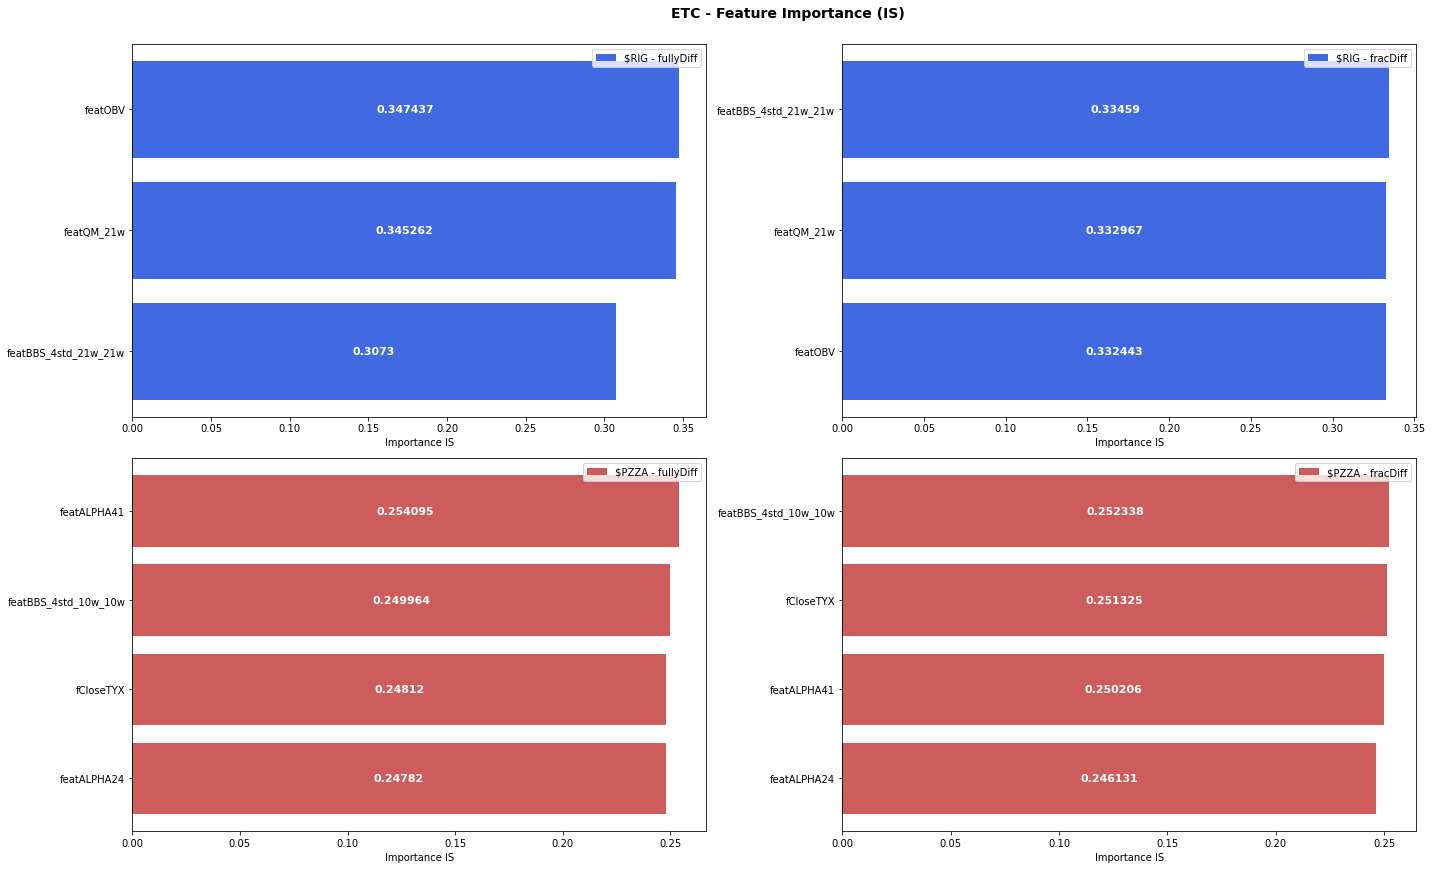

In [126]:
# plot ETC EVA
fig, axes = plt.subplots(figsize=(20, 12), nrows=2, ncols=2)
counterGen = 0
for assetName, featuresDfDict in assetFeaturesDict.items():
    subAx = axes[counterGen]
    if assetName == '$RIG': labels, colorSet = labelAsset1, 'royalblue'
    if assetName == '$PZZA': labels, colorSet = labelAsset2, 'indianred'
    subCounter = 0
    for typeFeature, featDataset in featuresDfDict.items():
        subPlotLoc = subAx[subCounter]
        _ = featDataset.join(labels).dropna()
        X = _.loc[:, _.columns != 'Label']
        y = _[['Label']]
        model = ExtraTreesClassifier()
        model.fit(X,y)
        impPdSeries = pd.Series(model.feature_importances_, index=X.columns).sort_values()
        impIs = subPlotLoc.barh(
            impPdSeries.index.values, impPdSeries.values, color=colorSet, label=f'{assetName} - {typeFeature}'
        ) 
        subPlotLoc.set_xlabel("Importance IS")
        subPlotLoc.bar_label(impIs, label_type="center", fontweight='bold', fontsize=11, color='white')      
        subPlotLoc.legend(handles=[impIs])
        subCounter+=1
    counterGen+=1
fig.suptitle('ETC - Feature Importance (IS)', fontweight='semibold', fontsize=14, x=0.55, y=1.0025)
plt.tight_layout()

## III. The experiment - LSTM

In [128]:
# defining general set of data for asset 1
gset1 = globalFeatSetdf1.join(labelAsset1).dropna()
fdgset1 = fdglobalFeatSetdf1.join(labelAsset1).dropna()
# defining general set of data for asset 2
gset2 = globalFeatSetdf2.join(labelAsset2).dropna()
fdgset2 = fdglobalFeatSetdf2.join(labelAsset2).dropna()

In [129]:
# define a global number of iterations for each stability testing
numberIterations = 15

### 3.1. Asset 1

#### 3.1.1. Trial #1

In [130]:
modelsA1, historiesA1, evasA1 = [], [], []
for times in tqdm(range(numberIterations), desc="LSTM | Iterative Testing process: "):
    modelA1, historyA1, evaA1 = \
    ExperimentLSTM(dataset=gset1, timestep=2).compute_LSTM(
        layers = 1,
        baseunits = 50, 
        unitsList = [0], 
        activationFunc = 'sigmoid',     
        optimizer = 'sgd',                    
        lossFunc = 'binary_crossentropy', 
        metricList = ['acc'],
        epochs = 30, 
        batch_size=45, 
        dropout = 0.0, 
        dropoutLayers = [0],
        validation_split = 0.25
    )
    modelsA1.append(modelA1)    
    historiesA1.append(historyA1)
    evasA1.append(evaA1) 

LSTM | Iterative Testing process: 100%|████████████████████████████████████████████████| 15/15 [01:07<00:00,  4.47s/it]


In [131]:
fdModelsA1, fdhistoriesA1, fdEvasA1 = [], [], []
for times in tqdm(range(numberIterations), desc="LSTM | Iterative Testing process: "):
    fdmodelA1, fdhistoryA1, fdevaA1 = \
    ExperimentLSTM(dataset=fdgset1, timestep=2).compute_LSTM(
        layers = 1,
        baseunits = 50, 
        unitsList = [0], 
        activationFunc = 'sigmoid',     
        optimizer = 'sgd',                    
        lossFunc = 'binary_crossentropy', 
        metricList = ['acc'],
        epochs = 30, 
        batch_size=45, 
        dropout = 0.0, 
        dropoutLayers = [0],
        validation_split = 0.25
    )
    fdModelsA1.append(fdmodelA1)
    fdhistoriesA1.append(fdhistoryA1)
    fdEvasA1.append(fdevaA1)

LSTM | Iterative Testing process: 100%|████████████████████████████████████████████████| 15/15 [01:06<00:00,  4.41s/it]


  (T1) $RIG | Fully vs. Frac  :::>>> Sample LSTM Model Configuration:

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': (...),
             'dtype': 'float32',
             'name': 'lstm_29_input',
             'ragged': False,
             'sparse': False}},
 {'class_name': 'LSTM',
  'config': {'activation': 'sigmoid',
             'activity_regularizer': None,
             'batch_input_shape': (...),
             'bias_constraint': None,
             'bias_initializer': {...},
             'bias_regularizer': None,
             'dropout': 0.0,
             'dtype': 'float32',
             'go_backwards': False,
             'implementation': 2,
             'kernel_constraint': None,
             'kernel_initializer': {...},
             'kernel_regularizer': None,
             'name': 'lstm_29',
             'recurrent_activation': 'sigmoid',
             'recurrent_constraint': None,
             'recurrent_dropout': 0.0,
             'recurrent_initializer': {...},


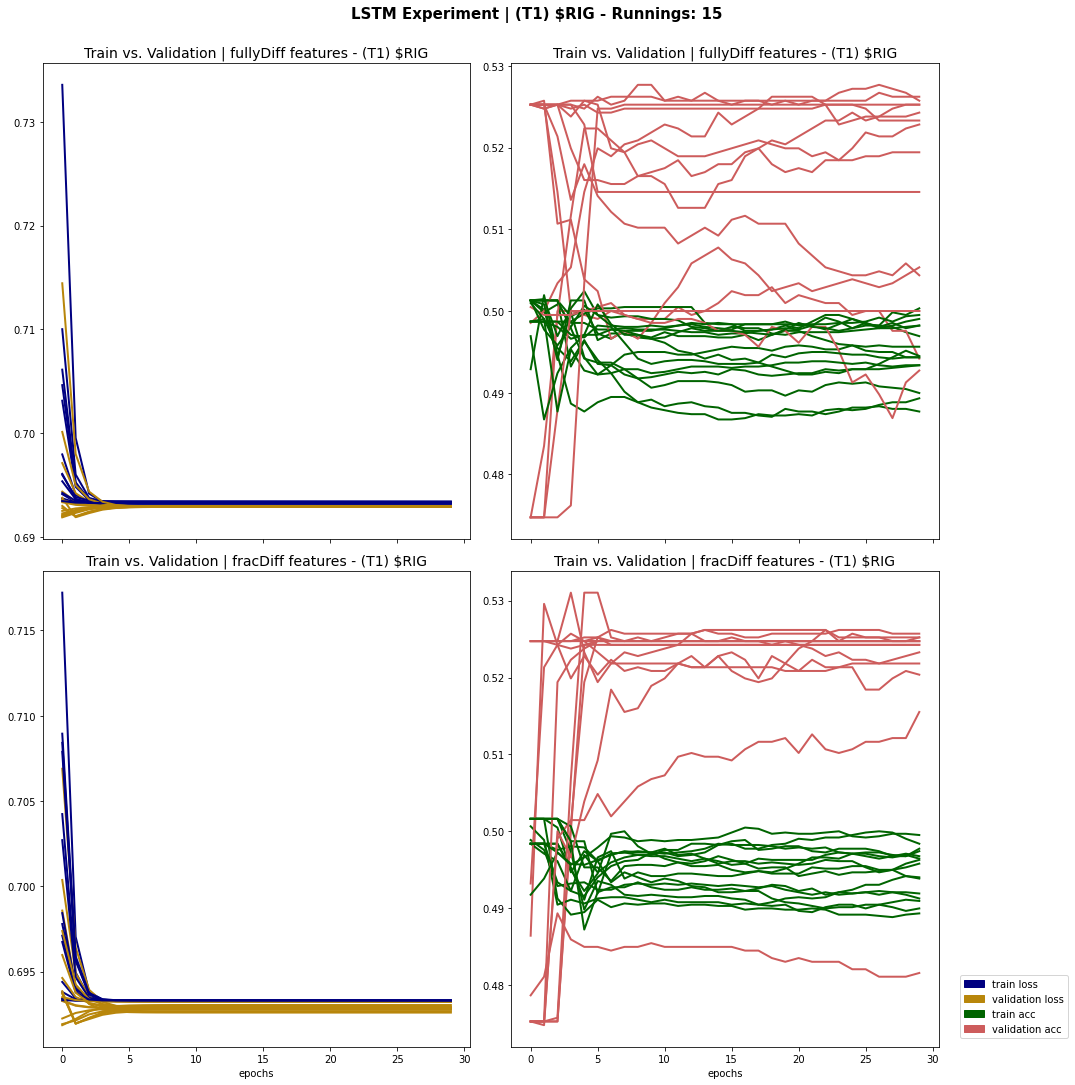

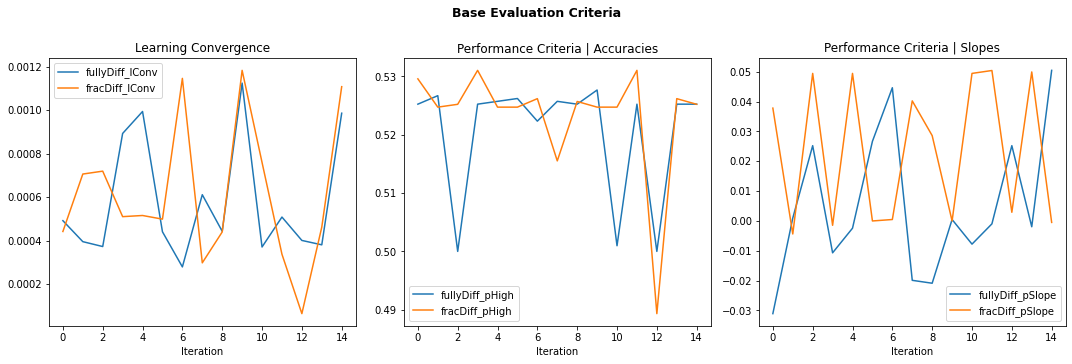

::::::>>> Stability Criteria Value | fullyDiff:  0.0002665099493310798
::::::>>> Stability Criteria Value | fracDiff:  0.00031482703425473967


In [132]:
comparissonLSTM('(T1) $RIG', numberIterations, {'fullyDiff': historiesA1, 'fracDiff': fdhistoriesA1}, fdmodelA1)

#### 3.1.2. Trial #2

In [133]:
modelsA1, historiesA1, evasA1 = [], [], []
for times in tqdm(range(numberIterations), desc="LSTM | Iterative Testing process: "):
    modelA1, historyA1, evaA1 = \
    ExperimentLSTM(dataset=gset1, timestep=3).compute_LSTM(
        layers = 1,
        baseunits = 25, 
        unitsList = [0], 
        activationFunc = 'sigmoid',     
        optimizer = 'sgd',                    
        lossFunc = 'binary_crossentropy', 
        metricList = ['acc'],
        epochs = 30, 
        batch_size=25, 
        dropout = 0.0, 
        dropoutLayers = [0],
        validation_split = 0.25
    )
    modelsA1.append(modelA1)    
    historiesA1.append(historyA1)
    evasA1.append(evaA1) 

LSTM | Iterative Testing process: 100%|████████████████████████████████████████████████| 15/15 [01:43<00:00,  6.93s/it]


In [134]:
fdModelsA1, fdhistoriesA1, fdEvasA1 = [], [], []
for times in tqdm(range(numberIterations), desc="LSTM | Iterative Testing process: "):
    fdmodelA1, fdhistoryA1, fdevaA1 = \
    ExperimentLSTM(dataset=fdgset1, timestep=3).compute_LSTM(
        layers = 1,
        baseunits = 25, 
        unitsList = [0], 
        activationFunc = 'sigmoid',     
        optimizer = 'sgd',                    
        lossFunc = 'binary_crossentropy', 
        metricList = ['acc'],
        epochs = 30, 
        batch_size=25, 
        dropout = 0.0, 
        dropoutLayers = [0],
        validation_split = 0.25
    )
    fdModelsA1.append(fdmodelA1)
    fdhistoriesA1.append(fdhistoryA1)
    fdEvasA1.append(fdevaA1)

LSTM | Iterative Testing process: 100%|████████████████████████████████████████████████| 15/15 [01:46<00:00,  7.09s/it]


  (T2) $RIG | Fully vs. Frac  :::>>> Sample LSTM Model Configuration:

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': (...),
             'dtype': 'float32',
             'name': 'lstm_59_input',
             'ragged': False,
             'sparse': False}},
 {'class_name': 'LSTM',
  'config': {'activation': 'sigmoid',
             'activity_regularizer': None,
             'batch_input_shape': (...),
             'bias_constraint': None,
             'bias_initializer': {...},
             'bias_regularizer': None,
             'dropout': 0.0,
             'dtype': 'float32',
             'go_backwards': False,
             'implementation': 2,
             'kernel_constraint': None,
             'kernel_initializer': {...},
             'kernel_regularizer': None,
             'name': 'lstm_59',
             'recurrent_activation': 'sigmoid',
             'recurrent_constraint': None,
             'recurrent_dropout': 0.0,
             'recurrent_initializer': {...},


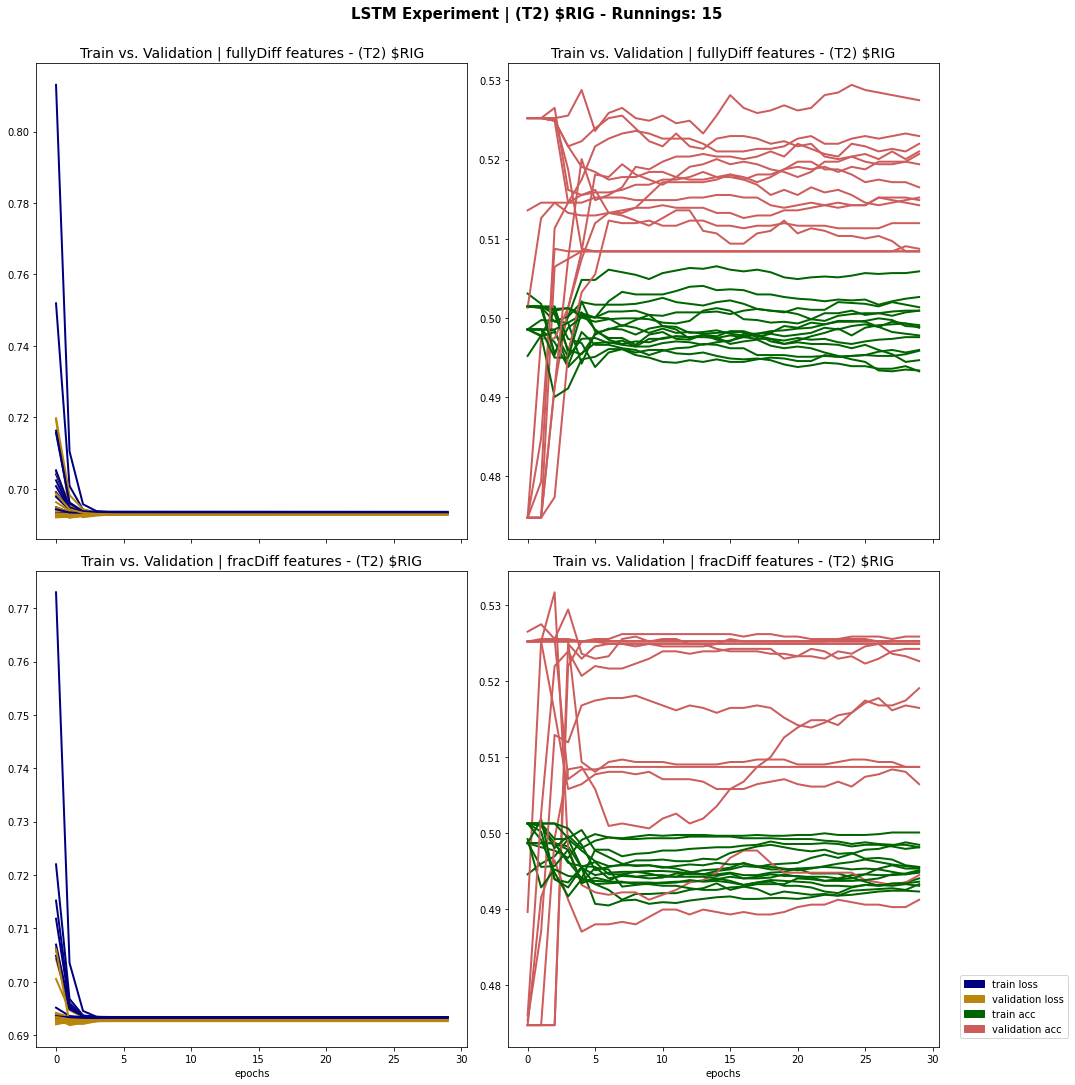

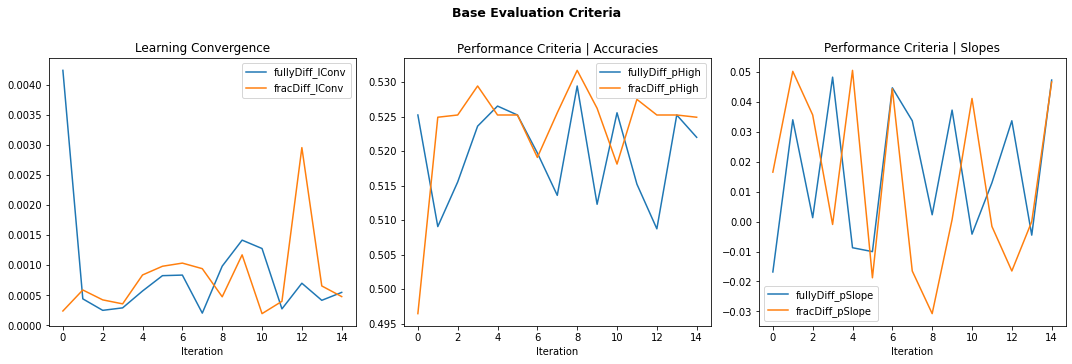

::::::>>> Stability Criteria Value | fullyDiff:  0.0009666273190322863
::::::>>> Stability Criteria Value | fracDiff:  0.0006514808802381204


In [135]:
comparissonLSTM('(T2) $RIG', numberIterations, {'fullyDiff': historiesA1, 'fracDiff': fdhistoriesA1}, fdmodelA1)

#### 3.1.3.  Trial 3

In [136]:
modelsA1, historiesA1, evasA1 = [], [], []
for times in tqdm(range(numberIterations), desc="LSTM | Iterative Testing process: "):
    modelA1, historyA1, evaA1 = \
    ExperimentLSTM(dataset=gset1, timestep=3).compute_LSTM(
        layers = 1,
        baseunits = 20, 
        unitsList = [0], 
        activationFunc = 'sigmoid',     
        optimizer = 'sgd',                    
        lossFunc = 'binary_crossentropy', 
        metricList = ['acc'],
        epochs = 50, 
        batch_size= 75, 
        dropout = 0.25, 
        dropoutLayers = [0],
        validation_split = 0.25
    )
    modelsA1.append(modelA1)    
    historiesA1.append(historyA1)
    evasA1.append(evaA1)    

LSTM | Iterative Testing process: 100%|████████████████████████████████████████████████| 15/15 [01:22<00:00,  5.49s/it]


In [137]:
fdModelsA1, fdhistoriesA1, fdEvasA1 = [], [], []
for times in tqdm(range(numberIterations), desc="LSTM | Iterative Testing process: "):
    fdmodelA1, fdhistoryA1, fdevaA1 = \
    ExperimentLSTM(dataset=fdgset1, timestep=3).compute_LSTM(
        layers = 1,
        baseunits = 20, 
        unitsList = [0], 
        activationFunc = 'sigmoid',     
        optimizer = 'sgd',                    
        lossFunc = 'binary_crossentropy', 
        metricList = ['acc'],
        epochs = 50, 
        batch_size= 75, 
        dropout = 0.25, 
        dropoutLayers = [0],
        validation_split = 0.25
    )
    fdModelsA1.append(fdmodelA1)
    fdhistoriesA1.append(fdhistoryA1)
    fdEvasA1.append(fdevaA1)

LSTM | Iterative Testing process: 100%|████████████████████████████████████████████████| 15/15 [01:20<00:00,  5.38s/it]


  (T3) $RIG | Fully vs. Frac  :::>>> Sample LSTM Model Configuration:

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': (...),
             'dtype': 'float32',
             'name': 'lstm_89_input',
             'ragged': False,
             'sparse': False}},
 {'class_name': 'LSTM',
  'config': {'activation': 'sigmoid',
             'activity_regularizer': None,
             'batch_input_shape': (...),
             'bias_constraint': None,
             'bias_initializer': {...},
             'bias_regularizer': None,
             'dropout': 0.25,
             'dtype': 'float32',
             'go_backwards': False,
             'implementation': 2,
             'kernel_constraint': None,
             'kernel_initializer': {...},
             'kernel_regularizer': None,
             'name': 'lstm_89',
             'recurrent_activation': 'sigmoid',
             'recurrent_constraint': None,
             'recurrent_dropout': 0.0,
             'recurrent_initializer': {...},

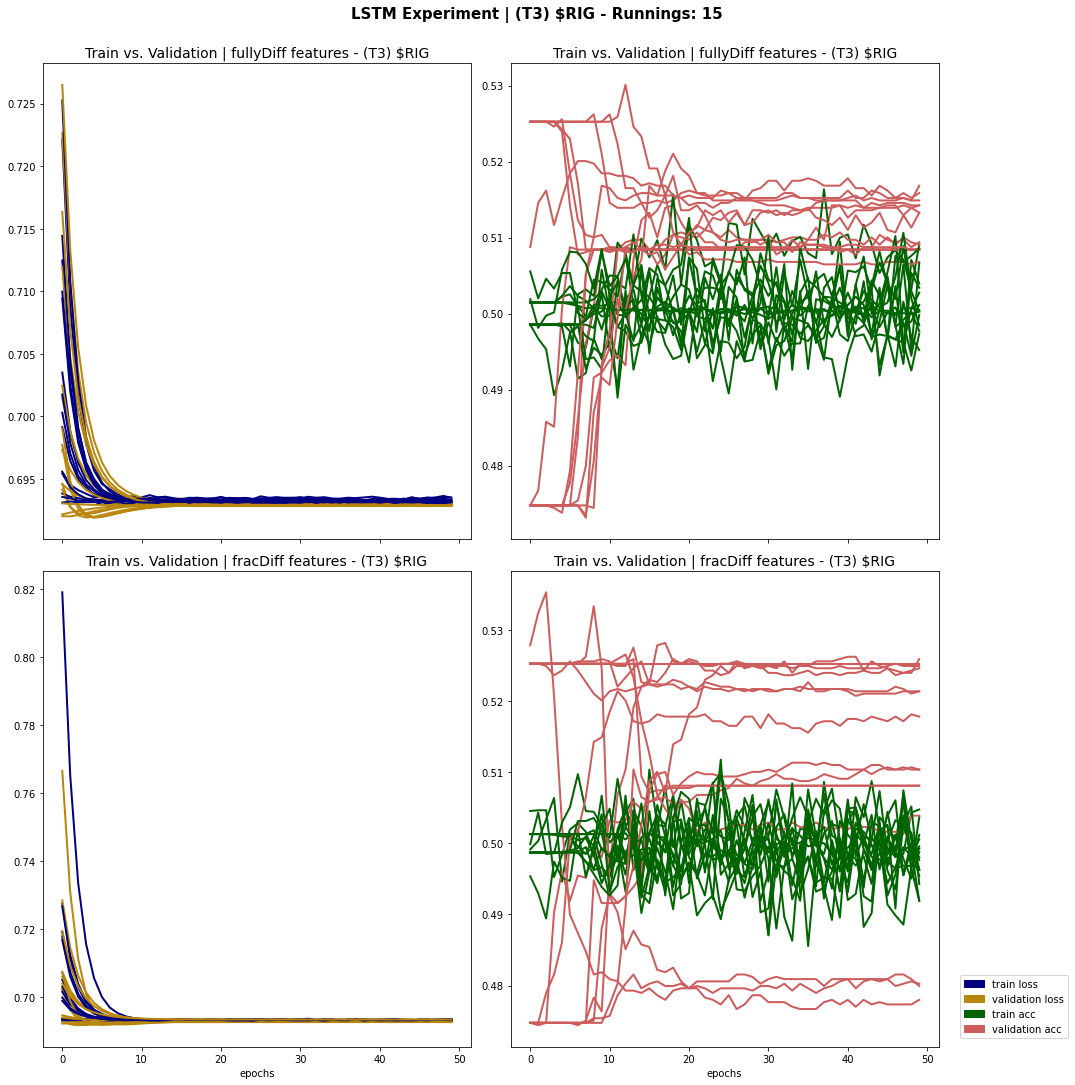

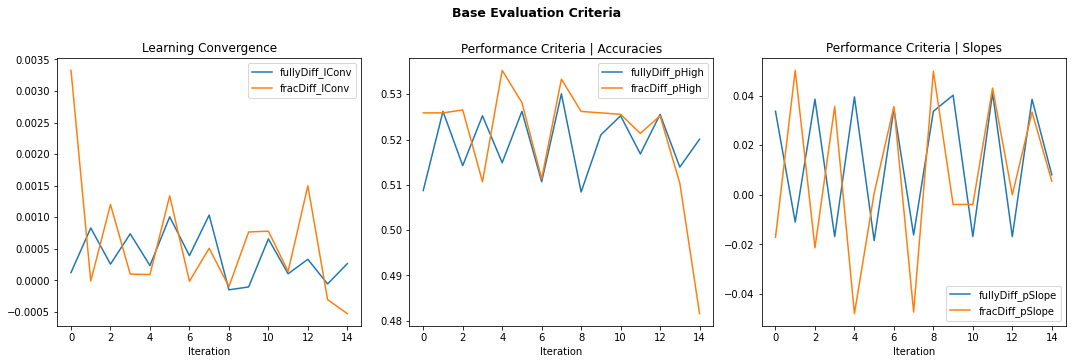

::::::>>> Stability Criteria Value | fullyDiff:  0.0003763295941379115
::::::>>> Stability Criteria Value | fracDiff:  0.0009397193359241182


In [139]:
comparissonLSTM('(T3) $RIG', numberIterations, {'fullyDiff': historiesA1, 'fracDiff': fdhistoriesA1}, fdmodelA1)

### 3.2. Asset 2

#### 3.2.1. Trial #1

In [140]:
modelsA2, historiesA2, evasA2 = [], [], []
for times in tqdm(range(numberIterations), desc="LSTM | Iterative Testing process: "):
    modelA2, historyA2, evaA2 = \
    ExperimentLSTM(dataset=gset2, timestep=2).compute_LSTM(      
        layers = 1,
        baseunits = 50, 
        unitsList = [0], 
        activationFunc = 'sigmoid',     
        optimizer = 'sgd',                    
        lossFunc = 'binary_crossentropy', 
        metricList = ['acc'],
        epochs = 30, 
        batch_size=45, 
        dropout = 0.0, 
        dropoutLayers = [0],
        validation_split = 0.25
    )
    modelsA2.append(modelA2)    
    historiesA2.append(historyA2)
    evasA2.append(evaA2) 

LSTM | Iterative Testing process: 100%|████████████████████████████████████████████████| 15/15 [01:15<00:00,  5.04s/it]


In [141]:
fdmodelsA2, fdhistoriesA2, fdevasA2 = [], [], []
for times in tqdm(range(numberIterations), desc="LSTM | Iterative Testing process: "):
    fdmodelA2, fdhistoryA2, fdevaA2 = \
    ExperimentLSTM(dataset=fdgset2, timestep=2).compute_LSTM(  
        layers = 1,
        baseunits = 50, 
        unitsList = [0], 
        activationFunc = 'sigmoid',     
        optimizer = 'sgd',                    
        lossFunc = 'binary_crossentropy', 
        metricList = ['acc'],
        epochs = 30, 
        batch_size=45, 
        dropout = 0.0, 
        dropoutLayers = [0],
        validation_split = 0.25
    )
    fdmodelsA2.append(fdmodelA2)    
    fdhistoriesA2.append(fdhistoryA2)
    fdevasA2.append(fdevaA2) 

LSTM | Iterative Testing process: 100%|████████████████████████████████████████████████| 15/15 [01:11<00:00,  4.77s/it]


  (T1) $PZZA | Fully vs. Frac  :::>>> Sample LSTM Model Configuration:

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': (...),
             'dtype': 'float32',
             'name': 'lstm_119_input',
             'ragged': False,
             'sparse': False}},
 {'class_name': 'LSTM',
  'config': {'activation': 'sigmoid',
             'activity_regularizer': None,
             'batch_input_shape': (...),
             'bias_constraint': None,
             'bias_initializer': {...},
             'bias_regularizer': None,
             'dropout': 0.0,
             'dtype': 'float32',
             'go_backwards': False,
             'implementation': 2,
             'kernel_constraint': None,
             'kernel_initializer': {...},
             'kernel_regularizer': None,
             'name': 'lstm_119',
             'recurrent_activation': 'sigmoid',
             'recurrent_constraint': None,
             'recurrent_dropout': 0.0,
             'recurrent_initializer': {...

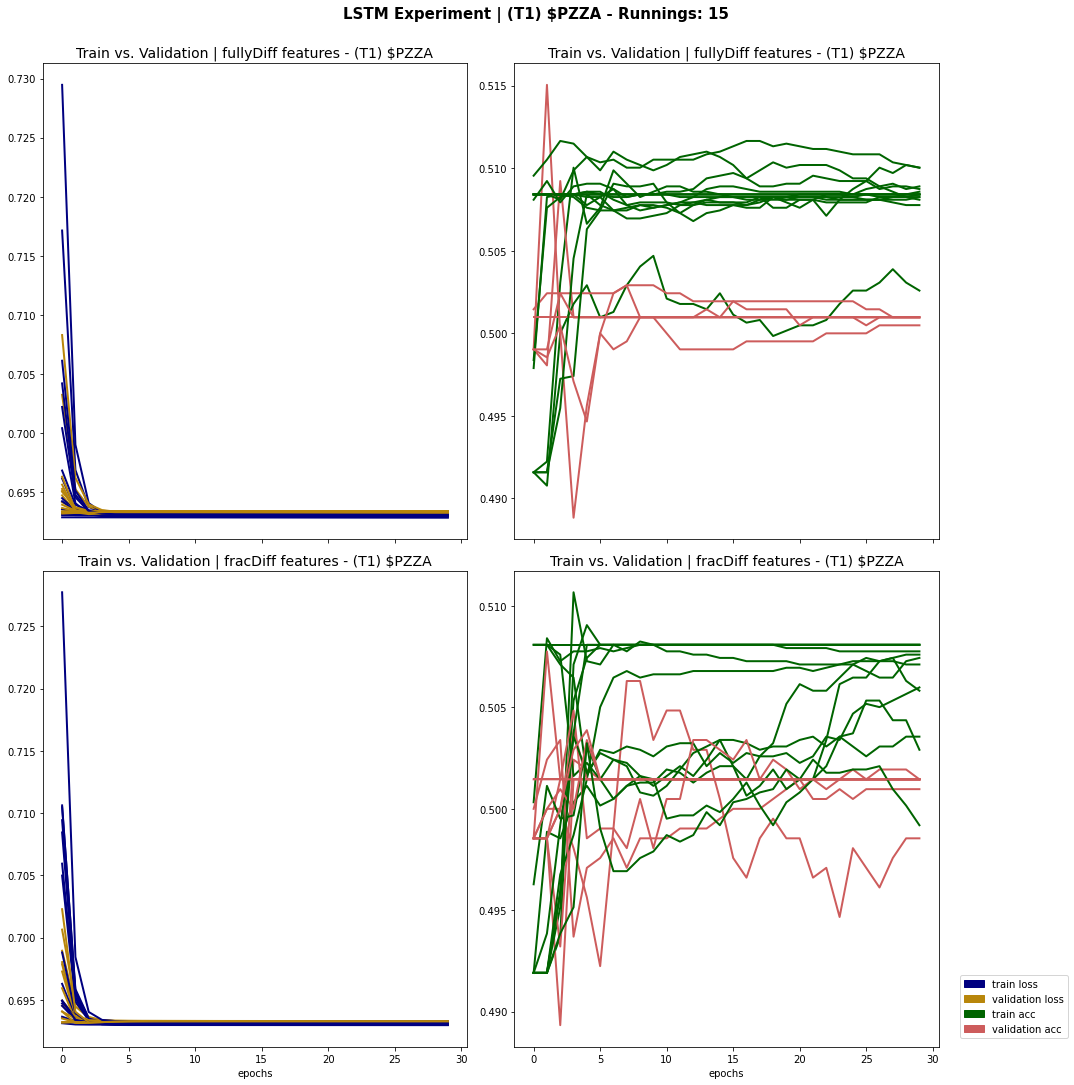

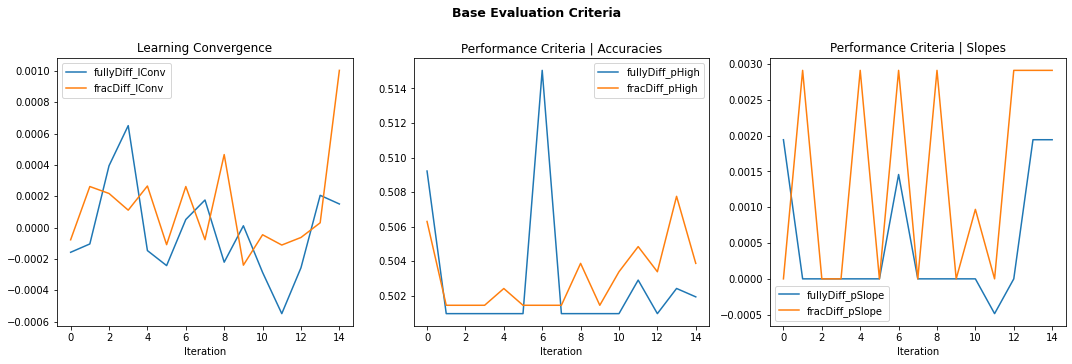

::::::>>> Stability Criteria Value | fullyDiff:  0.000292670304363812
::::::>>> Stability Criteria Value | fracDiff:  0.00030031484110300223


In [142]:
comparissonLSTM('(T1) $PZZA', numberIterations, {'fullyDiff': historiesA2, 'fracDiff': fdhistoriesA2}, fdmodelA2)

#### 3.2.2. Trial #2

In [143]:
modelsA2, historiesA2, evasA2 = [], [], []
for times in tqdm(range(numberIterations), desc="LSTM | Iterative Testing process: "):
    modelA2, historyA2, evaA2 = \
    ExperimentLSTM(dataset=gset2, timestep=3).compute_LSTM(     
        layers = 1,
        baseunits = 25, 
        unitsList = [0], 
        activationFunc = 'sigmoid',     
        optimizer = 'sgd',                    
        lossFunc = 'binary_crossentropy', 
        metricList = ['acc'],
        epochs = 30, 
        batch_size=25, 
        dropout = 0.0, 
        dropoutLayers = [0],
        validation_split = 0.25
    )
    modelsA2.append(modelA2)    
    historiesA2.append(historyA2)
    evasA2.append(evaA2) 

LSTM | Iterative Testing process: 100%|████████████████████████████████████████████████| 15/15 [01:44<00:00,  6.99s/it]


In [144]:
fdmodelsA2, fdhistoriesA2, fdevasA2 = [], [], []
for times in tqdm(range(numberIterations), desc="LSTM | Iterative Testing process: "):
    fdmodelA2, fdhistoryA2, fdevaA2 = \
    ExperimentLSTM(dataset=fdgset2, timestep=3).compute_LSTM(
        layers = 1,
        baseunits = 25, 
        unitsList = [0], 
        activationFunc = 'sigmoid',     
        optimizer = 'sgd',                    
        lossFunc = 'binary_crossentropy', 
        metricList = ['acc'],
        epochs = 30, 
        batch_size=25, 
        dropout = 0.0, 
        dropoutLayers = [0],
        validation_split = 0.25
    )
    fdmodelsA2.append(fdmodelA2)    
    fdhistoriesA2.append(fdhistoryA2)
    fdevasA2.append(fdevaA2) 

LSTM | Iterative Testing process: 100%|████████████████████████████████████████████████| 15/15 [01:48<00:00,  7.26s/it]


  (T2) $PZZA | Fully vs. Frac  :::>>> Sample LSTM Model Configuration:

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': (...),
             'dtype': 'float32',
             'name': 'lstm_149_input',
             'ragged': False,
             'sparse': False}},
 {'class_name': 'LSTM',
  'config': {'activation': 'sigmoid',
             'activity_regularizer': None,
             'batch_input_shape': (...),
             'bias_constraint': None,
             'bias_initializer': {...},
             'bias_regularizer': None,
             'dropout': 0.0,
             'dtype': 'float32',
             'go_backwards': False,
             'implementation': 2,
             'kernel_constraint': None,
             'kernel_initializer': {...},
             'kernel_regularizer': None,
             'name': 'lstm_149',
             'recurrent_activation': 'sigmoid',
             'recurrent_constraint': None,
             'recurrent_dropout': 0.0,
             'recurrent_initializer': {...

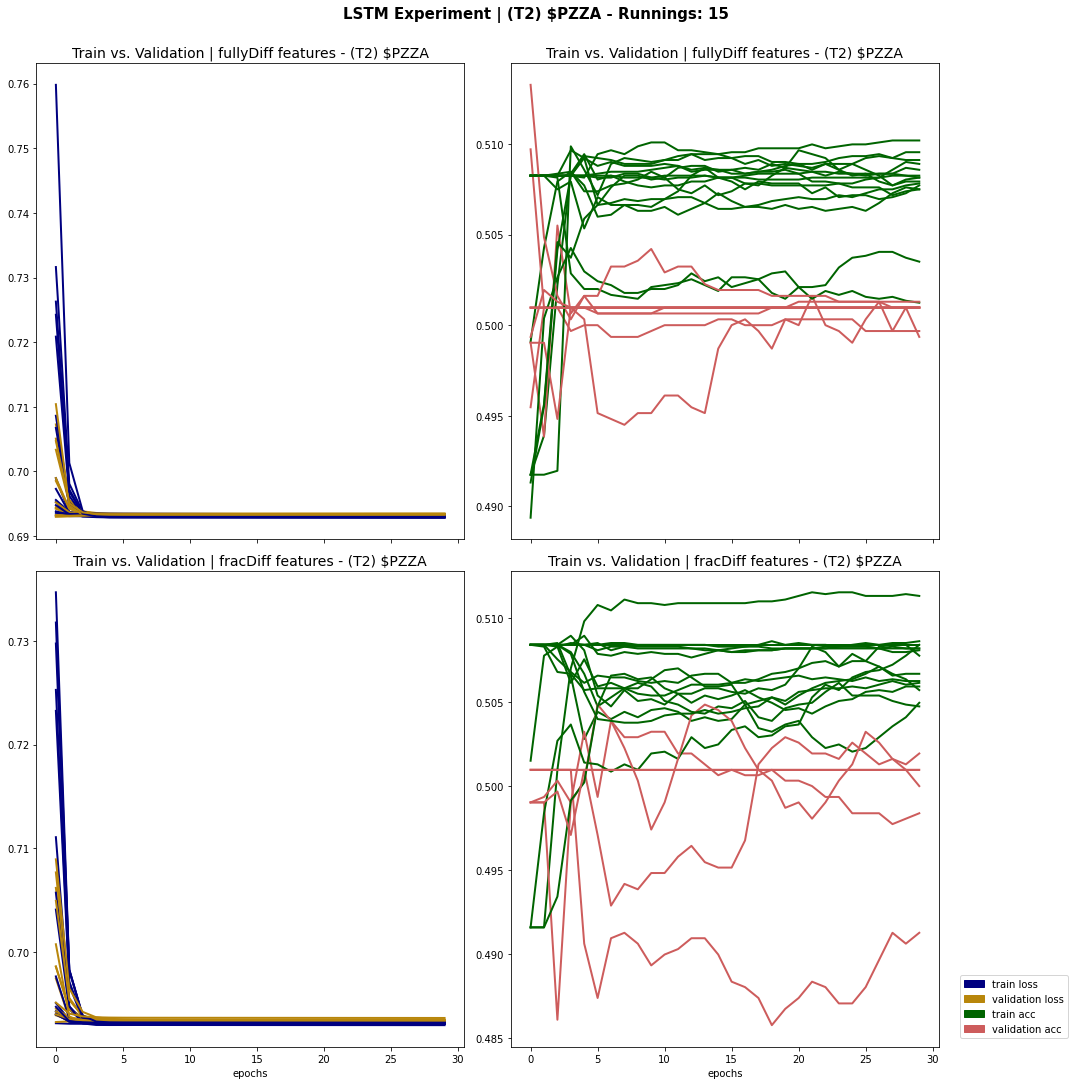

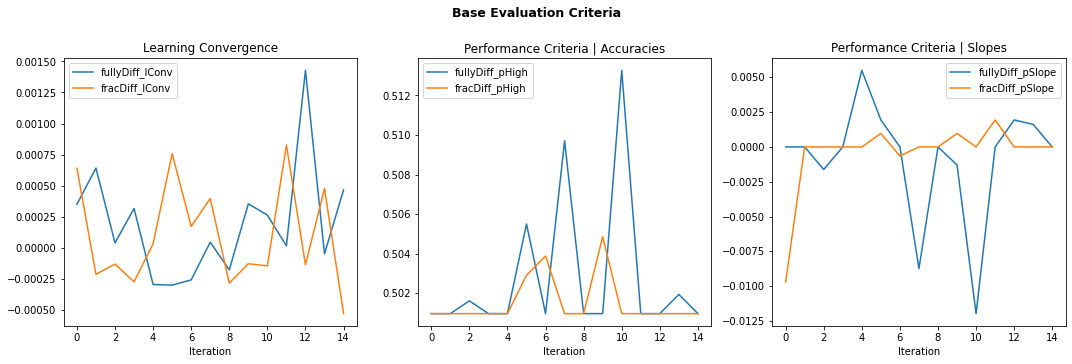

::::::>>> Stability Criteria Value | fullyDiff:  0.000434466298864712
::::::>>> Stability Criteria Value | fracDiff:  0.00040788402186832514


In [145]:
comparissonLSTM('(T2) $PZZA', numberIterations, {'fullyDiff': historiesA2, 'fracDiff': fdhistoriesA2}, fdmodelA2)

#### 3.2.3. Trial #3

In [146]:
modelsA2, historiesA2, evasA2 = [], [], []
for times in tqdm(range(numberIterations), desc="LSTM | Iterative Testing process: "):
    modelA2, historyA2, evaA2 = \
    ExperimentLSTM(dataset=gset2, timestep=3).compute_LSTM(
        layers = 1,
        baseunits = 20, 
        unitsList = [0], 
        activationFunc = 'sigmoid',     
        optimizer = 'sgd',                    
        lossFunc = 'binary_crossentropy', 
        metricList = ['acc'],
        epochs = 50, 
        batch_size= 75, 
        dropout = 0.25, 
        dropoutLayers = [0],
        validation_split = 0.25
    )
    modelsA2.append(modelA2)    
    historiesA2.append(historyA2)
    evasA2.append(evaA2) 

LSTM | Iterative Testing process: 100%|████████████████████████████████████████████████| 15/15 [01:25<00:00,  5.71s/it]


In [148]:
fdmodelsA2, fdhistoriesA2, fdevasA2 = [], [], []
for times in tqdm(range(numberIterations), desc="LSTM | Iterative Testing process: "):
    fdmodelA2, fdhistoryA2, fdevaA2 = \
    ExperimentLSTM(dataset=fdgset2, timestep=3).compute_LSTM(
        layers = 1,
        baseunits = 20, 
        unitsList = [0], 
        activationFunc = 'sigmoid',     
        optimizer = 'sgd',                    
        lossFunc = 'binary_crossentropy', 
        metricList = ['acc'],
        epochs = 50, 
        batch_size= 75, 
        dropout = 0.25, 
        dropoutLayers = [0],
        validation_split = 0.25
    )
    fdmodelsA2.append(fdmodelA2)    
    fdhistoriesA2.append(fdhistoryA2)
    fdevasA2.append(fdevaA2) 

LSTM | Iterative Testing process: 100%|████████████████████████████████████████████████| 15/15 [01:23<00:00,  5.54s/it]


  (T3) $PZZA | Fully vs. Frac  :::>>> Sample LSTM Model Configuration:

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': (...),
             'dtype': 'float32',
             'name': 'lstm_179_input',
             'ragged': False,
             'sparse': False}},
 {'class_name': 'LSTM',
  'config': {'activation': 'sigmoid',
             'activity_regularizer': None,
             'batch_input_shape': (...),
             'bias_constraint': None,
             'bias_initializer': {...},
             'bias_regularizer': None,
             'dropout': 0.25,
             'dtype': 'float32',
             'go_backwards': False,
             'implementation': 2,
             'kernel_constraint': None,
             'kernel_initializer': {...},
             'kernel_regularizer': None,
             'name': 'lstm_179',
             'recurrent_activation': 'sigmoid',
             'recurrent_constraint': None,
             'recurrent_dropout': 0.0,
             'recurrent_initializer': {..

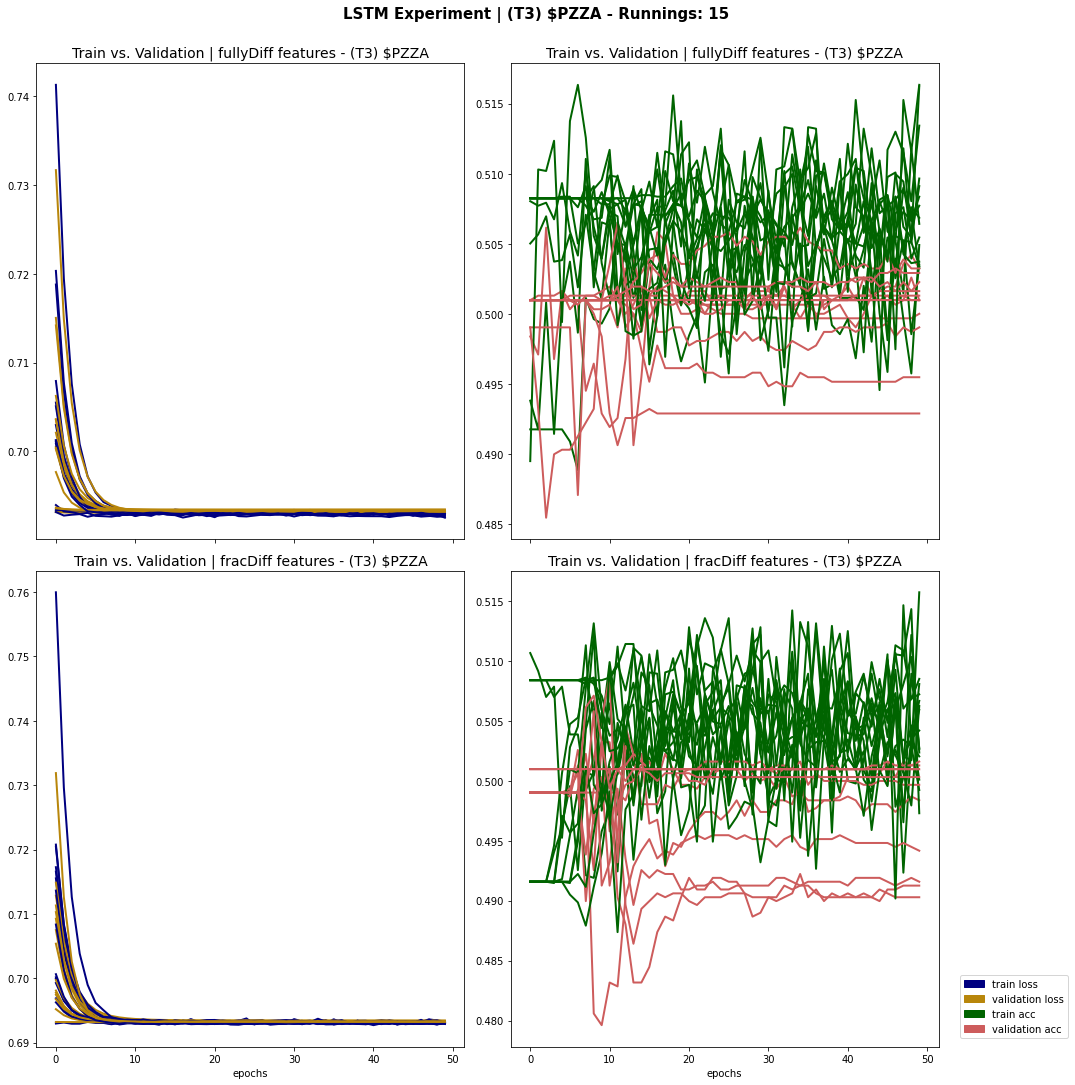

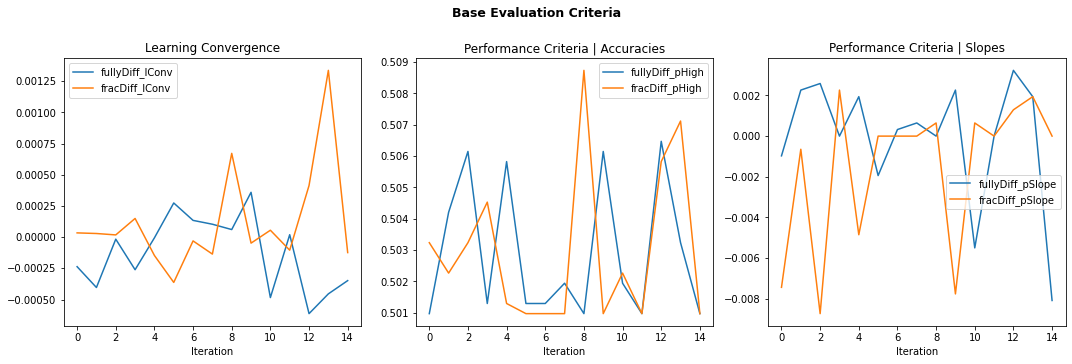

::::::>>> Stability Criteria Value | fullyDiff:  0.0002862487196758142
::::::>>> Stability Criteria Value | fracDiff:  0.0004026797123019529


In [149]:
comparissonLSTM('(T3) $PZZA', numberIterations, {'fullyDiff': historiesA2, 'fracDiff': fdhistoriesA2}, fdmodelA2)

***

<center>CQF Final Project finished